In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 136]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/sagittal/t1c", t2f_dir="PED_Sliced/sagittal/t2f", seg_dir="PED_Sliced/sagittal/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



4848
202
Data shape: torch.Size([24, 2, 240, 155])
Labels shape: torch.Size([24, 240, 155])
Data shape: torch.Size([24, 2, 240, 155])
Labels shape: torch.Size([24, 240, 155])


In [6]:
# import torch
# import torch.nn as  nn
# import torch.nn.functional as F


# class Bottleneck(nn.Module):
#     expansion = 4
#     def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
#         super(Bottleneck, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
#         self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
#         self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         identity = x.clone()
#         x = self.relu(self.batch_norm1(self.conv1(x)))
        
#         x = self.relu(self.batch_norm2(self.conv2(x)))
        
#         x = self.conv3(x)
#         x = self.batch_norm3(x)
        
#         #downsample if needed
#         if self.i_downsample is not None:
#             identity = self.i_downsample(identity)
#         #add identity
#         x+=identity
#         x=self.relu(x)
        
#         return x

# class Block(nn.Module):
#     expansion = 1
#     def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
#         super(Block, self).__init__()
       

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)

#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         identity = x.clone()

#         x = self.relu(self.batch_norm2(self.conv1(x)))
#         x = self.batch_norm2(self.conv2(x))

#         if self.i_downsample is not None:
#             identity = self.i_downsample(identity)
#         print(x.shape)
#         print(identity.shape)
#         x += identity
#         x = self.relu(x)
#         return x


        
        
# class ResNet50(nn.Module):
#     def __init__(self, ResBlock, layer_list, num_classes, num_channels=2, image_size=(240, 240)):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.image_size = image_size

#         self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=1, padding=3, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()

#         self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
#         self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128)
#         self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256)
#         self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512)

#         self.conv_final = nn.Conv2d(512 * ResBlock.expansion, num_classes, kernel_size=1)

#     def forward(self, x):
#         x = self.relu(self.batch_norm1(self.conv1(x)))

#         x = self.layer1(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer2(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer3(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer4(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.conv_final(x)
#         x = F.interpolate(x, size=self.image_size, mode='bilinear', align_corners=False)

#         return x

        
#     def _make_layer(self, ResBlock, blocks, planes, stride=1):
#         ii_downsample = None
#         layers = []
        
#         if stride != 1 or self.in_channels != planes*ResBlock.expansion:
#             ii_downsample = nn.Sequential(
#                 nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(planes*ResBlock.expansion)
#             )
            
#         layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
#         self.in_channels = planes*ResBlock.expansion
        
#         for i in range(blocks-1):
#             layers.append(ResBlock(self.in_channels, planes))
            
#         return nn.Sequential(*layers)

        
        
# # def ResNet50(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
# # def ResNet101(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

# # def ResNet152(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [7]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.conv(x)

    
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

class ResUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResUNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Residual blocks
        self.residual_block1 = ResidualBlock(1024)
        self.residual_block2 = ResidualBlock(512)
        self.residual_block3 = ResidualBlock(256)
        self.residual_block4 = ResidualBlock(128)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)
        c5 = self.residual_block1(c5)

        # Upsample path
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim=1)
        c6 = self.conv6(merge6)
        c6 = self.residual_block2(c6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim=1)
        c7 = self.conv7(merge7)
        c7 = self.residual_block3(c7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim=1)
        c8 = self.conv8(merge8)
        c8 = self.residual_block4(c8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim=1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out

    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [8]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [9]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [10]:
from tqdm import tqdm

def train_model(num_epochs):
    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    model_path = "resUnet_PED_sagittal.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = ResUNet(2,4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = ResUNet(2,4).to(device)
        print("New model initialized.")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")
        running_loss = 0.0
        num_batches = 0
        running_train_dsc = []
        running_train_assd = []

        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
                plot_preds_and_masks(preds, masks[:2])

            running_loss += loss.item()
            num_batches += 1

            # Computing DSC score and other metrics
            _, preds = torch.max(outputs, 1)
            preds_one_hot = F.one_hot(preds, num_classes = 4)
            preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)
            masks_one_hot = F.one_hot(masks, num_classes = 4)
            masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)
            train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
            running_train_dsc.append(train_dsc)
            running_train_assd.append(train_assd)

        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")
        print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        model.eval()  
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device).long()

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                running_val_loss += val_loss.item()
                num_val_batches += 1

                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    plot_preds_and_masks(preds, val_masks[:2])

                # Computing DSC score and other metrics for validation set
                _, val_preds = torch.max(val_outputs, 1)
                val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)
                val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                running_val_dsc.append(val_dsc)
                running_val_assd.append(val_assd)

        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")
        print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        torch.save(model.state_dict(), "resUnet_PED_sagittal.pth")

    return model


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


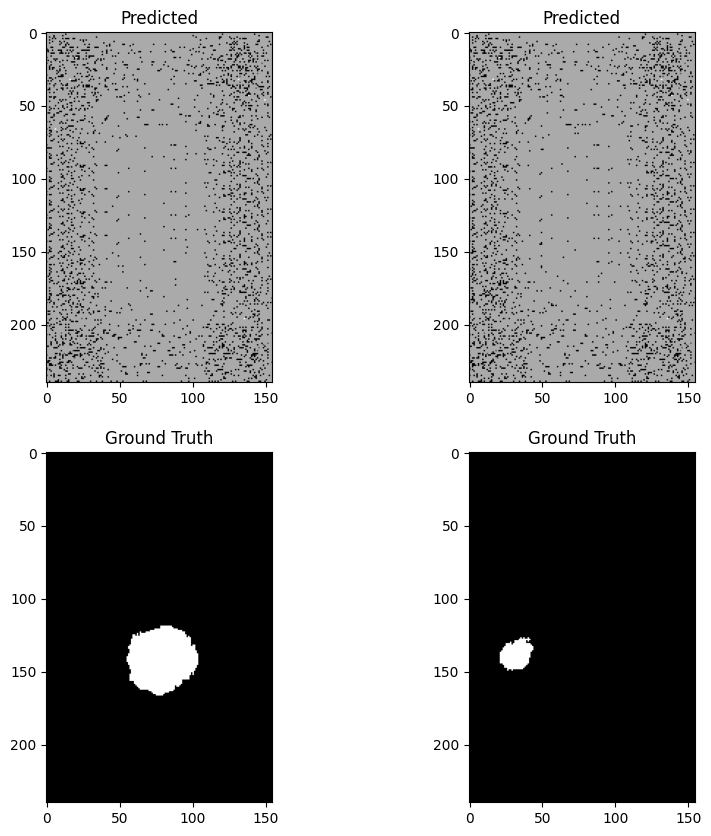

100%|██████████| 202/202 [06:54<00:00,  2.05s/it]



Average Training Loss: 0.25655117457603466

Average Training DSC: [9.72896469e-01 4.42864207e-01 7.05679545e-01 3.66215050e-07]
Average Training ASSD: [  3.84623332 199.46899533 102.62954406 359.10134961]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


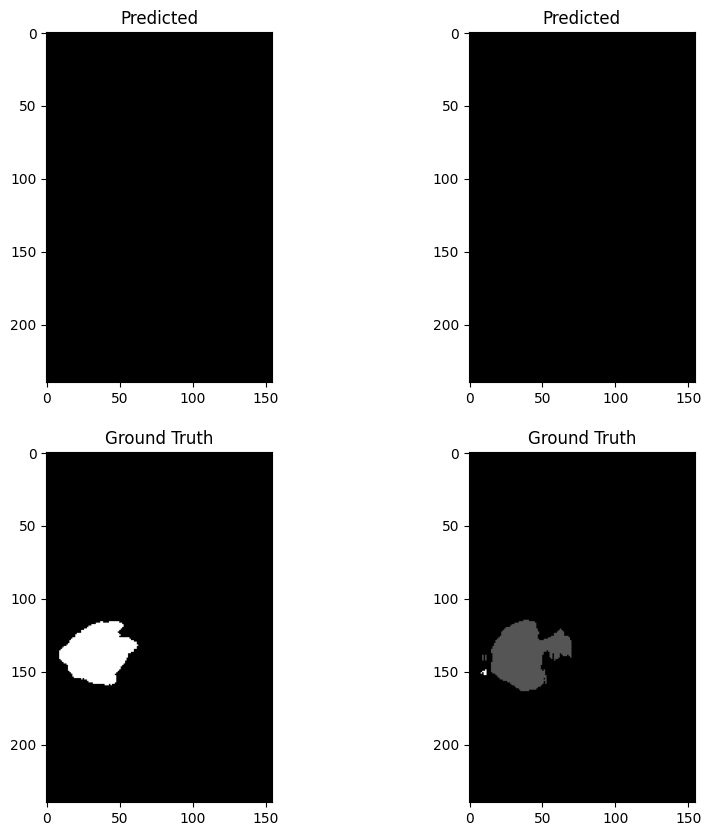

100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Average Validation Loss: 0.14386995239000694

Average Validation DSC: [9.84986554e-01 4.35394671e-01 7.39756159e-01 4.95300629e-04]
Average Validation ASSD: [  3.6151354  204.38712921  94.20827049 336.69278435]
Epoch 2/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


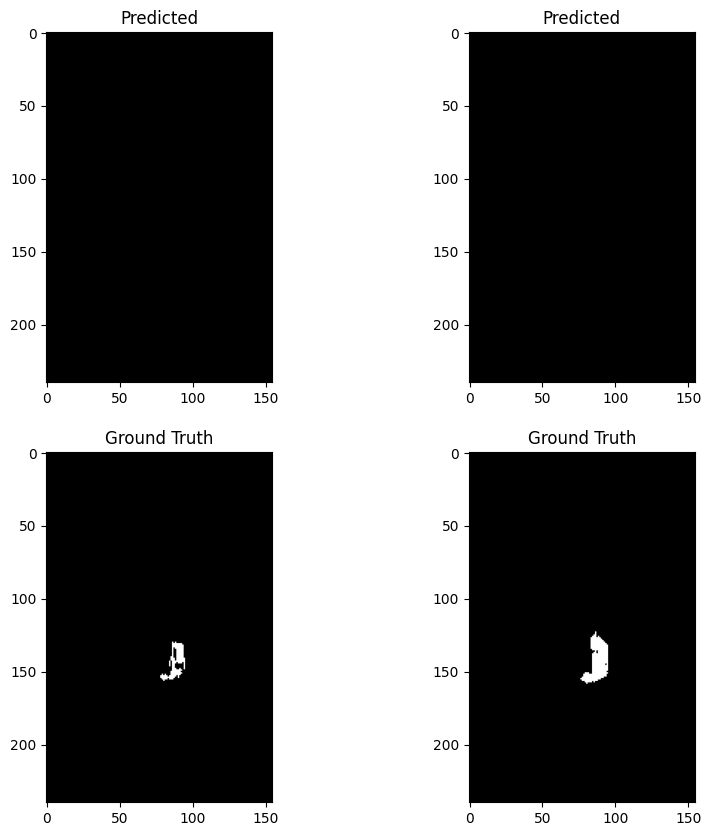

100%|██████████| 202/202 [07:38<00:00,  2.27s/it]



Average Training Loss: 0.06796454717543456

Average Training DSC: [0.99176619 0.26668374 0.75165017 0.34029542]
Average Training ASSD: [  0.99015945 156.8884721   89.90264026  53.87217121]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


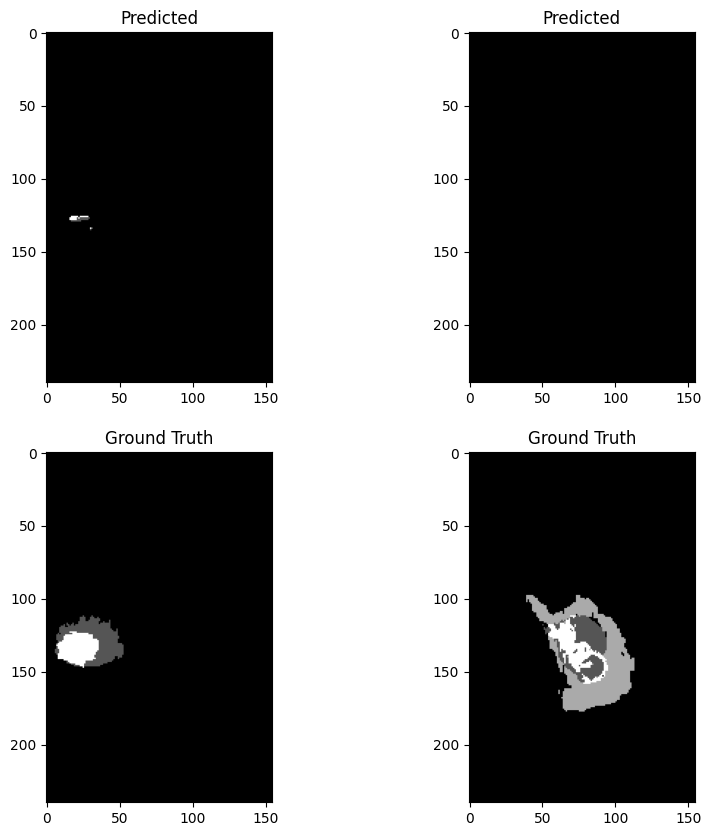

100%|██████████| 51/51 [01:24<00:00,  1.66s/it]


Average Validation Loss: 0.12120763475404066

Average Validation DSC: [0.98665304 0.31214971 0.73975616 0.10661604]
Average Validation ASSD: [  2.47827058 175.13345915  94.20827049 186.80567056]
Epoch 3/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


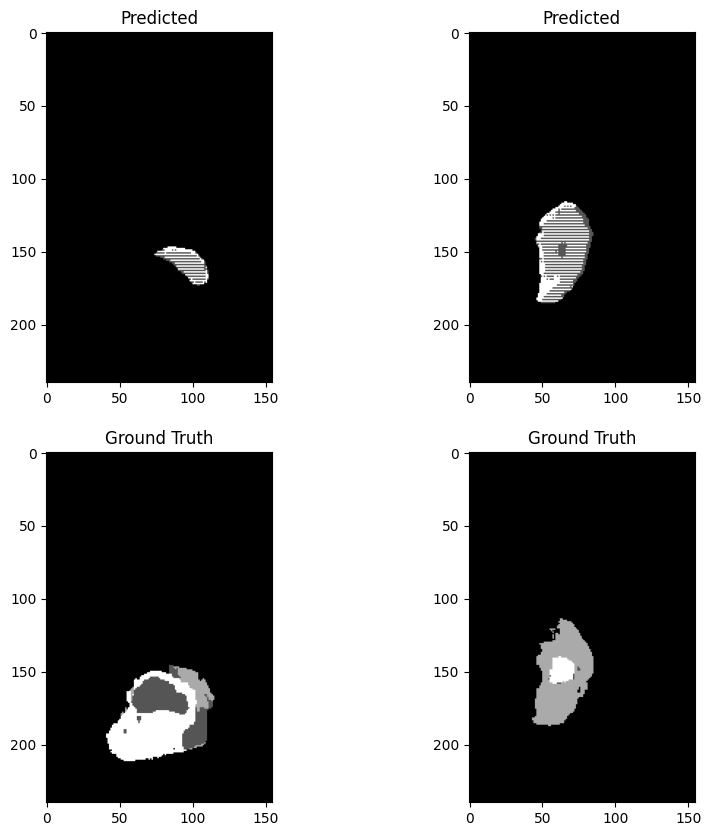

100%|██████████| 202/202 [07:10<00:00,  2.13s/it]



Average Training Loss: 0.059968452273619056

Average Training DSC: [0.99364275 0.26769678 0.75165017 0.3784914 ]
Average Training ASSD: [  0.70999703 135.13811018  89.90264026  40.1340344 ]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


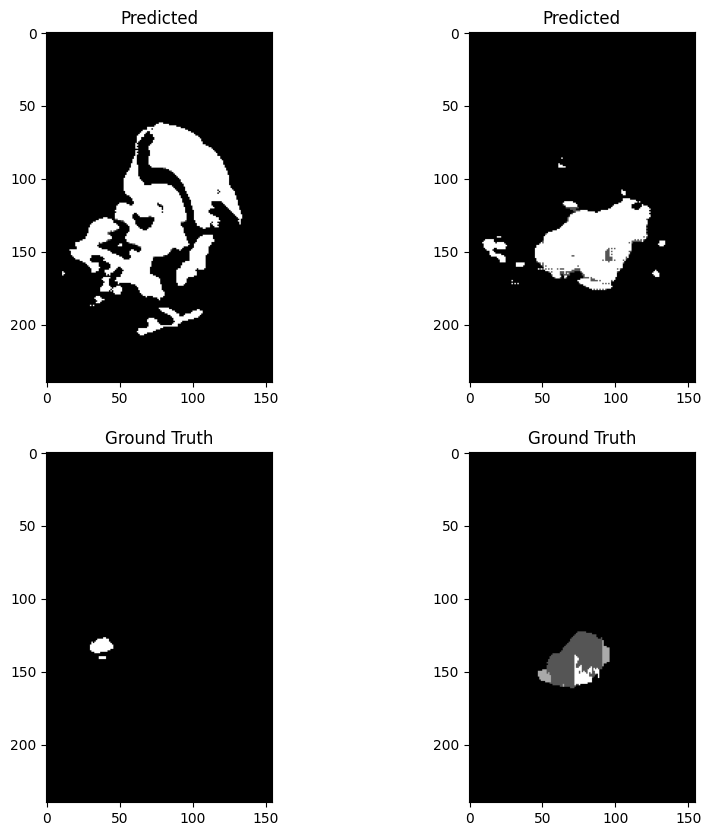

100%|██████████| 51/51 [01:17<00:00,  1.53s/it]


Average Validation Loss: 0.24399376704412348

Average Validation DSC: [0.96408349 0.03105636 0.73837355 0.24664488]
Average Validation ASSD: [  4.24138812 161.67184037  94.70877325  17.64534819]
Epoch 4/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


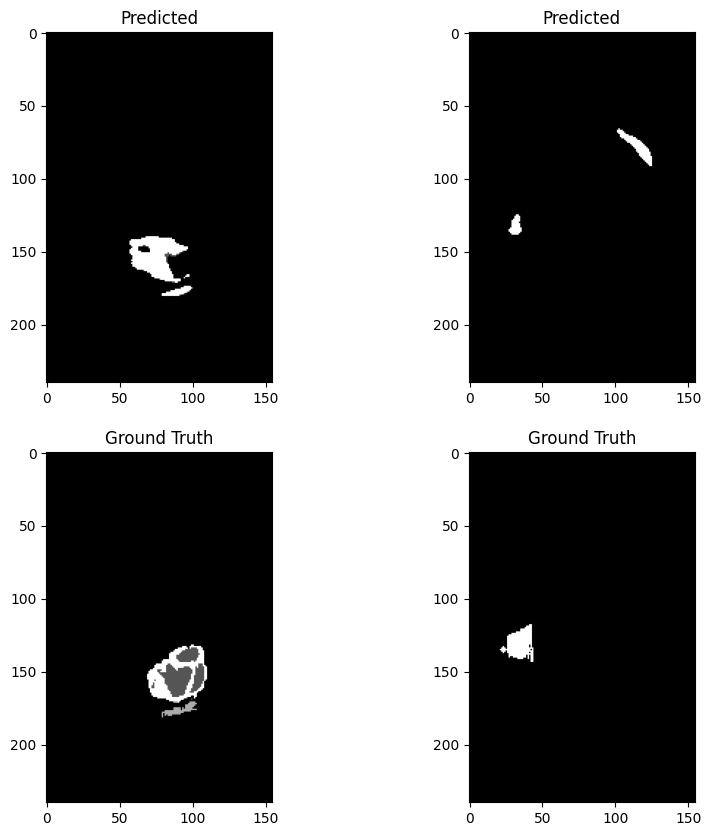

100%|██████████| 202/202 [07:04<00:00,  2.10s/it]



Average Training Loss: 0.056750900785226634

Average Training DSC: [0.99419867 0.32799779 0.75165017 0.37988984]
Average Training ASSD: [  0.64888346 128.81097898  89.90264026  41.15501207]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


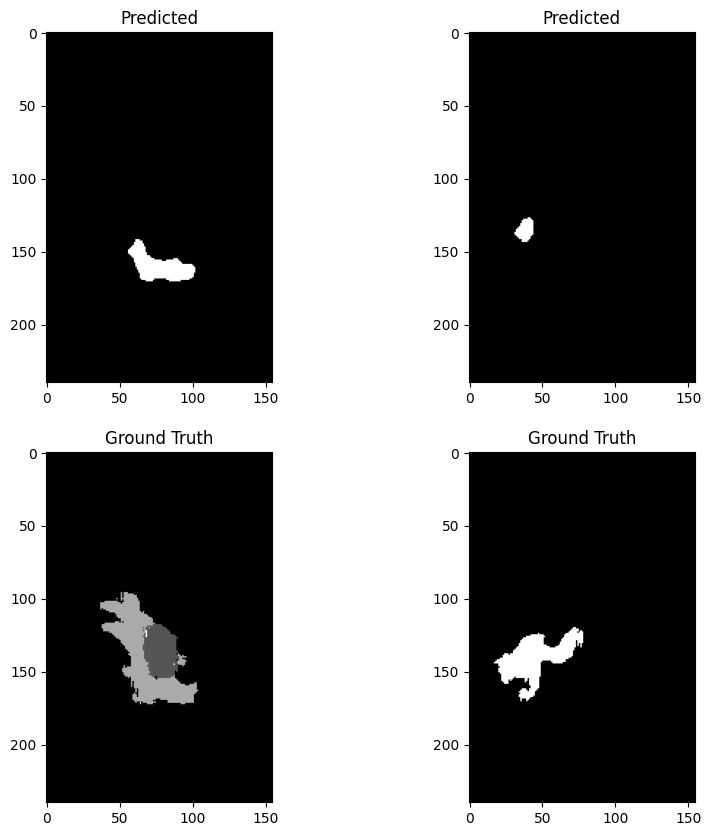

100%|██████████| 51/51 [01:13<00:00,  1.43s/it]


Average Validation Loss: 0.08736265443411528

Average Validation DSC: [0.98968713 0.37124483 0.73906486 0.29479157]
Average Validation ASSD: [  1.3362945  153.8676112   94.45852187  71.04219715]
Epoch 5/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


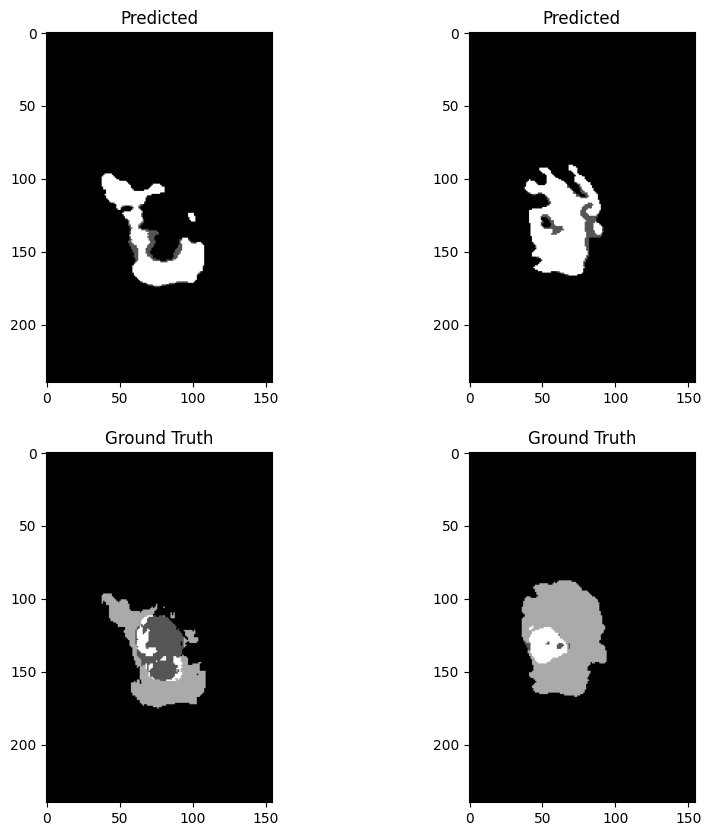

100%|██████████| 202/202 [07:03<00:00,  2.10s/it]



Average Training Loss: 0.05217482435452466

Average Training DSC: [0.99460146 0.37681258 0.67800603 0.37192281]
Average Training ASSD: [  0.58679427 122.26310399  84.79893418  43.78663682]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


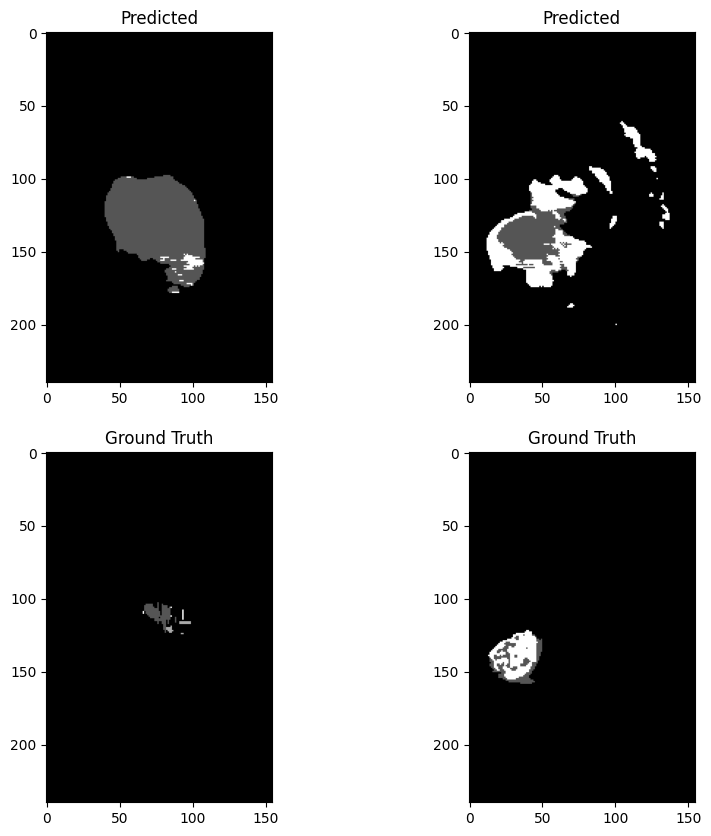

100%|██████████| 51/51 [01:15<00:00,  1.47s/it]


Average Validation Loss: 0.2941761531081854

Average Validation DSC: [0.95267057 0.19067645 0.62408778 0.07925269]
Average Validation ASSD: [  5.04930986 164.83718753 117.8185663   26.16643639]
Epoch 6/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


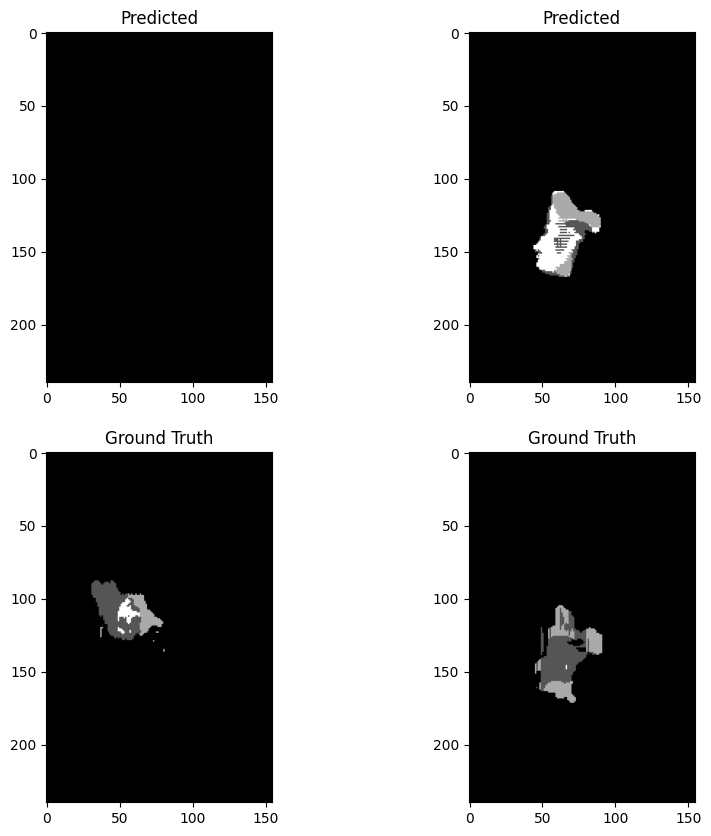

100%|██████████| 202/202 [07:03<00:00,  2.10s/it]



Average Training Loss: 0.04816169800734756

Average Training DSC: [0.99502596 0.38866404 0.67669322 0.38052398]
Average Training ASSD: [  0.55182173 118.82345151  80.40156709  44.92287296]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


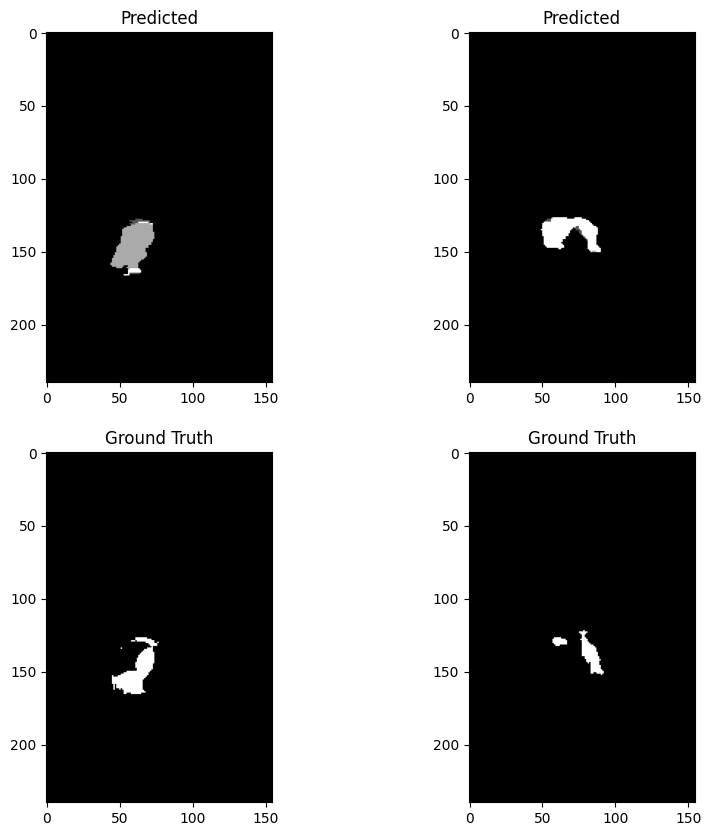

100%|██████████| 51/51 [01:18<00:00,  1.54s/it]


Average Validation Loss: 0.10138465668640885

Average Validation DSC: [0.98586494 0.22287555 0.4497631  0.36190142]
Average Validation ASSD: [  1.63385884 142.18287553 147.59435809  24.78069727]
Epoch 7/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


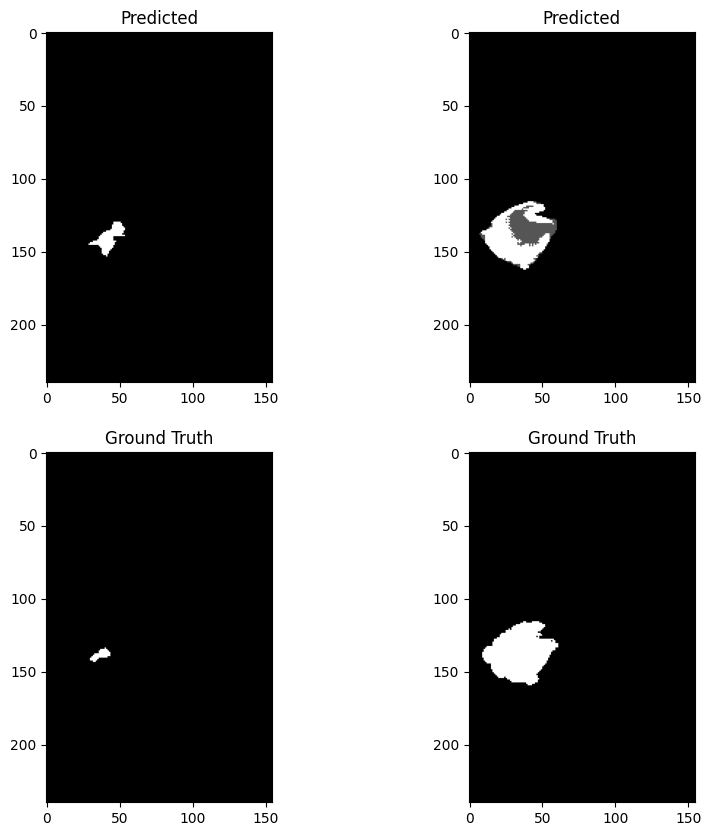

100%|██████████| 202/202 [06:56<00:00,  2.06s/it]



Average Training Loss: 0.045166167218496305

Average Training DSC: [0.99543168 0.39017492 0.70306838 0.38785757]
Average Training ASSD: [  0.50512311 119.40969005  73.121551    40.62744411]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


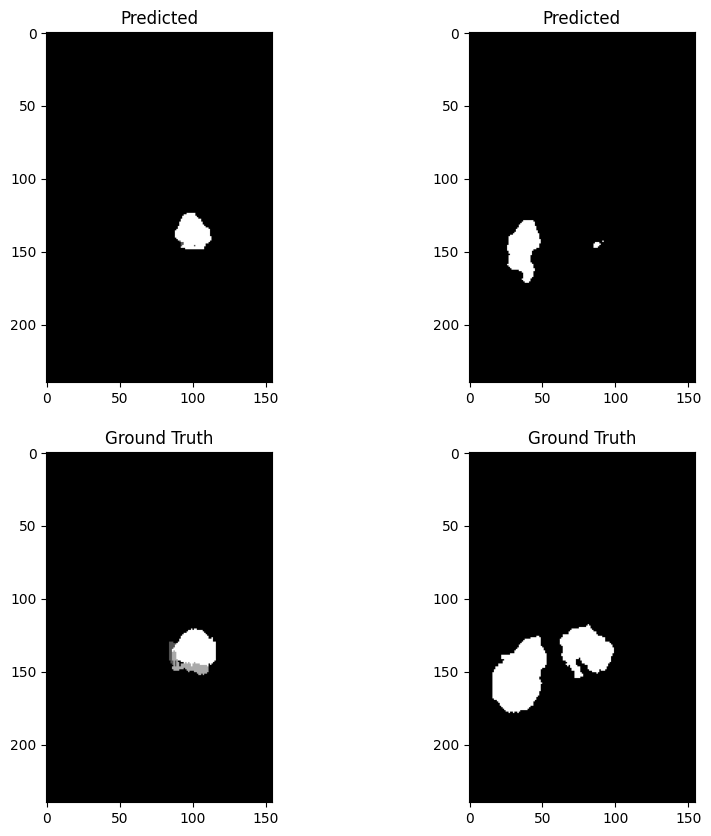

100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Average Validation Loss: 0.05490409560939845

Average Validation DSC: [0.9936108  0.40061071 0.75684318 0.37151018]
Average Validation ASSD: [  0.80281565 126.88725028  58.37031474  60.73238072]
Epoch 8/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


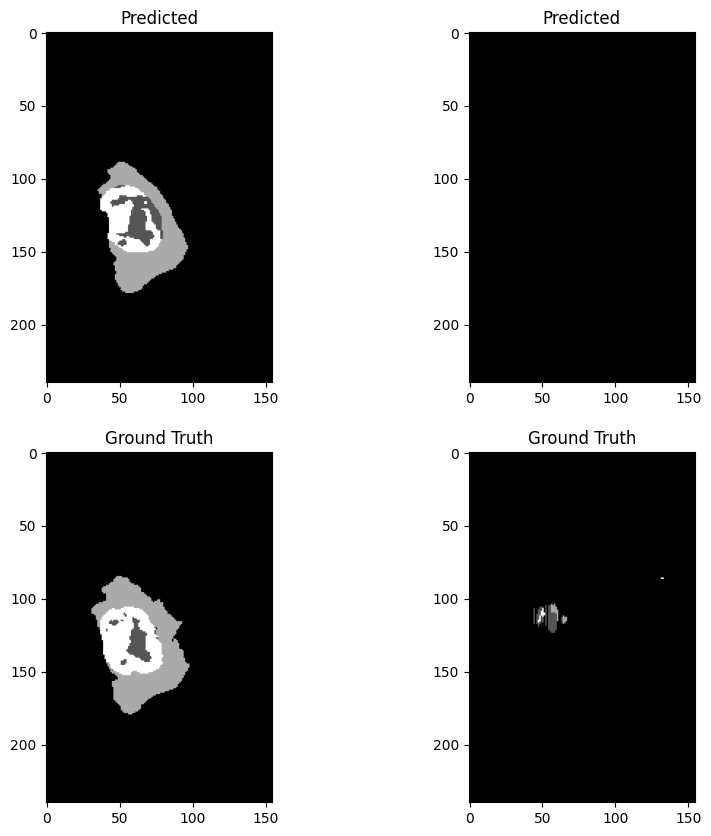

100%|██████████| 202/202 [07:01<00:00,  2.09s/it]



Average Training Loss: 0.04144511442852787

Average Training DSC: [0.99587354 0.40994129 0.73137348 0.40412108]
Average Training ASSD: [  0.4508508  118.12180404  66.89977226  39.99928605]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


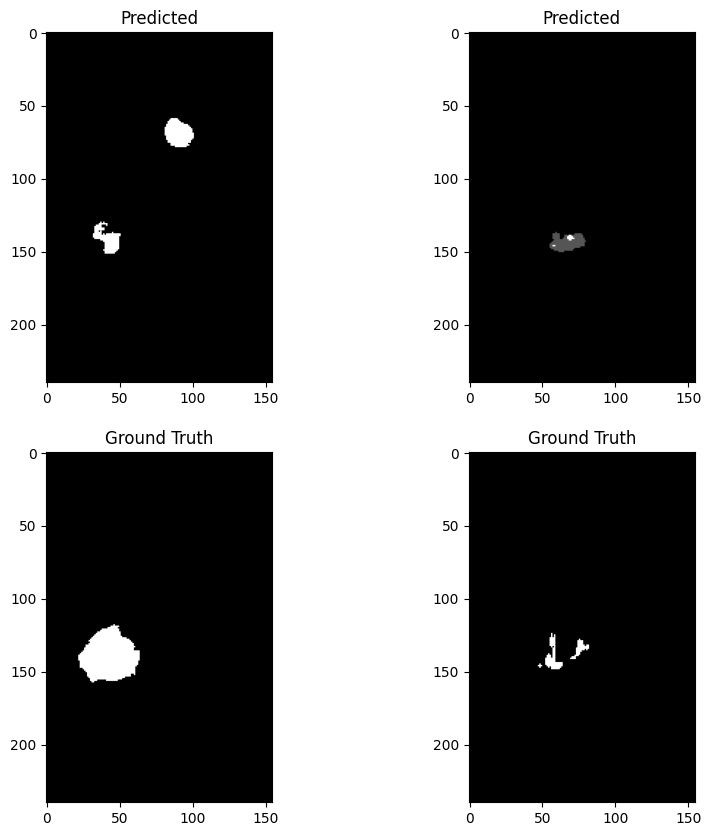

100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Average Validation Loss: 0.06620268604042483

Average Validation DSC: [0.9919624  0.32463319 0.52185463 0.27584943]
Average Validation ASSD: [  1.07657655 130.34440033 125.57635746  85.21967427]
Epoch 9/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


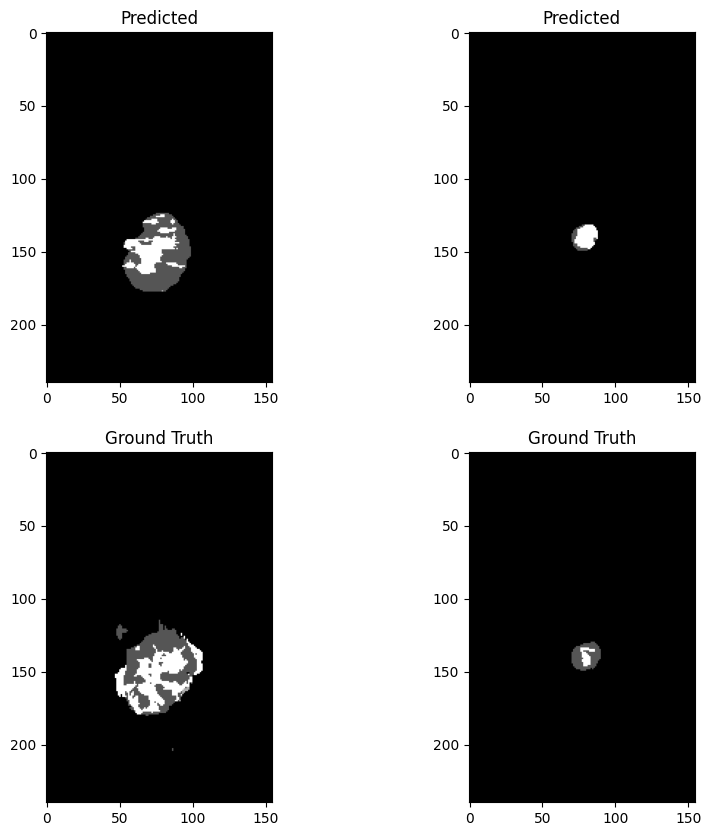

100%|██████████| 202/202 [07:00<00:00,  2.08s/it]



Average Training Loss: 0.038603887432208744

Average Training DSC: [0.99625604 0.41898101 0.74755841 0.42992221]
Average Training ASSD: [  0.40410574 117.49977837  61.11609491  35.15143779]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


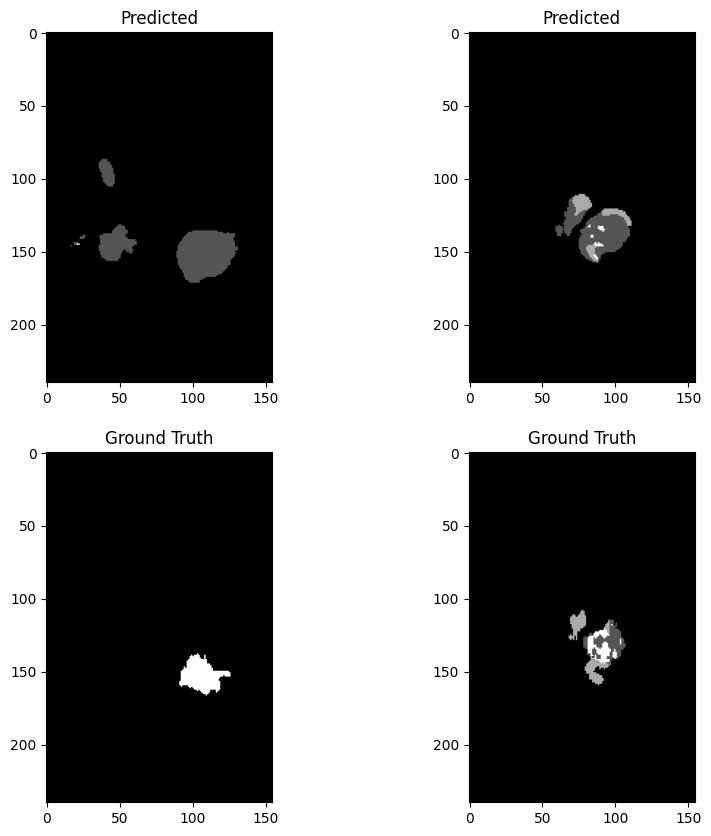

100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Average Validation Loss: 0.12684606059509165

Average Validation DSC: [0.98276738 0.28583344 0.4589934  0.13871355]
Average Validation ASSD: [  2.08738439 158.40622986 148.07381904  41.43661836]
Epoch 10/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


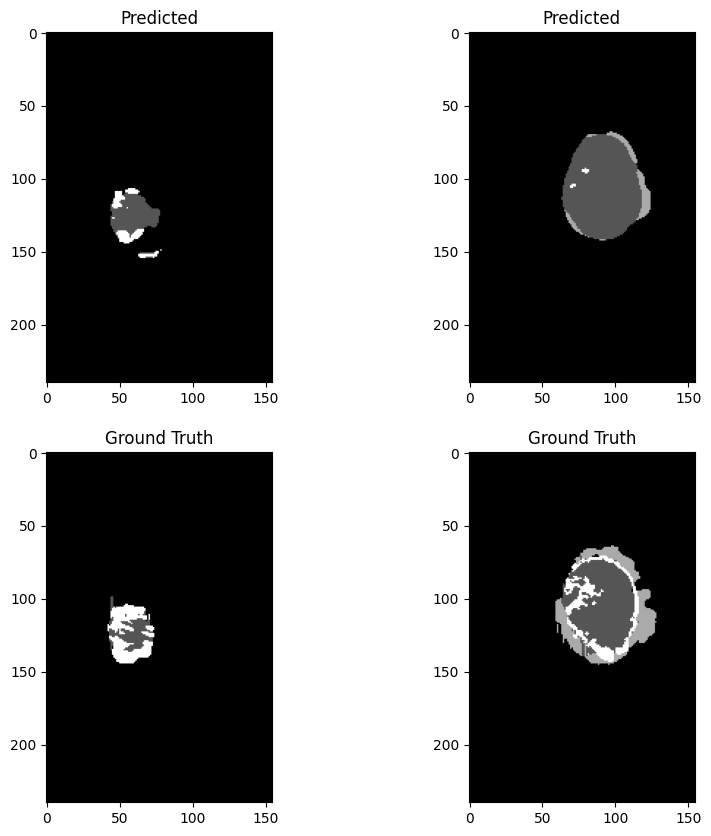

100%|██████████| 202/202 [07:10<00:00,  2.13s/it]



Average Training Loss: 0.03631875412262017

Average Training DSC: [0.99654979 0.44192549 0.75763361 0.4450358 ]
Average Training ASSD: [  0.37749396 111.31299319  58.15760793  32.48570399]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


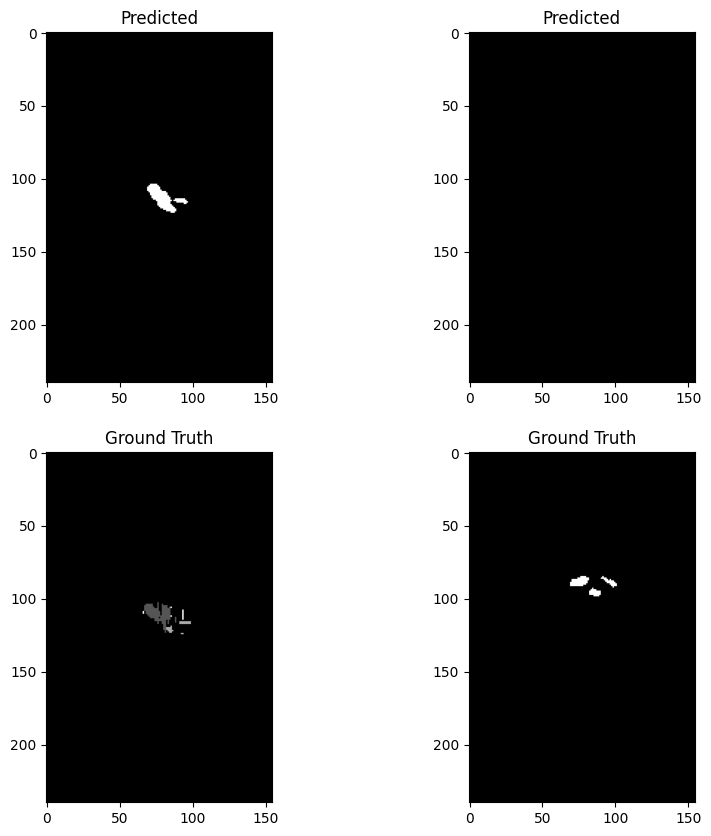

100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Average Validation Loss: 0.04967591129973823

Average Validation DSC: [0.99549625 0.36813315 0.58346045 0.18548629]
Average Validation ASSD: [  0.45921029 148.83122854 109.62010523  75.27515067]
Epoch 11/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


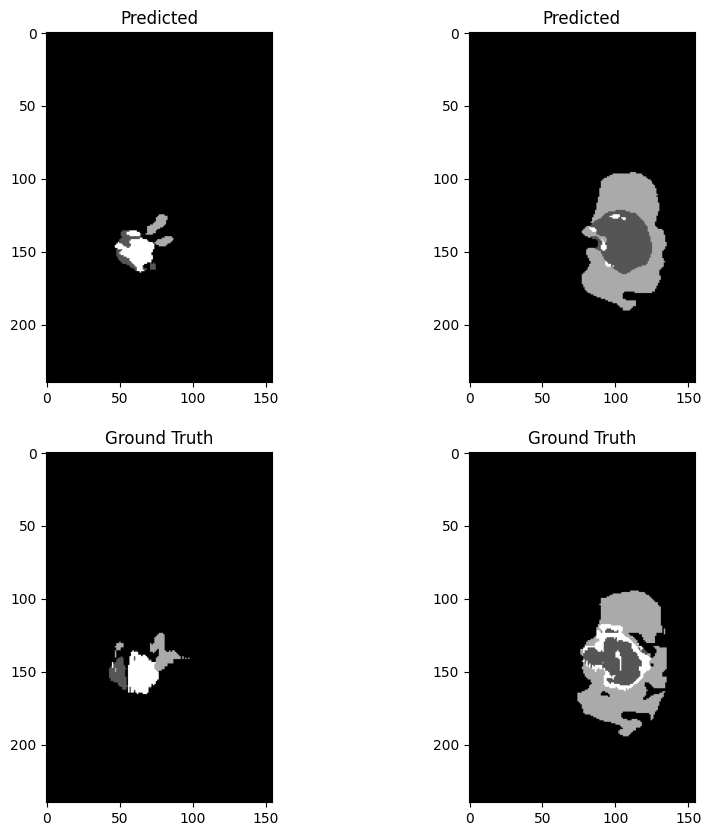

100%|██████████| 202/202 [07:03<00:00,  2.10s/it]



Average Training Loss: 0.032915308924004585

Average Training DSC: [0.99691055 0.48841529 0.76949537 0.47852159]
Average Training ASSD: [  0.33015194 103.40664085  55.59537774  26.57374487]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


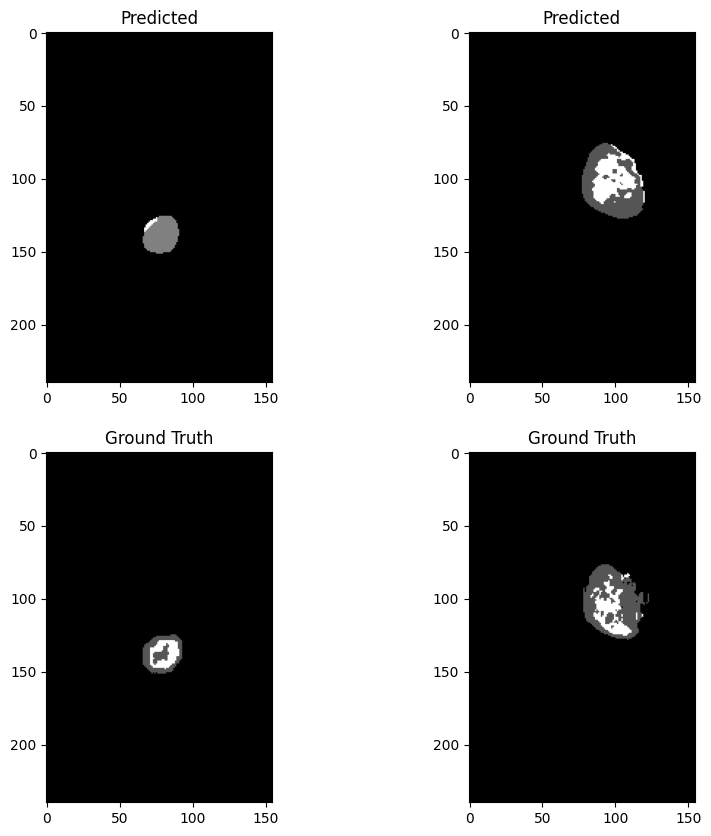

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.037947013864622396

Average Validation DSC: [0.99617483 0.45862653 0.67214875 0.43221737]
Average Validation ASSD: [  0.44068812 117.12588301  83.3944686   25.96937846]
Epoch 12/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


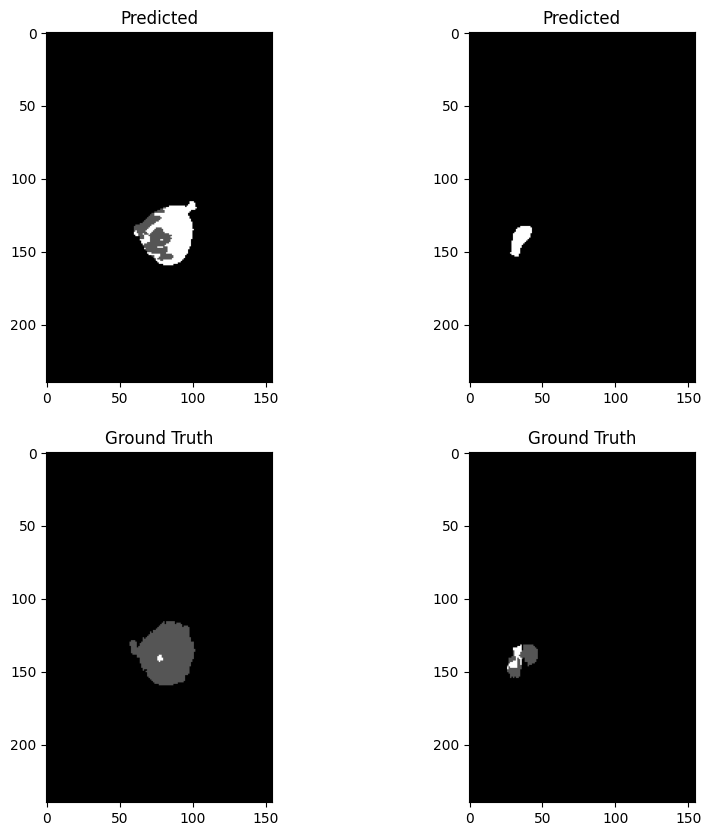

100%|██████████| 202/202 [06:57<00:00,  2.07s/it]



Average Training Loss: 0.030562369715385507

Average Training DSC: [0.99711121 0.52303648 0.78492553 0.5060592 ]
Average Training ASSD: [ 0.30479344 97.2385533  50.17849464 25.65183184]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


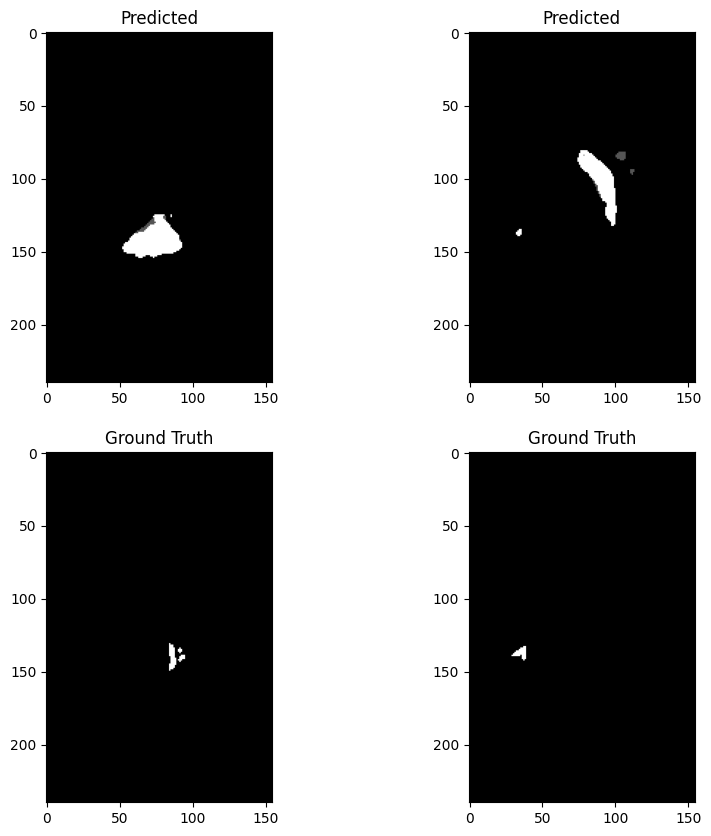

100%|██████████| 51/51 [01:16<00:00,  1.51s/it]


Average Validation Loss: 0.060111345942406094

Average Validation DSC: [0.99429285 0.37474452 0.70940606 0.46429188]
Average Validation ASSD: [ 0.75332529 97.34508603 70.75949532 16.17774676]
Epoch 13/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


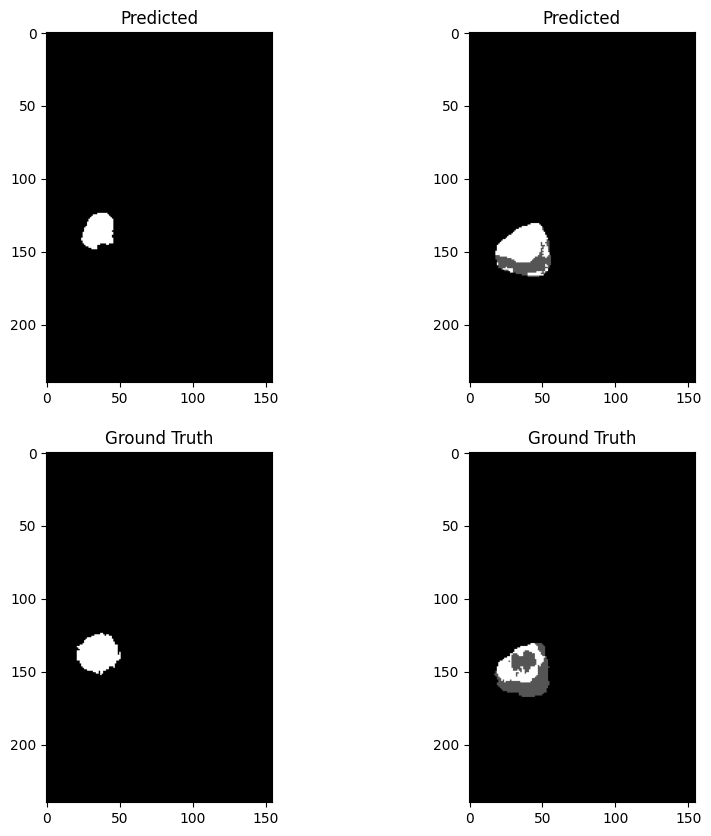

100%|██████████| 202/202 [07:01<00:00,  2.09s/it]



Average Training Loss: 0.028071934578589874

Average Training DSC: [0.9973215  0.58261395 0.79531243 0.52482254]
Average Training ASSD: [ 0.28115293 82.09171154 46.60281369 25.10783876]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


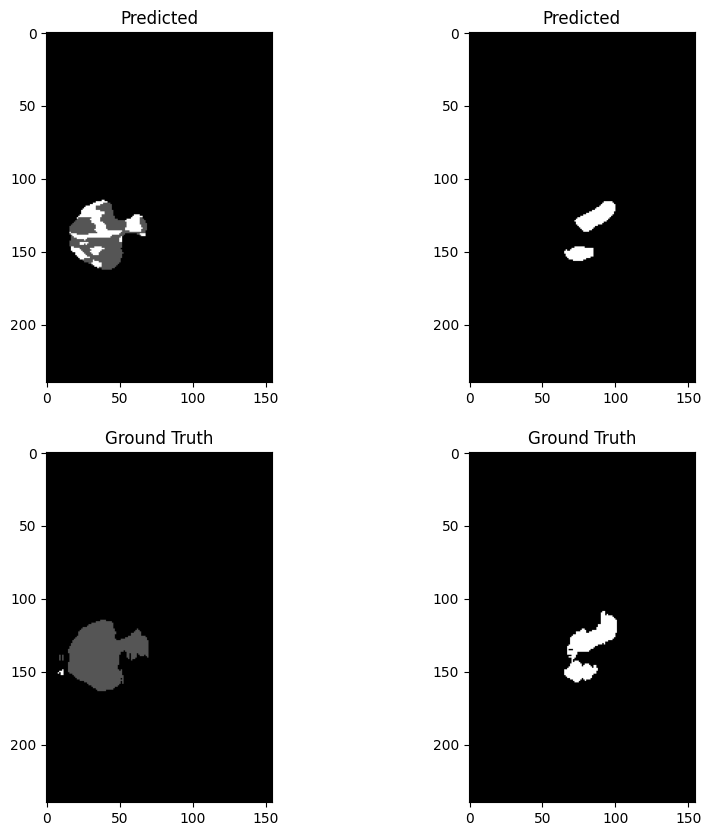

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.031362880569170505

Average Validation DSC: [0.9966687  0.62637124 0.80398498 0.49418577]
Average Validation ASSD: [ 0.40709465 59.31103182 45.18616892 34.6170791 ]
Epoch 14/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


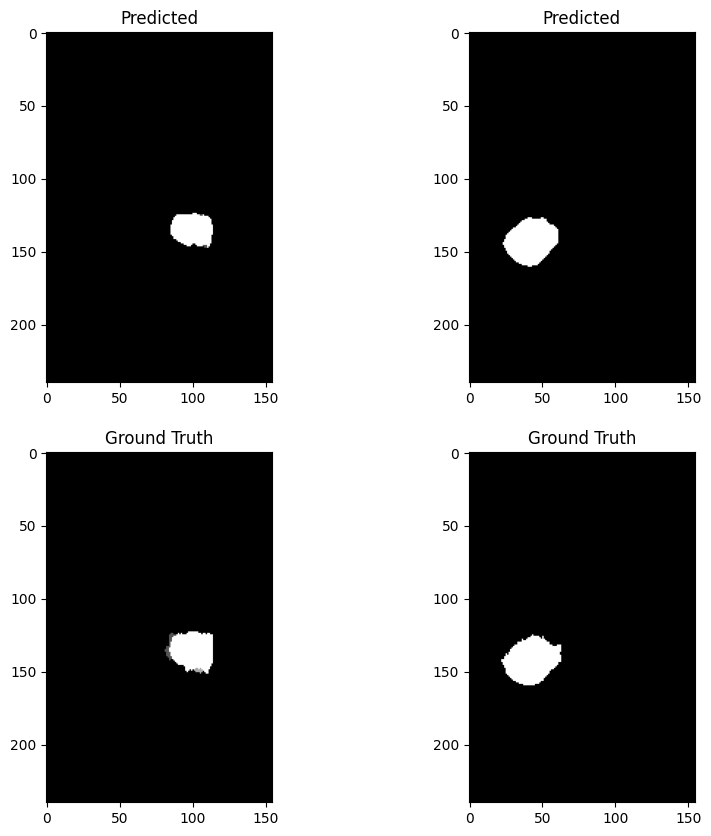

100%|██████████| 202/202 [07:02<00:00,  2.09s/it]



Average Training Loss: 0.025326567439196427

Average Training DSC: [0.99750648 0.62895253 0.81465895 0.55071574]
Average Training ASSD: [ 0.26747278 72.37627539 42.16307209 26.62811886]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


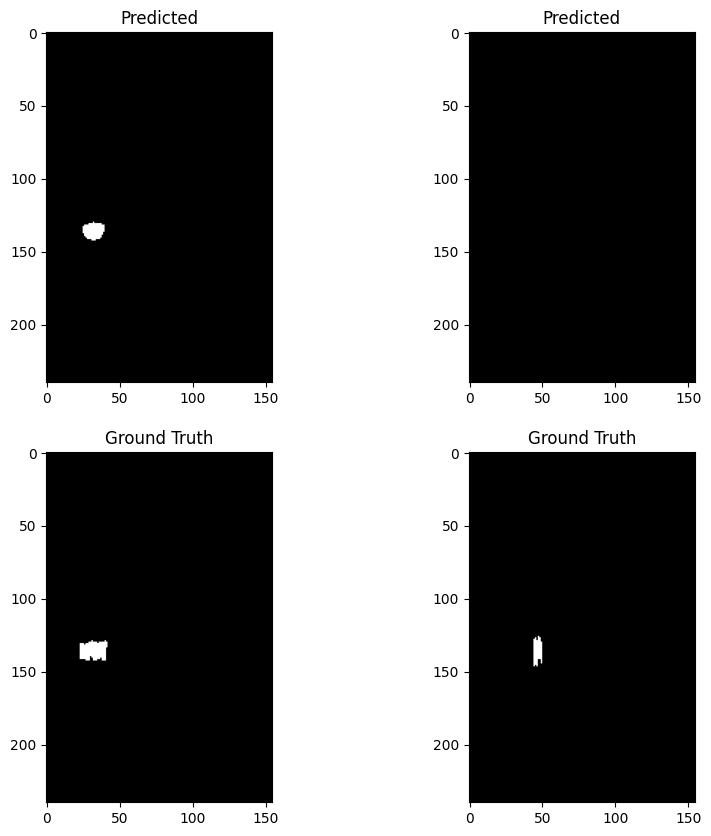

100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Average Validation Loss: 0.028834857594440964

Average Validation DSC: [0.99708991 0.55444326 0.73260162 0.43894021]
Average Validation ASSD: [  0.32578632 105.27816157  66.04527036  51.60288626]
Epoch 15/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


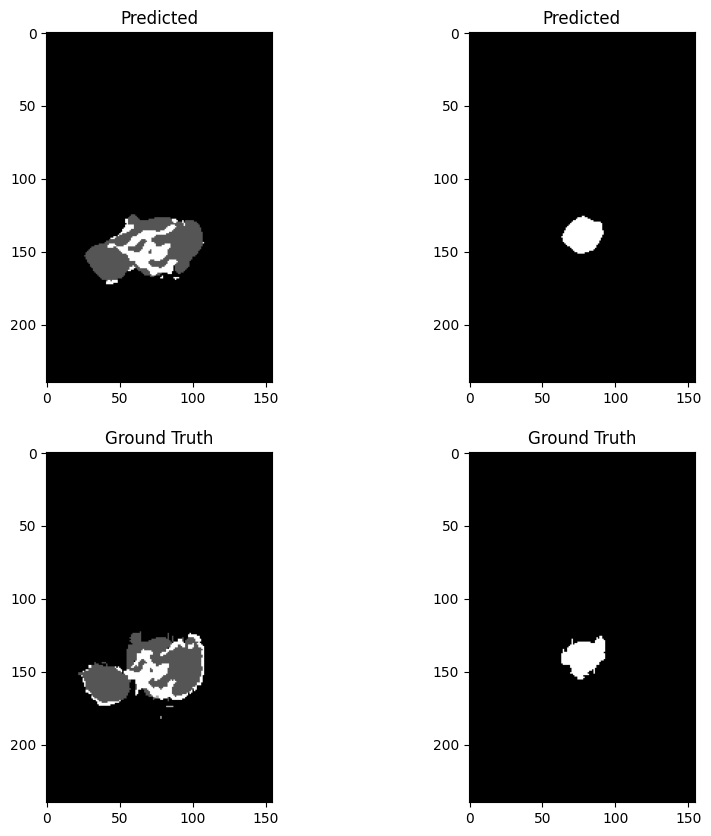

100%|██████████| 202/202 [07:01<00:00,  2.09s/it]



Average Training Loss: 0.02401963339214868

Average Training DSC: [0.99755942 0.64851493 0.82497854 0.56895841]
Average Training ASSD: [ 0.2594084  69.6193404  38.33888339 28.97015004]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


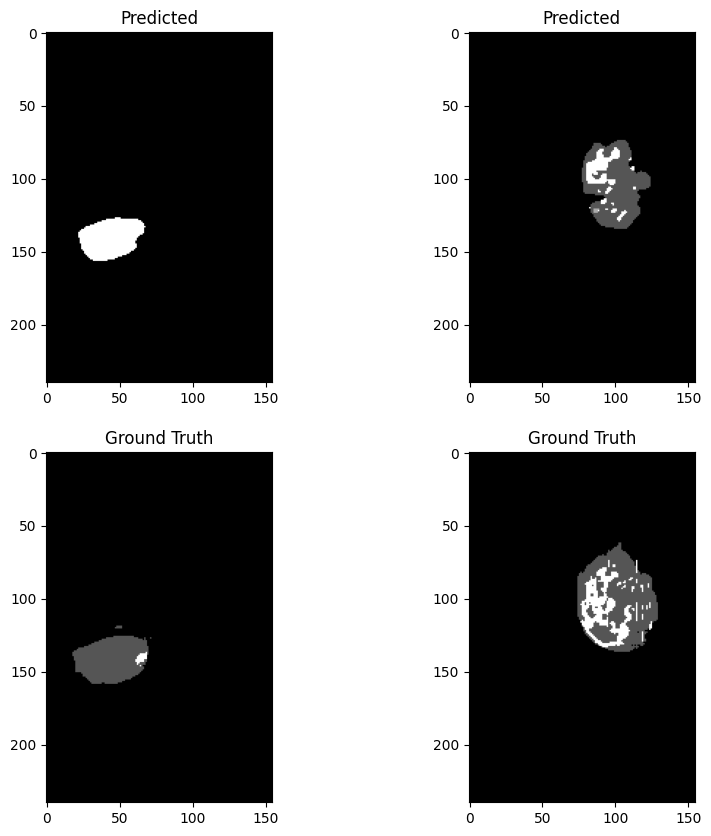

100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Average Validation Loss: 0.06186329105905458

Average Validation DSC: [0.99308509 0.48322904 0.70153467 0.2789722 ]
Average Validation ASSD: [  0.87591255 110.77745131  60.7541693  105.10372647]
Epoch 16/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


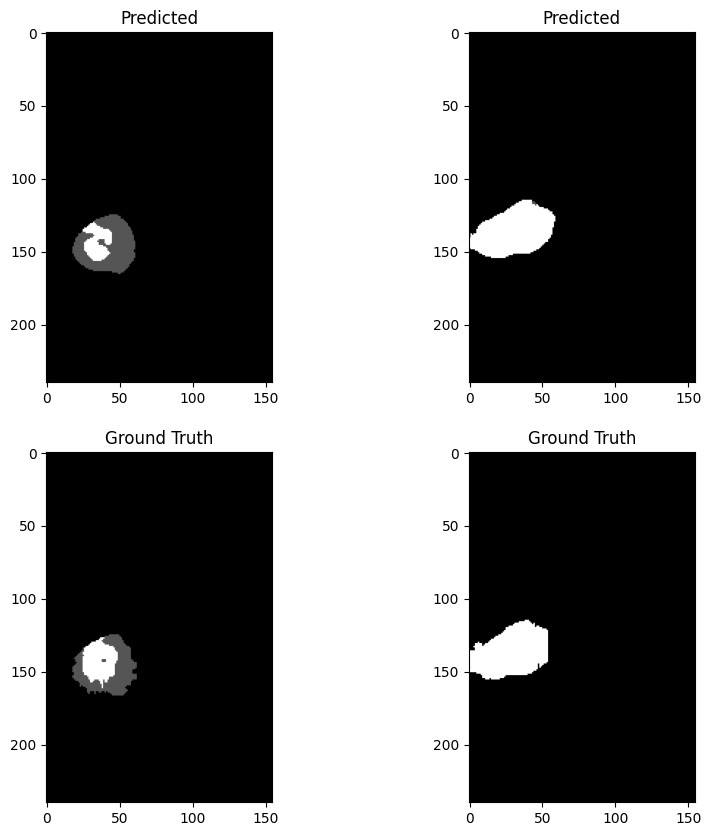

100%|██████████| 202/202 [07:08<00:00,  2.12s/it]



Average Training Loss: 0.022189447149117983

Average Training DSC: [0.99768066 0.69884253 0.83803786 0.59078343]
Average Training ASSD: [ 0.24247209 55.55965265 35.15847546 28.44241477]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


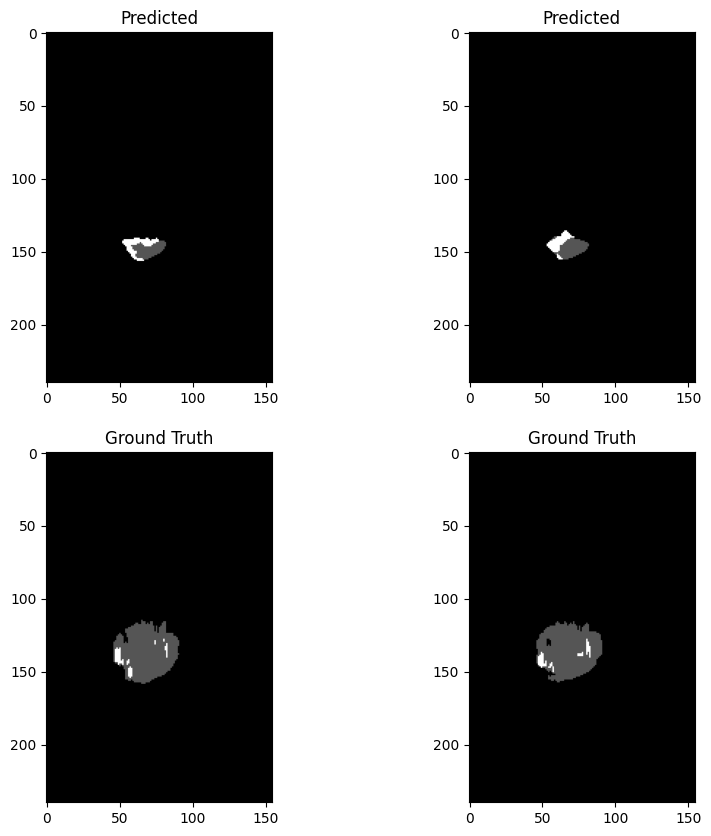

100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Average Validation Loss: 0.09308262110925188

Average Validation DSC: [0.99052033 0.47969317 0.75562383 0.2531092 ]
Average Validation ASSD: [  1.36312886 106.5806266   55.88280624 126.18590668]
Epoch 17/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


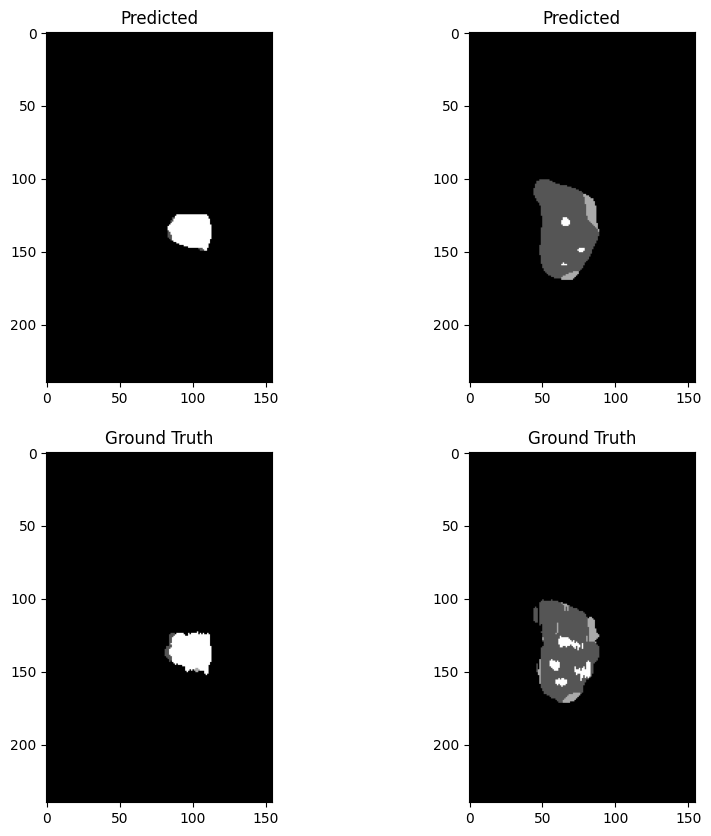

100%|██████████| 202/202 [07:00<00:00,  2.08s/it]



Average Training Loss: 0.020467768999572734

Average Training DSC: [0.99782398 0.72397946 0.84735697 0.61152634]
Average Training ASSD: [ 0.22476339 51.06627374 32.3486418  28.40388965]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


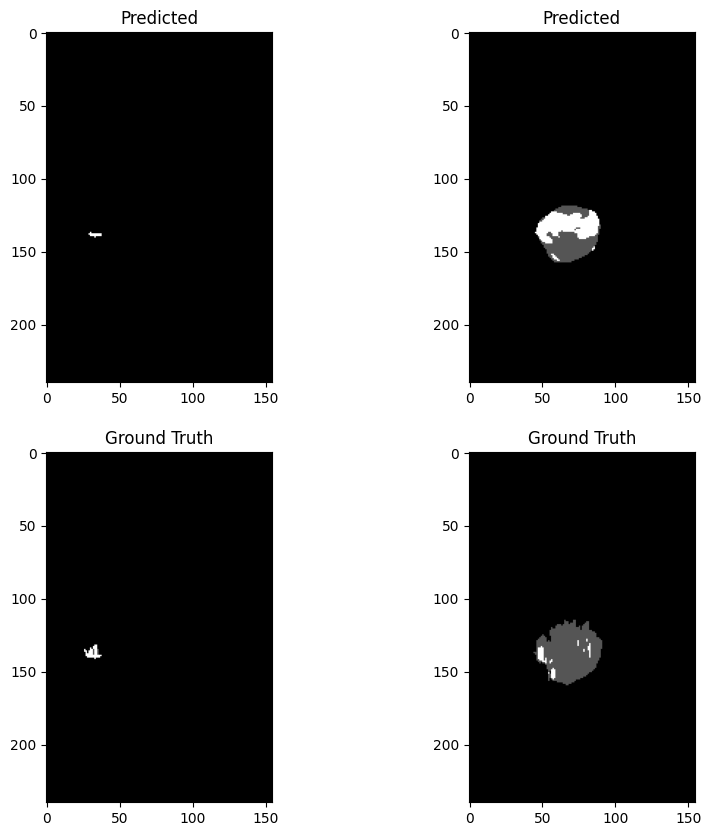

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.02764269669412398

Average Validation DSC: [0.99697288 0.67603077 0.81877706 0.59619891]
Average Validation ASSD: [ 0.40828946 56.38139646 39.54195793 11.58231913]
Epoch 18/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


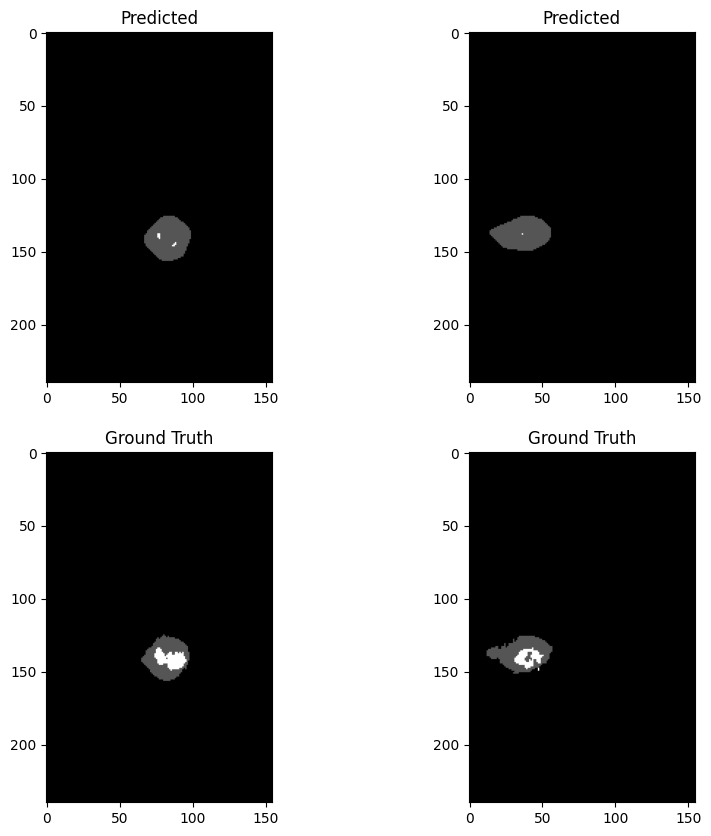

100%|██████████| 202/202 [06:58<00:00,  2.07s/it]



Average Training Loss: 0.019103001508087216

Average Training DSC: [0.99794038 0.74452493 0.86007495 0.62519497]
Average Training ASSD: [ 0.20863827 46.44976479 29.90399767 29.78659743]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


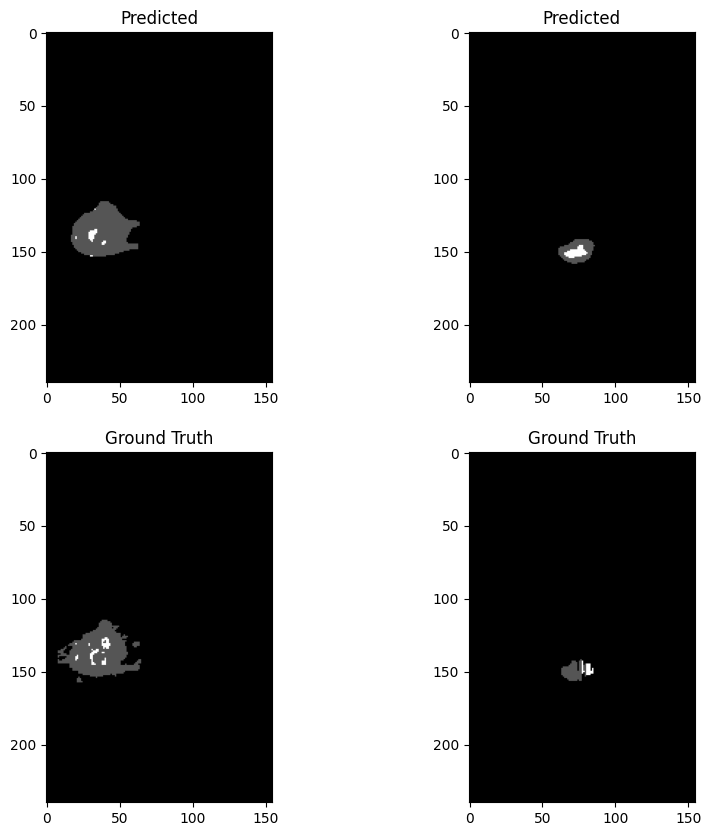

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.026426179261476387

Average Validation DSC: [0.99695384 0.70626328 0.83472086 0.54790242]
Average Validation ASSD: [ 0.32143638 51.37020728 34.92073017 36.32633694]
Epoch 19/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


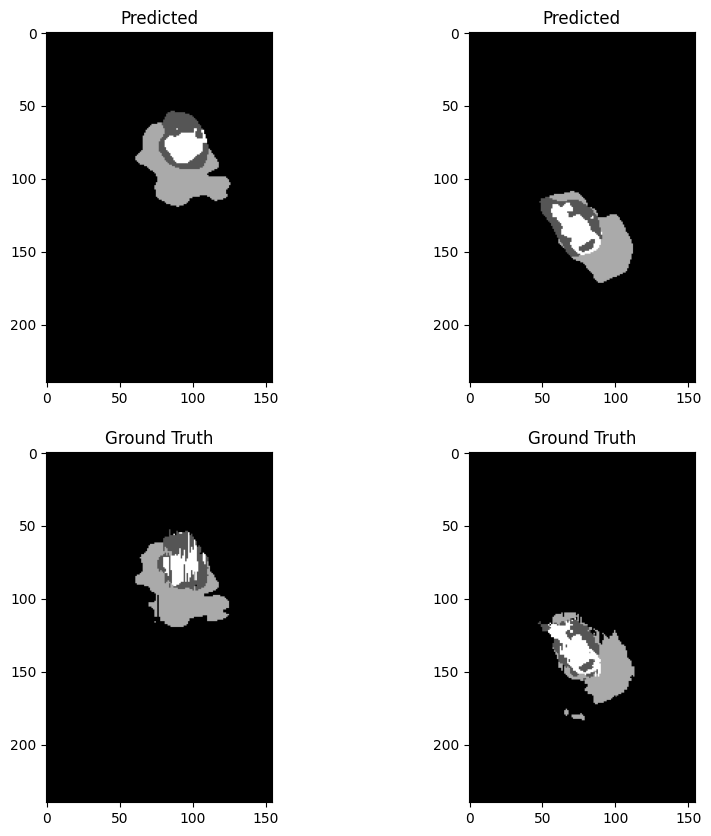

100%|██████████| 202/202 [07:03<00:00,  2.10s/it]



Average Training Loss: 0.017344784235932154

Average Training DSC: [0.99809388 0.77106242 0.87186904 0.64609561]
Average Training ASSD: [ 0.19252817 40.116799   25.9763183  32.0824626 ]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


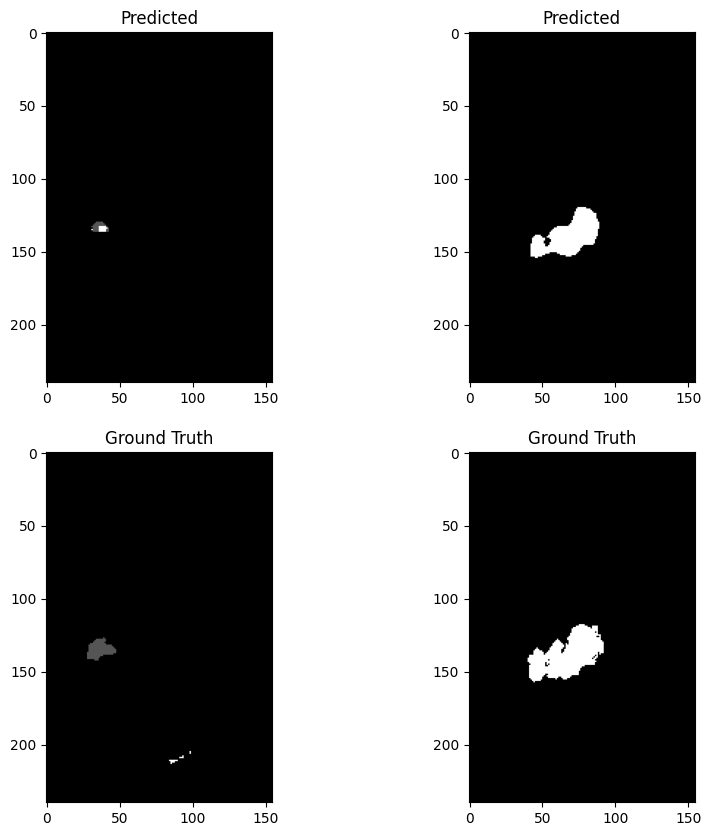

100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Average Validation Loss: 0.031158304755009858

Average Validation DSC: [0.99621869 0.65135452 0.83934549 0.47364824]
Average Validation ASSD: [ 0.43537655 69.95737469 31.99054159 64.0824454 ]
Epoch 20/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


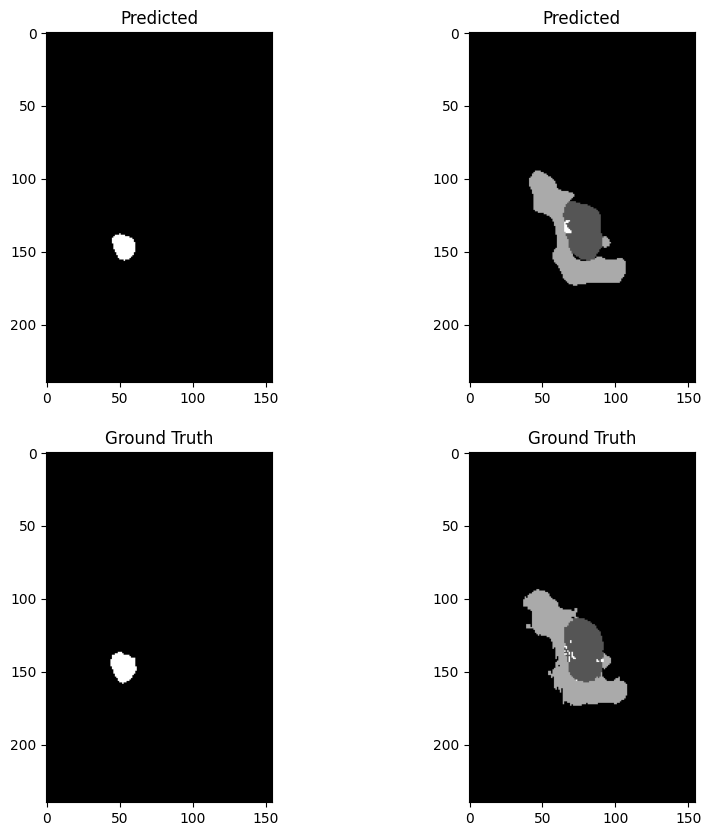

100%|██████████| 202/202 [07:11<00:00,  2.13s/it]



Average Training Loss: 0.01627925424928786

Average Training DSC: [0.99819748 0.78659273 0.87532641 0.66037022]
Average Training ASSD: [ 0.18170434 37.14018382 25.44296281 29.1389593 ]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


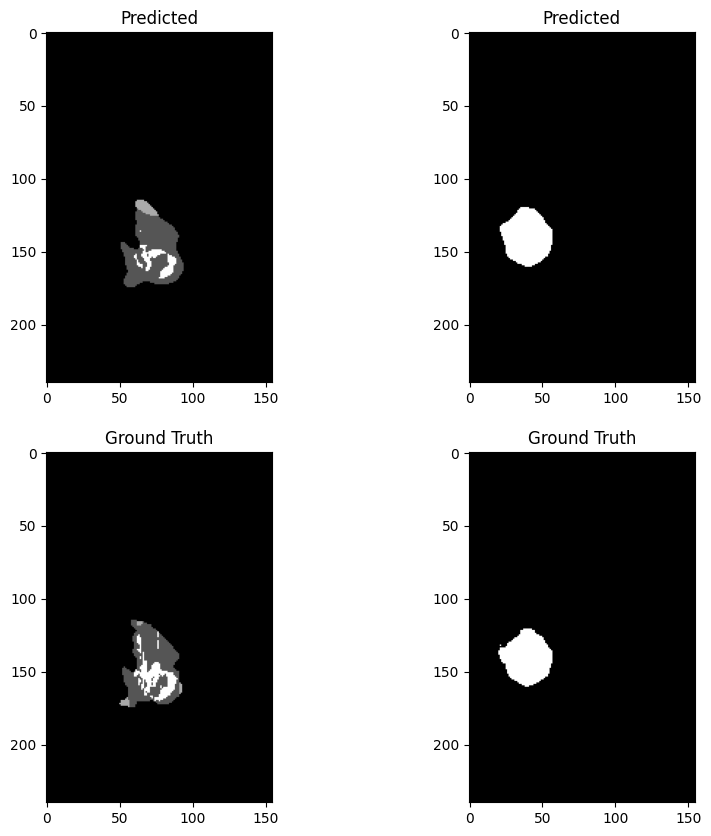

100%|██████████| 51/51 [01:15<00:00,  1.47s/it]


Average Validation Loss: 0.02313468800675051

Average Validation DSC: [0.99781074 0.67118297 0.82568717 0.54533586]
Average Validation ASSD: [ 0.22106172 72.81255529 40.23075061 41.08873309]
Epoch 21/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


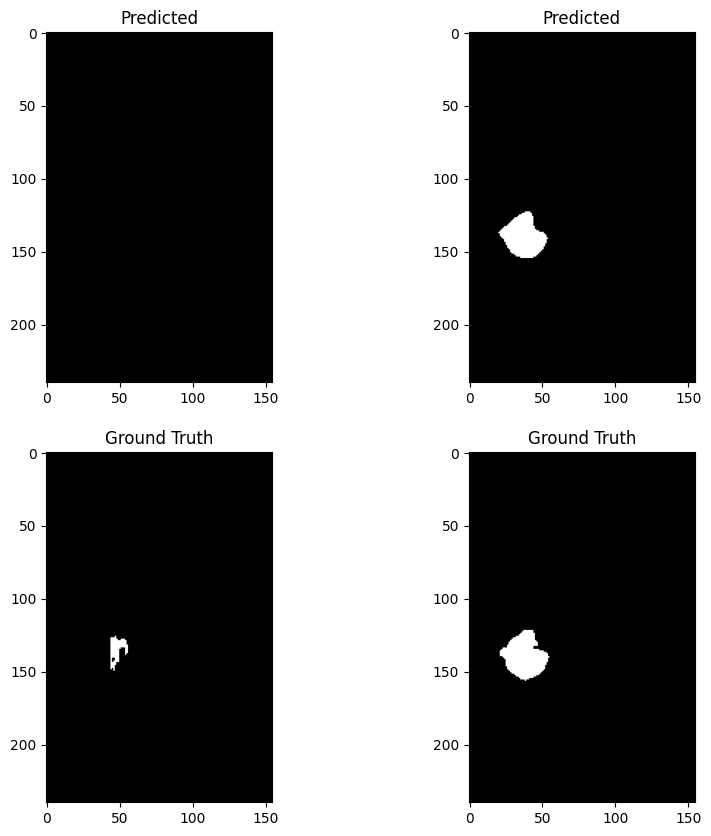

100%|██████████| 202/202 [07:20<00:00,  2.18s/it]



Average Training Loss: 0.015291793327225318

Average Training DSC: [0.99829193 0.80748334 0.88543504 0.66963498]
Average Training ASSD: [ 0.1675387  31.87228785 22.1827807  30.17090138]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


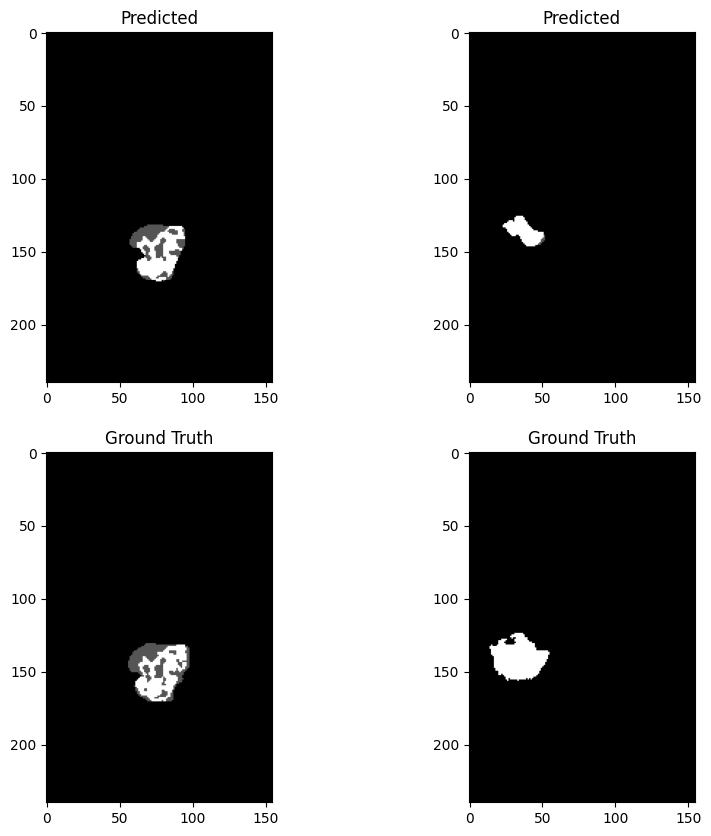

100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Average Validation Loss: 0.03415492144139374

Average Validation DSC: [0.99560646 0.7250183  0.84844581 0.5135464 ]
Average Validation ASSD: [ 0.49452609 37.89564831 29.50073962 56.61782182]
Epoch 22/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


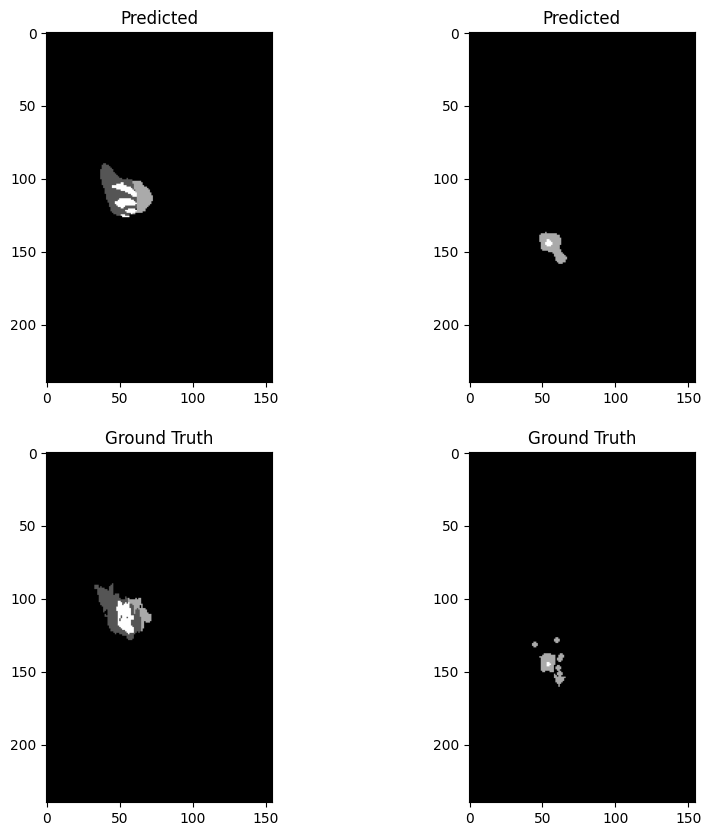

100%|██████████| 202/202 [08:05<00:00,  2.40s/it]



Average Training Loss: 0.014479012408358331

Average Training DSC: [0.9983947  0.81395123 0.89207224 0.68311053]
Average Training ASSD: [ 0.16009742 30.66920088 20.18902429 28.81466157]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


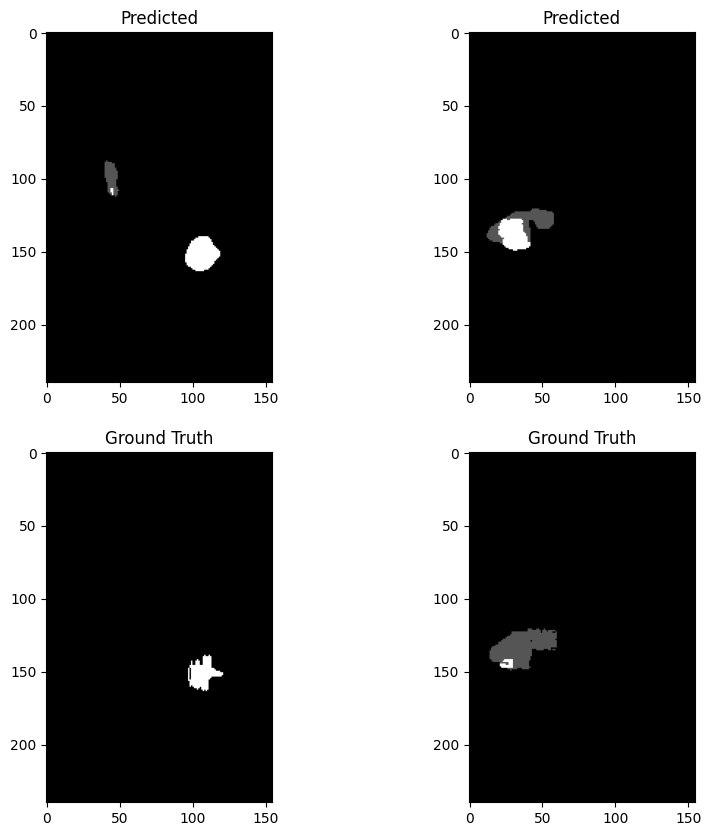

100%|██████████| 51/51 [01:26<00:00,  1.69s/it]


Average Validation Loss: 0.025623263718158592

Average Validation DSC: [0.99746119 0.64213468 0.73251689 0.6277573 ]
Average Validation ASSD: [ 0.47056835 63.07922173 67.14459024  9.57321966]
Epoch 23/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


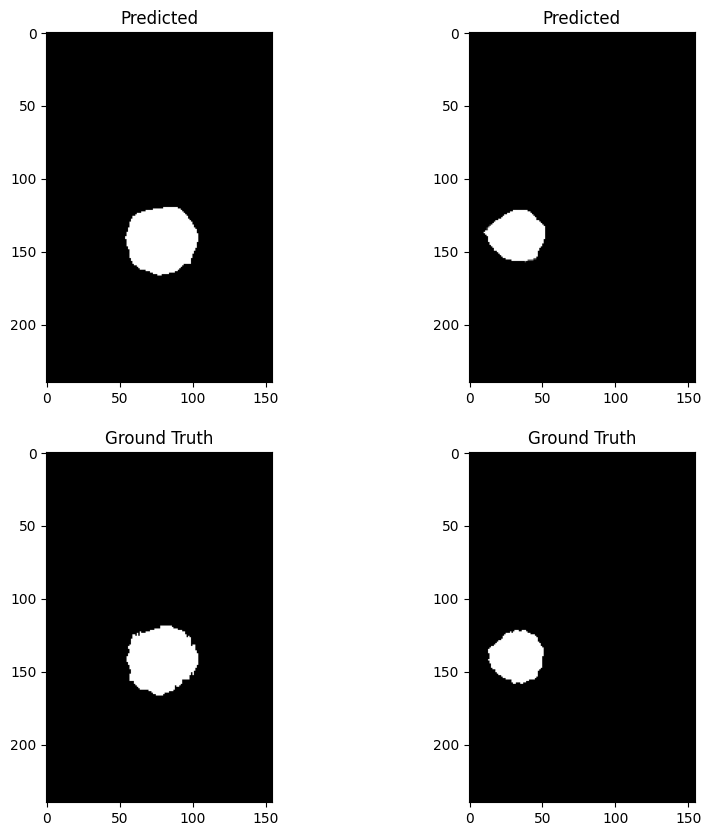

100%|██████████| 202/202 [07:57<00:00,  2.36s/it]



Average Training Loss: 0.014526586716828665

Average Training DSC: [0.99838936 0.82293078 0.88895621 0.68560675]
Average Training ASSD: [ 0.15933358 28.31304372 21.46867566 28.51153237]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


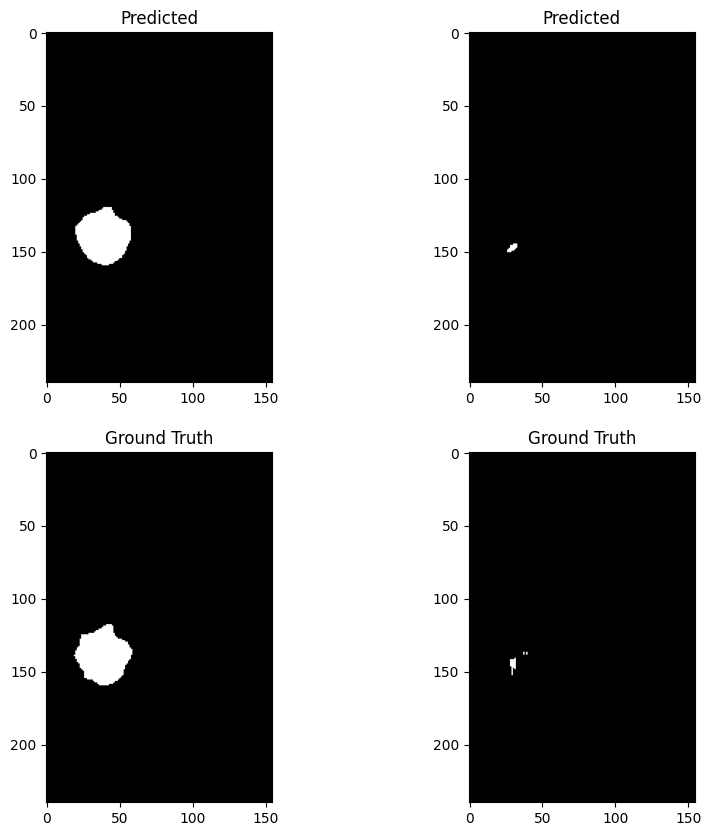

100%|██████████| 51/51 [01:25<00:00,  1.67s/it]


Average Validation Loss: 0.01828794051692182

Average Validation DSC: [0.99823615 0.78613693 0.8851555  0.67982386]
Average Validation ASSD: [ 0.18439168 26.61953624 21.49723552 16.49899579]
Epoch 24/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


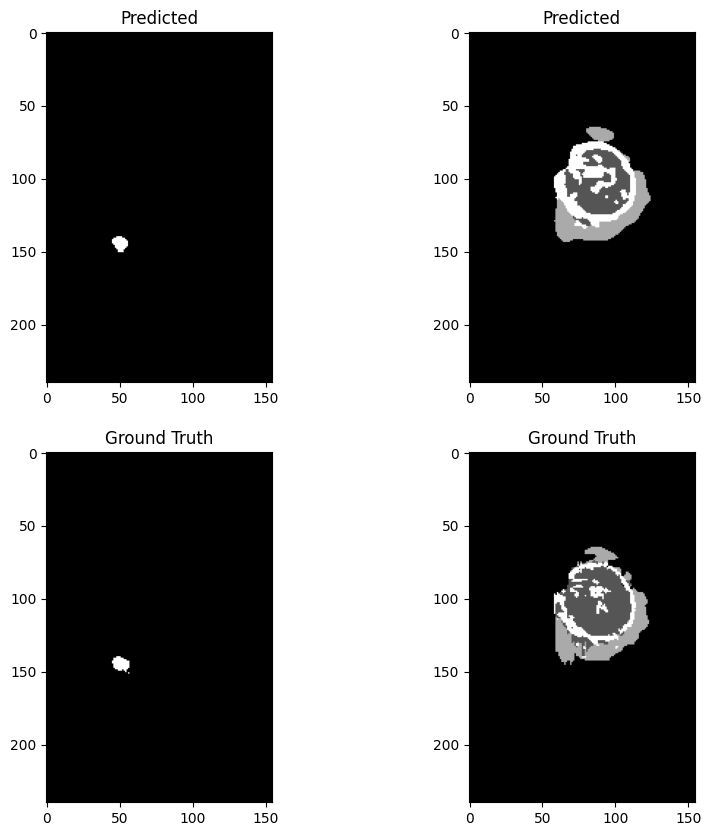

100%|██████████| 202/202 [07:29<00:00,  2.22s/it]



Average Training Loss: 0.013627342335732267

Average Training DSC: [0.99846642 0.82841098 0.8973693  0.6969309 ]
Average Training ASSD: [ 0.15054475 28.35206915 18.64889014 29.0928949 ]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


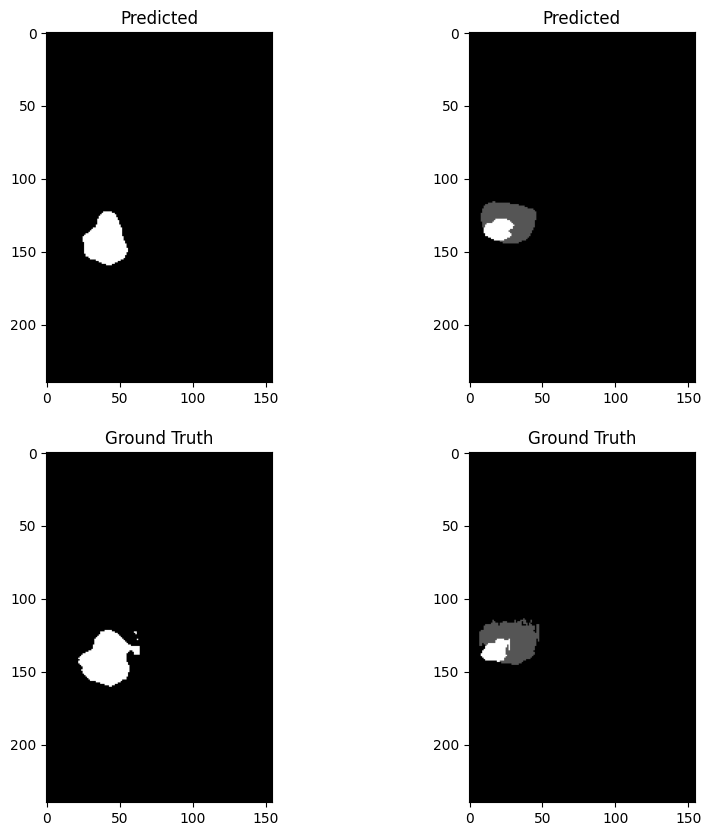

100%|██████████| 51/51 [01:26<00:00,  1.70s/it]


Average Validation Loss: 0.02912818267941475

Average Validation DSC: [0.99658816 0.75117042 0.86705638 0.59629603]
Average Validation ASSD: [ 0.36981747 27.43193211 25.41782472 32.9621603 ]
Epoch 25/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


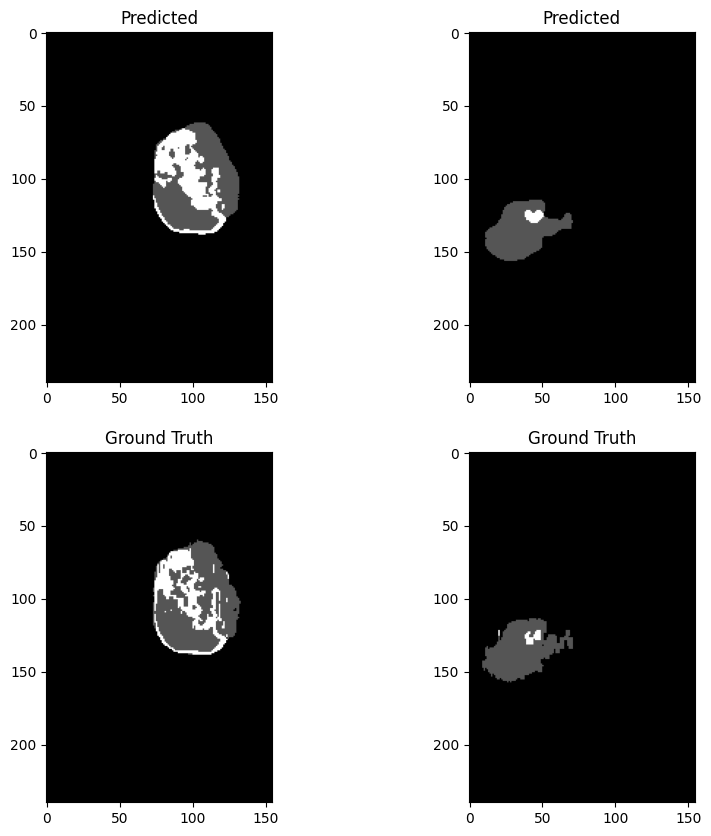

100%|██████████| 202/202 [07:28<00:00,  2.22s/it]



Average Training Loss: 0.012999770618827627

Average Training DSC: [0.99850348 0.84209077 0.90293421 0.70807736]
Average Training ASSD: [ 0.14579168 24.74391183 17.3212833  27.77751378]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


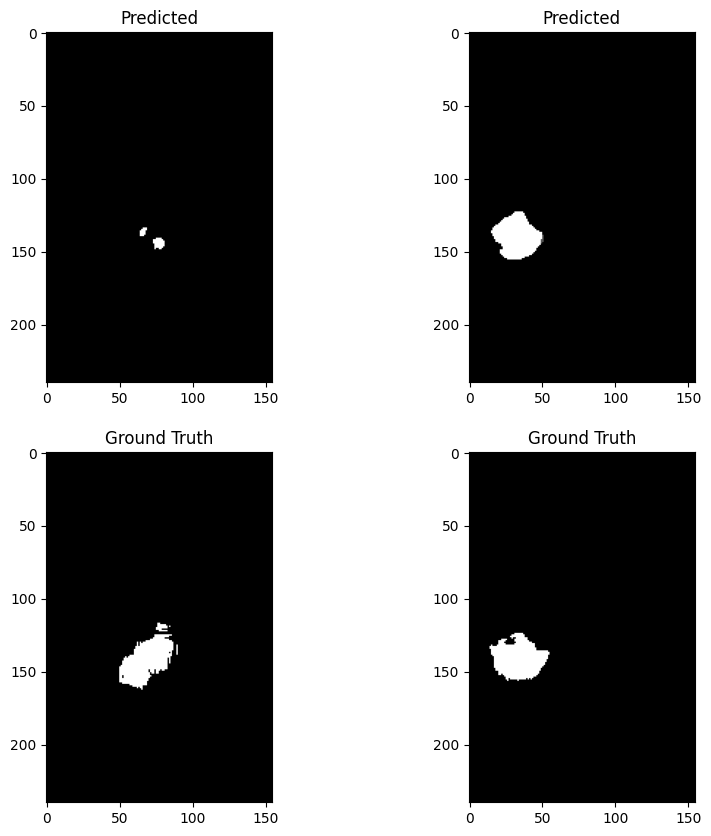

100%|██████████| 51/51 [01:18<00:00,  1.53s/it]


Average Validation Loss: 0.023150496221348352

Average Validation DSC: [0.99734855 0.78115875 0.85426555 0.62686179]
Average Validation ASSD: [ 0.29034814 34.61620472 28.60021455 35.60798452]
Epoch 26/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


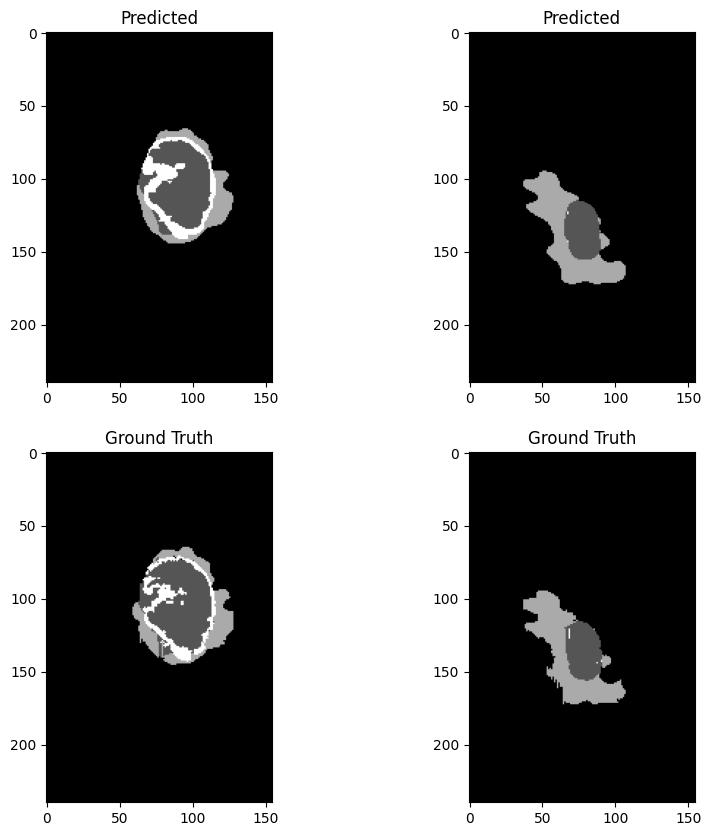

100%|██████████| 202/202 [07:34<00:00,  2.25s/it]



Average Training Loss: 0.012793016004477544

Average Training DSC: [0.99855722 0.84546001 0.90287989 0.71230983]
Average Training ASSD: [ 0.14093629 23.10236638 17.75053256 27.01824203]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


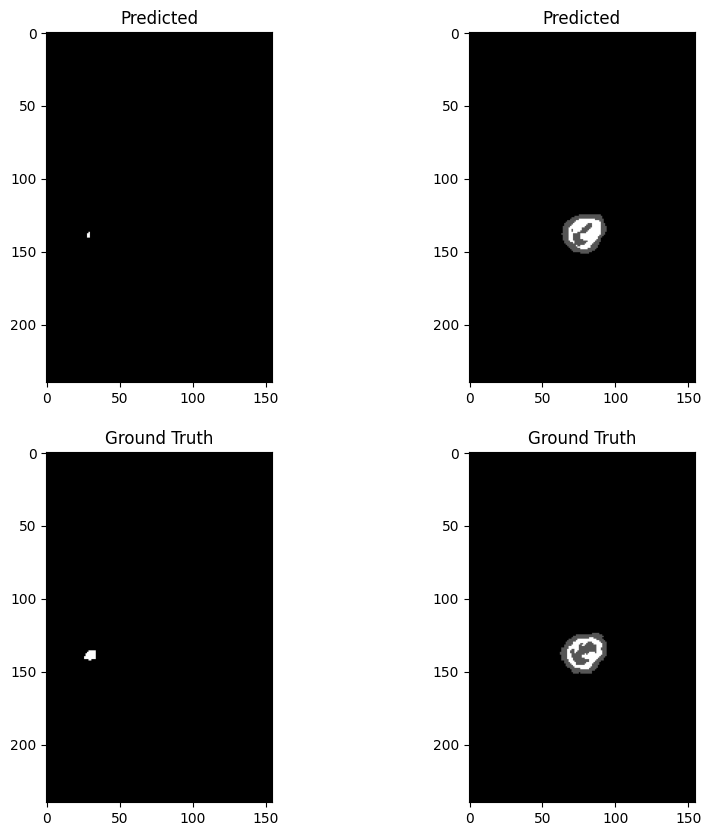

100%|██████████| 51/51 [01:18<00:00,  1.53s/it]


Average Validation Loss: 0.015401388737646973

Average Validation DSC: [0.99819621 0.82640836 0.88773225 0.68244659]
Average Validation ASSD: [ 0.19245583 26.98650404 21.14545089 33.9724892 ]
Epoch 27/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


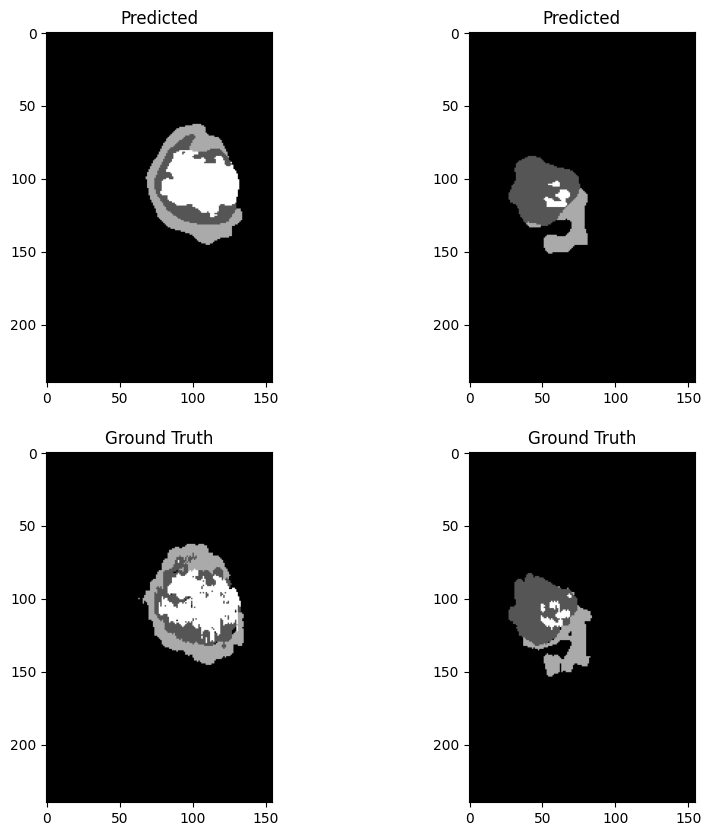

100%|██████████| 202/202 [07:18<00:00,  2.17s/it]



Average Training Loss: 0.012286597208147593

Average Training DSC: [0.99860317 0.8559686  0.90746475 0.71875382]
Average Training ASSD: [ 0.13665363 21.35547885 16.68714103 28.36979517]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


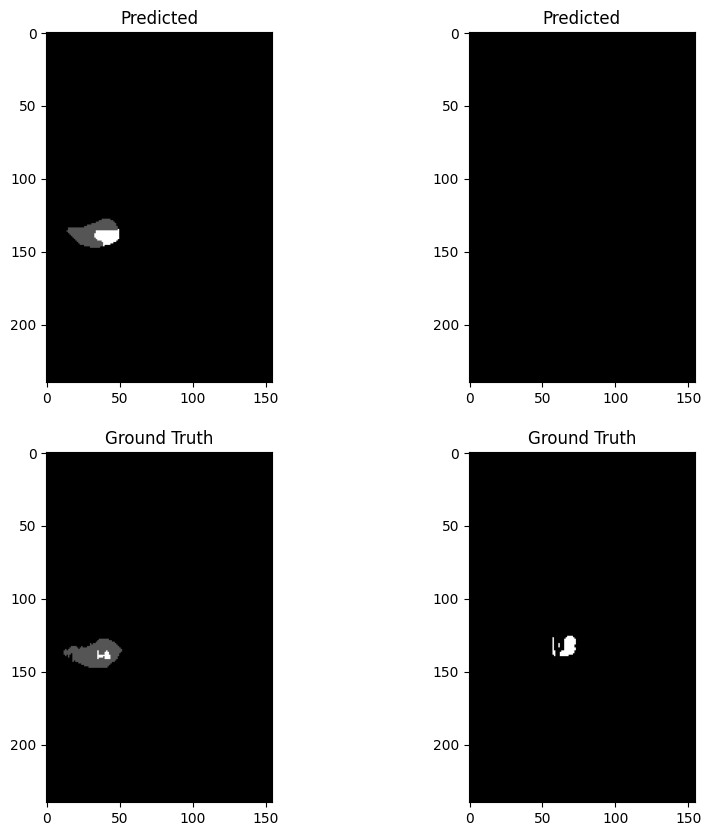

100%|██████████| 51/51 [01:19<00:00,  1.55s/it]


Average Validation Loss: 0.01930999281067474

Average Validation DSC: [0.99782884 0.78392341 0.86597917 0.65691038]
Average Validation ASSD: [ 0.23700385 34.8311939  23.92790013 27.34366478]
Epoch 28/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


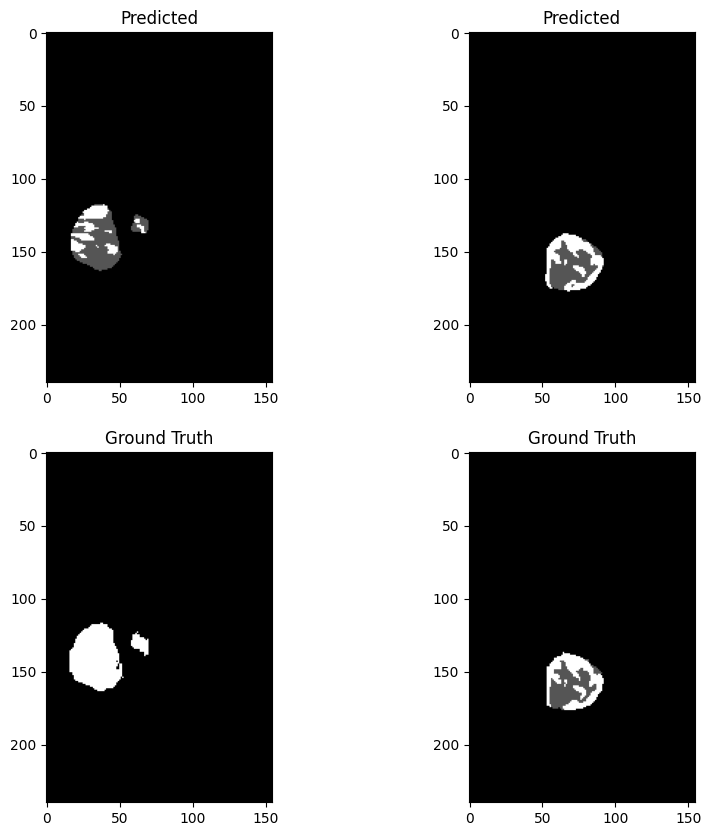

100%|██████████| 202/202 [07:18<00:00,  2.17s/it]



Average Training Loss: 0.01166753051802516

Average Training DSC: [0.99863972 0.86274018 0.90920361 0.72699398]
Average Training ASSD: [ 0.13123578 19.8181927  15.63789656 27.02880145]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


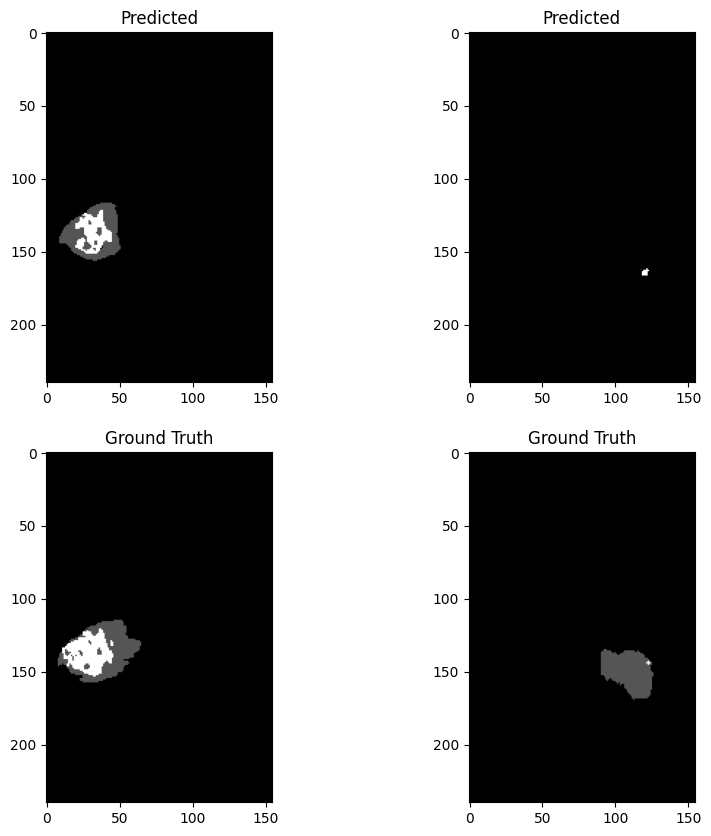

100%|██████████| 51/51 [01:18<00:00,  1.54s/it]


Average Validation Loss: 0.03894862021301307

Average Validation DSC: [0.99514505 0.69145838 0.83354359 0.57673053]
Average Validation ASSD: [ 0.48367329 48.02581334 33.77686469 29.37321564]
Epoch 29/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


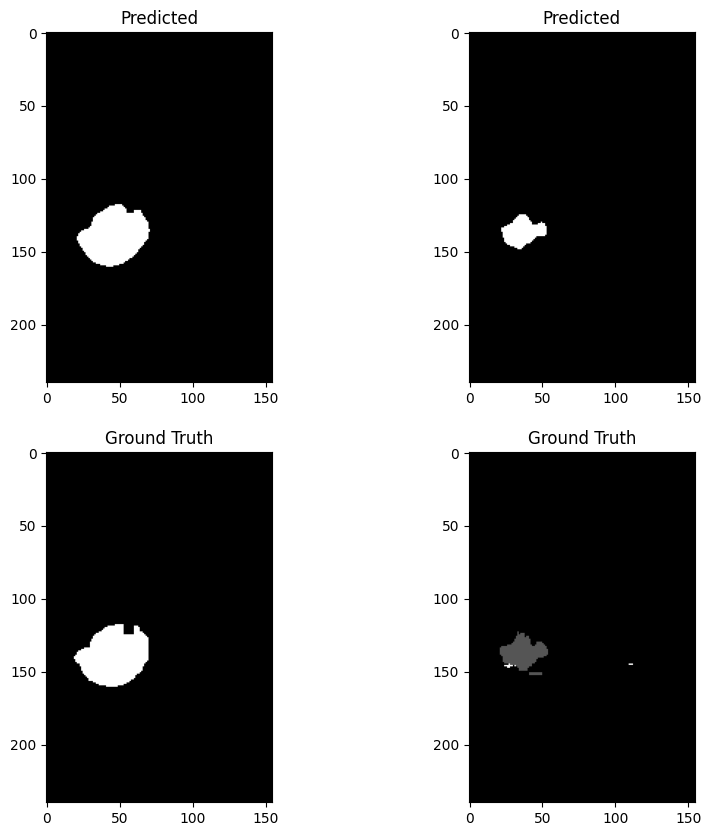

100%|██████████| 202/202 [07:17<00:00,  2.17s/it]



Average Training Loss: 0.01142903073866031

Average Training DSC: [0.99869221 0.86433365 0.91290637 0.73228703]
Average Training ASSD: [ 0.12700564 19.9472269  14.45662597 27.28913506]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


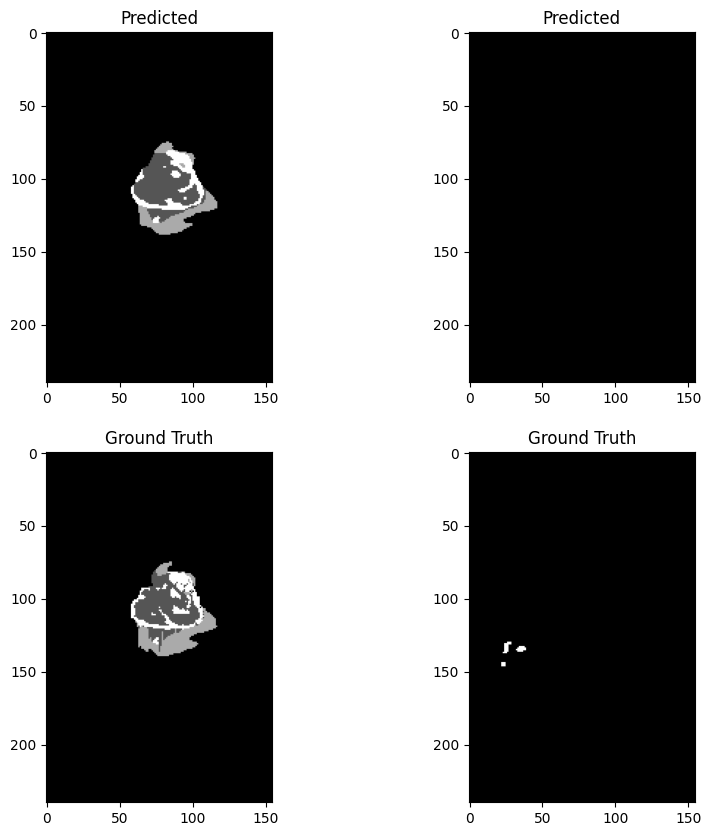

100%|██████████| 51/51 [01:32<00:00,  1.81s/it]


Average Validation Loss: 0.015160784910560823

Average Validation DSC: [0.9983455  0.81807338 0.8878405  0.7073433 ]
Average Validation ASSD: [ 0.18041131 29.02088825 20.85440038 21.29653683]
Epoch 30/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


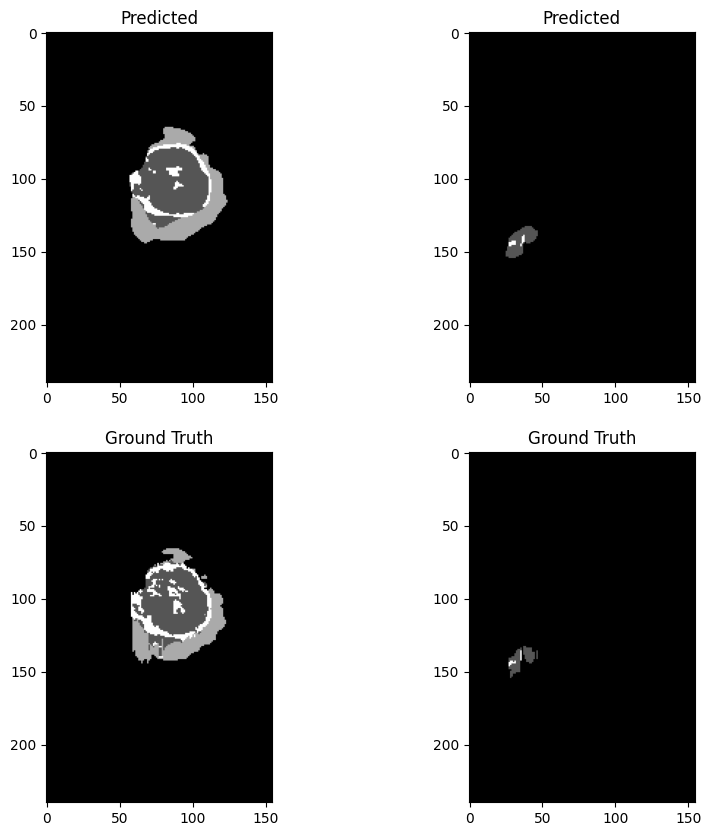

100%|██████████| 202/202 [07:17<00:00,  2.17s/it]



Average Training Loss: 0.011113640368169192

Average Training DSC: [0.99871594 0.86536737 0.9143012  0.73692813]
Average Training ASSD: [ 0.12730382 20.10490261 15.29482048 26.22756141]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


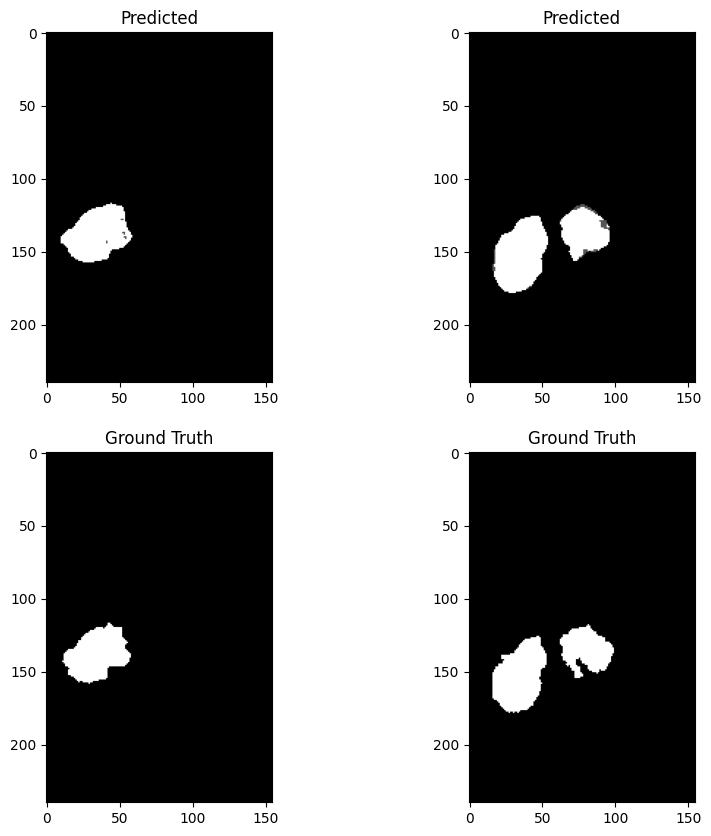

100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Average Validation Loss: 0.02750788216351294

Average Validation DSC: [0.99682134 0.66527313 0.71738391 0.63660488]
Average Validation ASSD: [ 0.65578517 63.25502957 75.94987077  6.91521206]
Epoch 31/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


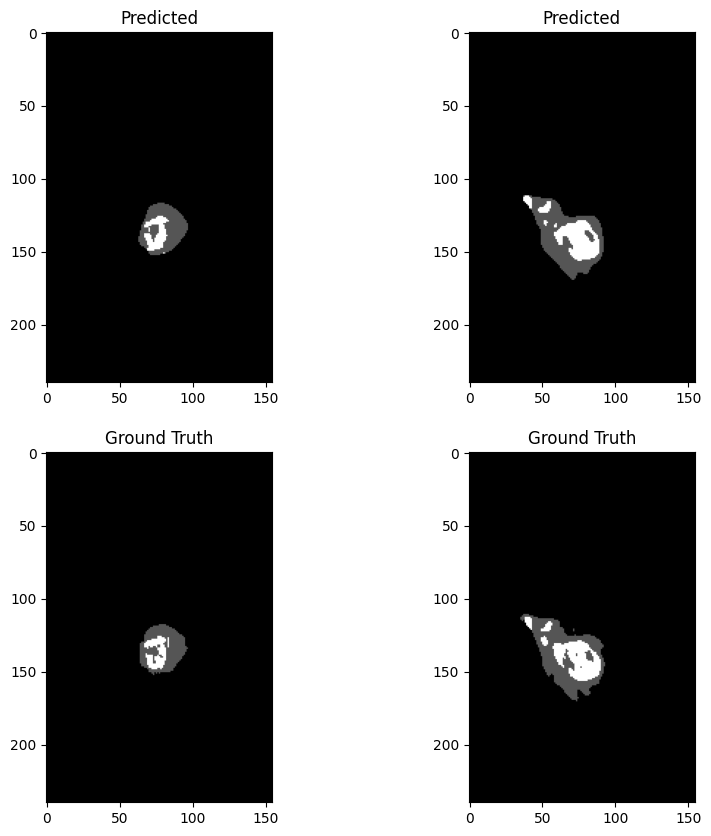

100%|██████████| 202/202 [07:16<00:00,  2.16s/it]



Average Training Loss: 0.011190265961138918

Average Training DSC: [0.99871955 0.87024522 0.90998573 0.73818529]
Average Training ASSD: [ 0.12358044 18.60133028 16.08126835 25.66679791]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


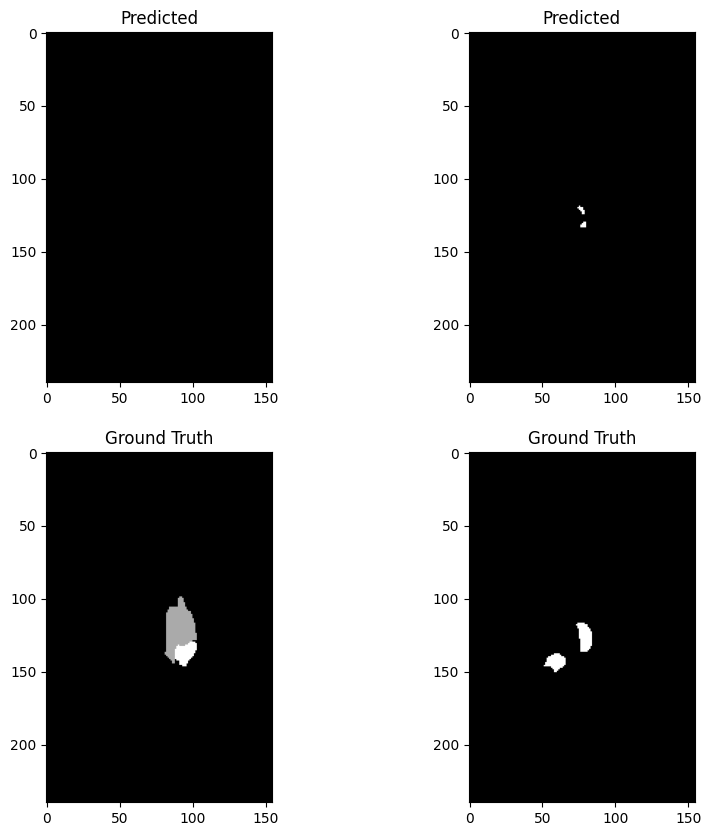

100%|██████████| 51/51 [01:20<00:00,  1.58s/it]


Average Validation Loss: 0.05471816125745867

Average Validation DSC: [0.99483478 0.58507055 0.79227581 0.5281162 ]
Average Validation ASSD: [ 0.52733513 82.05455468 38.51138325 36.6594867 ]
Epoch 32/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


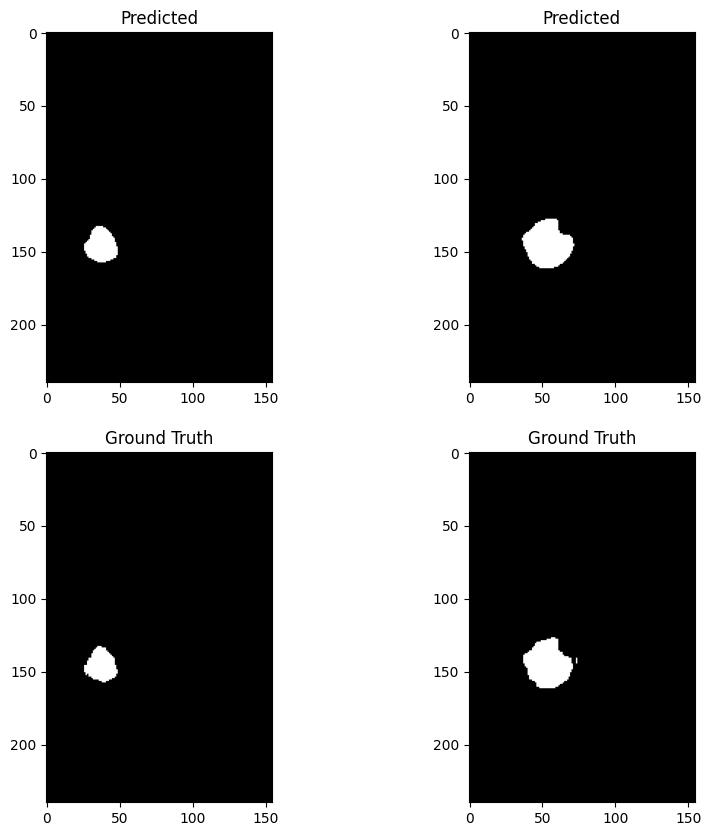

100%|██████████| 202/202 [07:16<00:00,  2.16s/it]



Average Training Loss: 0.010797286763473754

Average Training DSC: [0.99872132 0.87053364 0.914077   0.74640039]
Average Training ASSD: [ 0.12490395 18.96901984 15.01193762 24.64974465]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


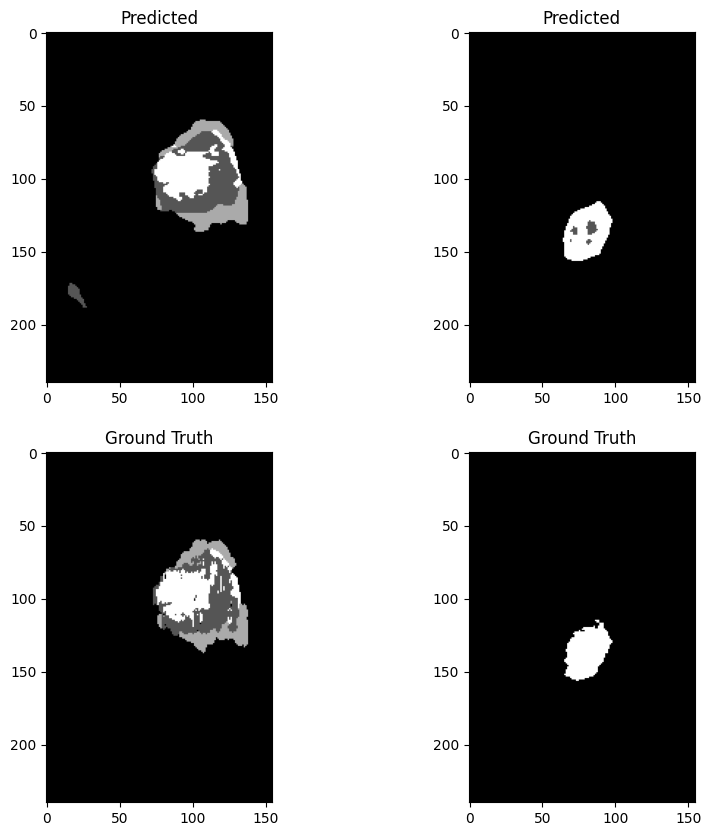

100%|██████████| 51/51 [01:14<00:00,  1.46s/it]


Average Validation Loss: 0.01862294382105271

Average Validation DSC: [0.99788826 0.7268853  0.87537961 0.66788948]
Average Validation ASSD: [ 0.23901846 61.38037157 25.50309657 14.4044985 ]
Epoch 33/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


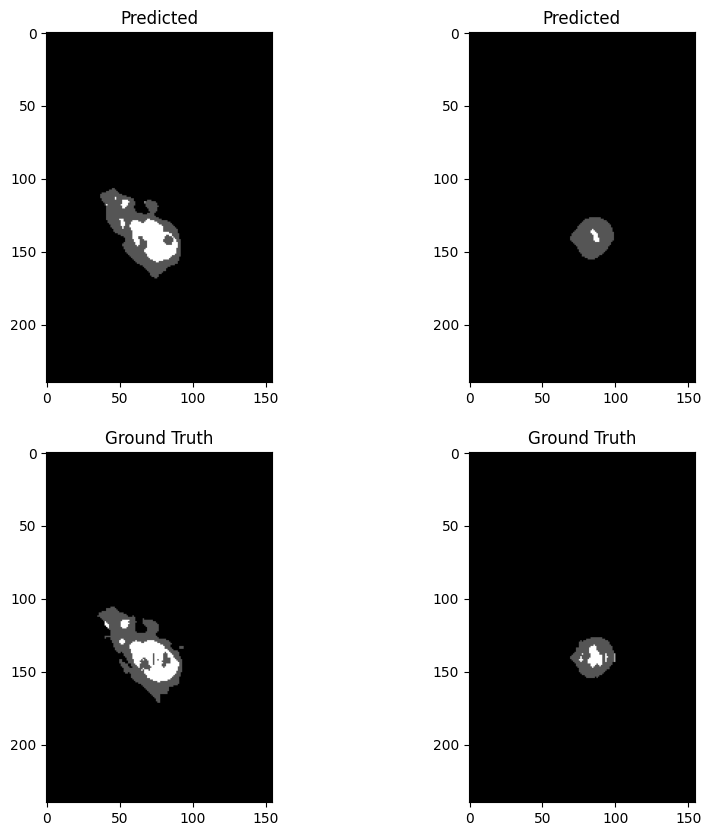

100%|██████████| 202/202 [07:16<00:00,  2.16s/it]



Average Training Loss: 0.009998110835302141

Average Training DSC: [0.99881116 0.88566906 0.92169448 0.75350988]
Average Training ASSD: [ 0.11385102 15.26823951 13.0433352  25.19020205]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


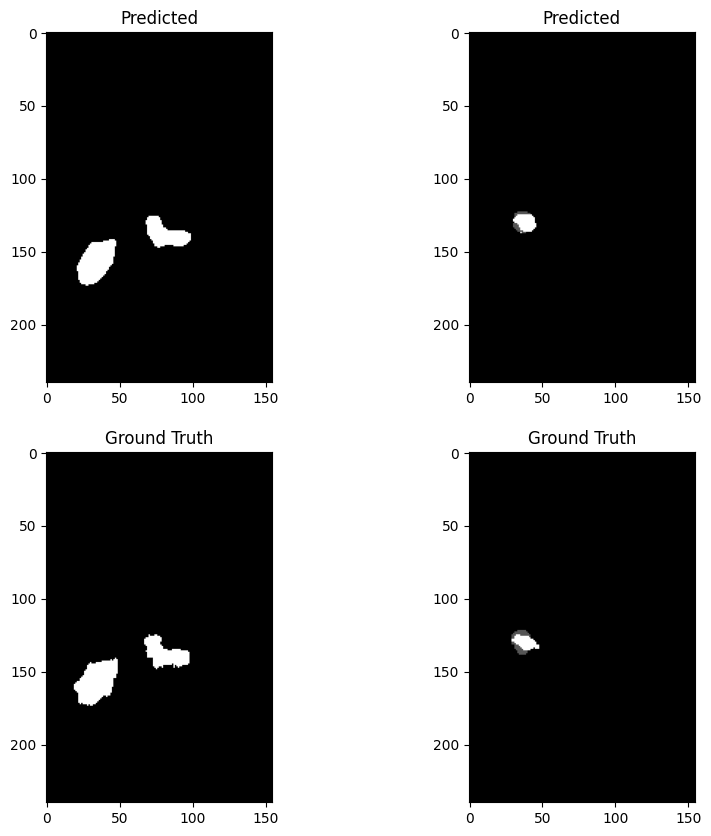

100%|██████████| 51/51 [01:15<00:00,  1.49s/it]


Average Validation Loss: 0.013934823328300434

Average Validation DSC: [0.99853938 0.84108404 0.90766118 0.72735513]
Average Validation ASSD: [ 0.1519948  23.36486449 17.75611885 18.33926742]
Epoch 34/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


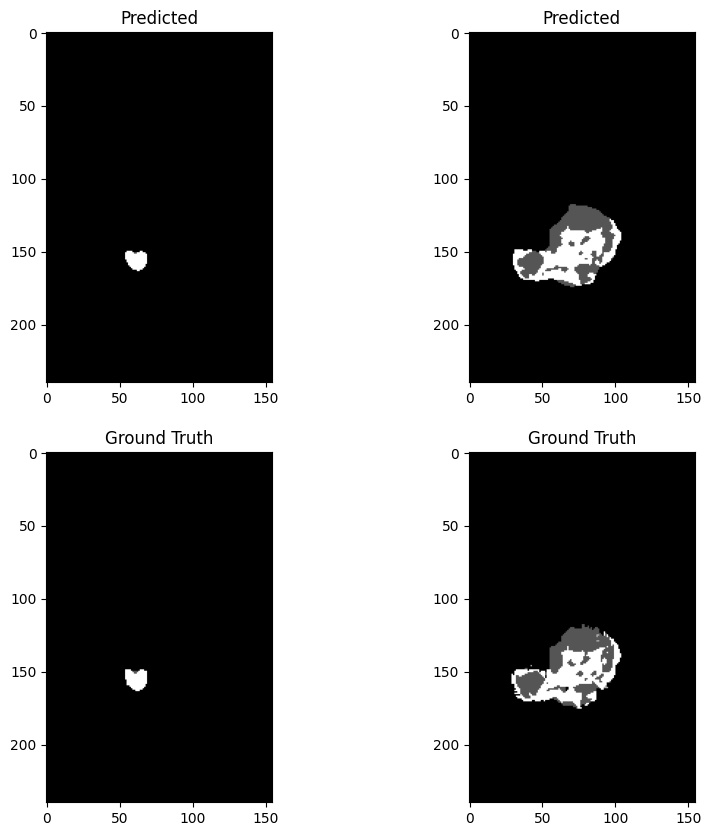

100%|██████████| 202/202 [07:05<00:00,  2.10s/it]



Average Training Loss: 0.010838922631862287

Average Training DSC: [0.9987634  0.8662308  0.90680832 0.74475376]
Average Training ASSD: [ 0.12265788 20.59361565 17.70596974 25.61141406]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


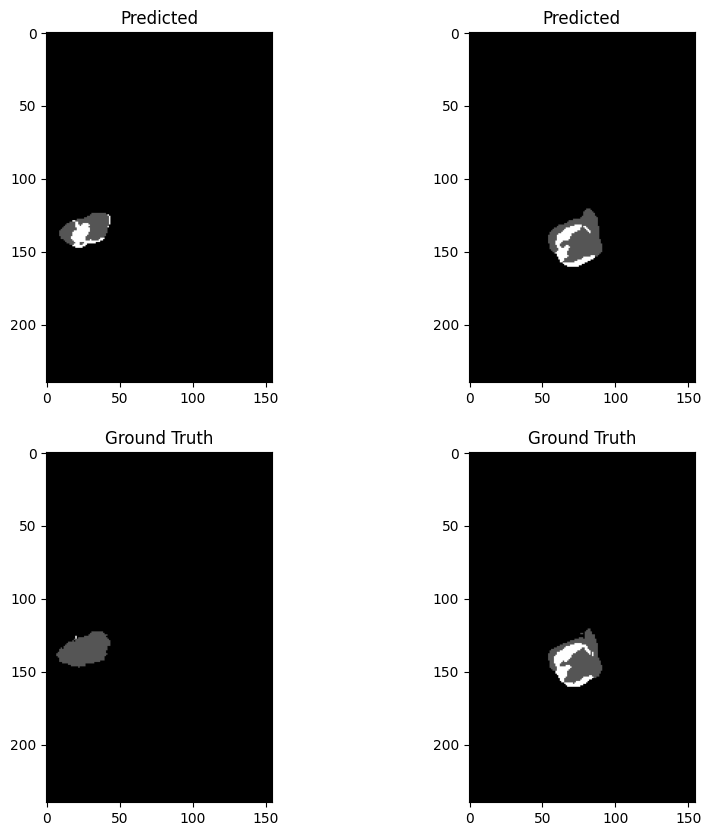

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.01438124026811006

Average Validation DSC: [0.99845242 0.83462474 0.89320888 0.718346  ]
Average Validation ASSD: [ 0.15650857 26.38673121 20.47425485 17.99437555]
Epoch 35/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


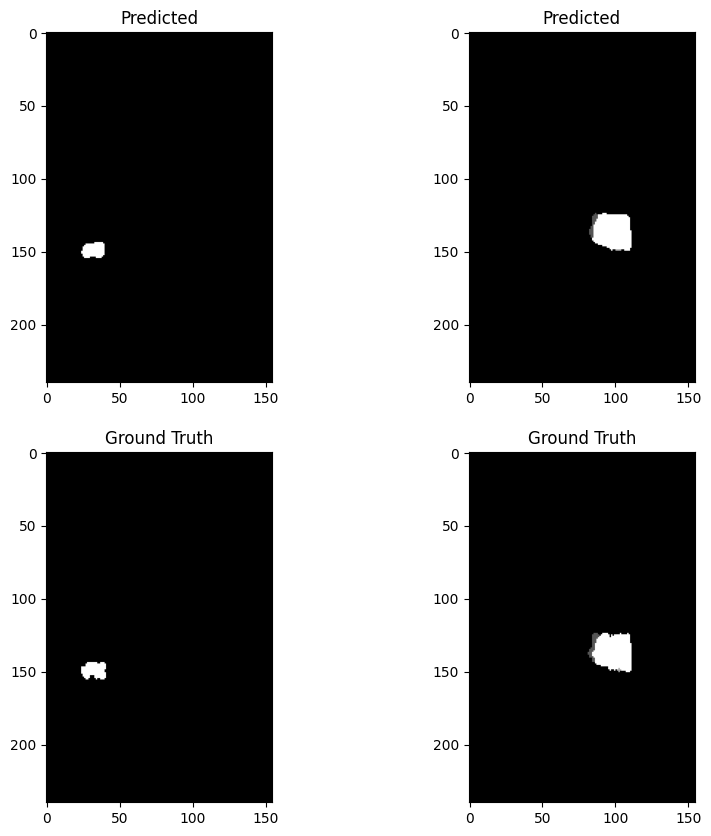

100%|██████████| 202/202 [06:57<00:00,  2.07s/it]



Average Training Loss: 0.009621419482818335

Average Training DSC: [0.99888502 0.89088816 0.92465127 0.76272298]
Average Training ASSD: [ 0.10704081 14.56841325 12.27168323 23.31965062]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


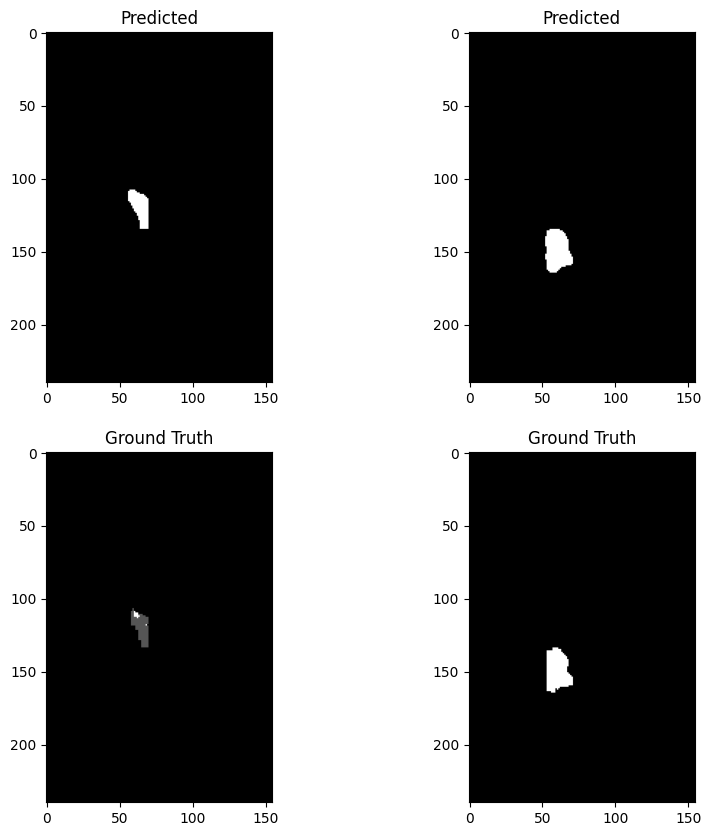

100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Average Validation Loss: 0.013859383643184807

Average Validation DSC: [0.99860766 0.80740074 0.90774287 0.67801553]
Average Validation ASSD: [ 0.13829384 38.83469844 17.48397472 38.5143109 ]
Epoch 36/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


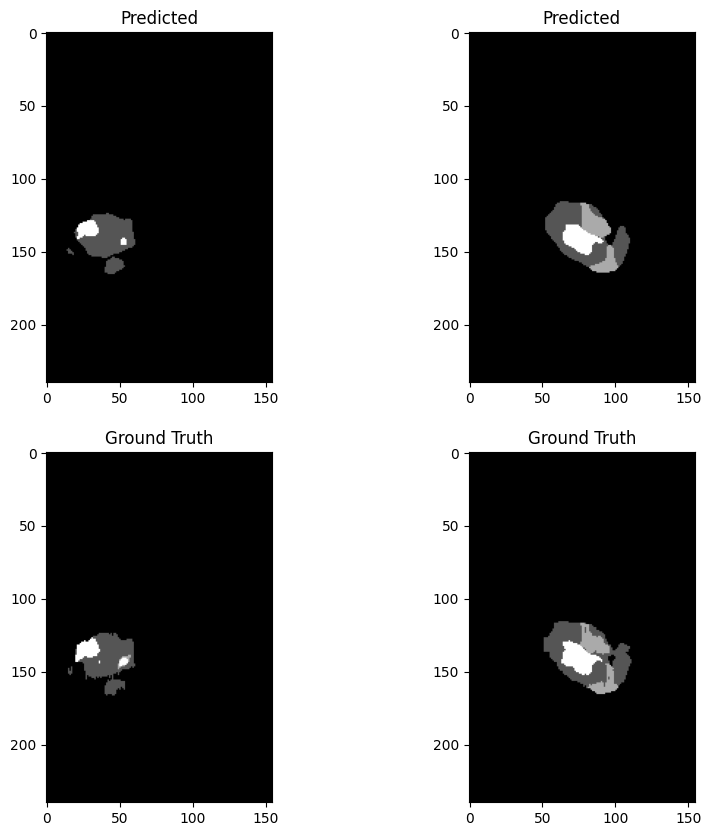

100%|██████████| 202/202 [07:01<00:00,  2.09s/it]



Average Training Loss: 0.009094887152590816

Average Training DSC: [0.99893923 0.89663102 0.92642456 0.77106032]
Average Training ASSD: [ 0.1018491  13.57286803 12.71699004 23.23345701]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


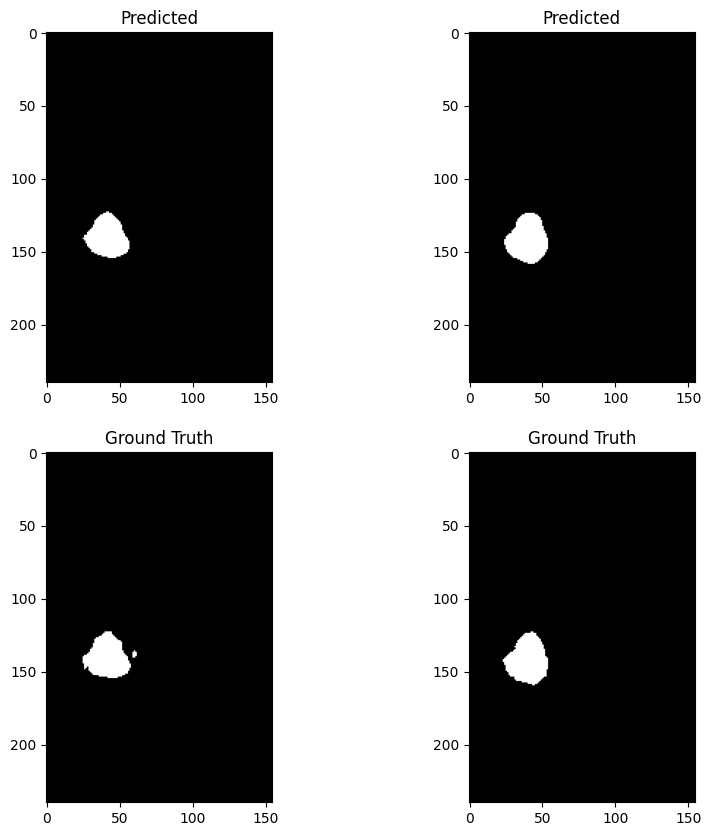

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.012711357644886947

Average Validation DSC: [0.99866101 0.86712591 0.90875703 0.74841919]
Average Validation ASSD: [ 0.13169195 17.7018722  17.41449647 17.32083356]
Epoch 37/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


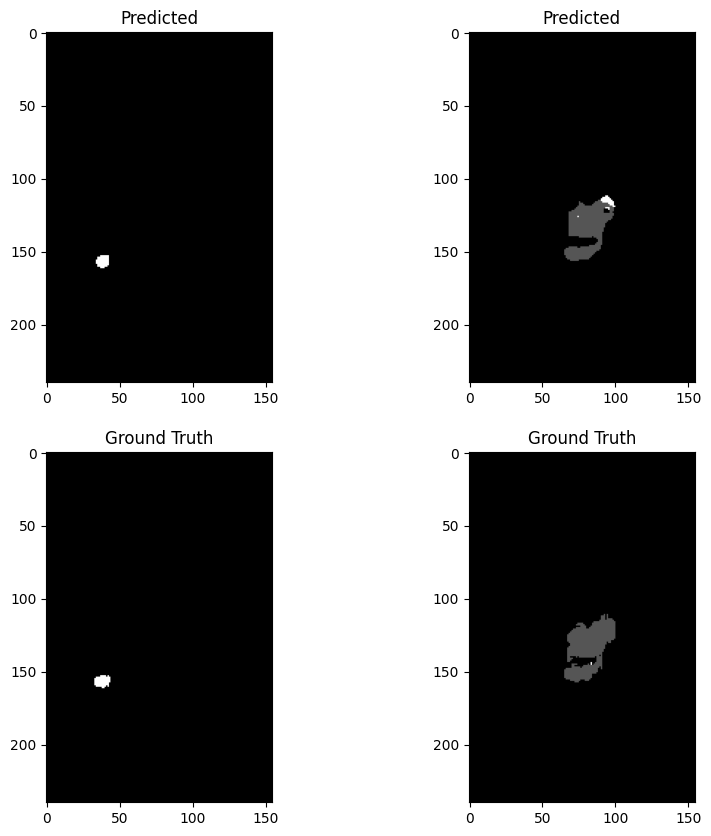

100%|██████████| 202/202 [07:19<00:00,  2.17s/it]



Average Training Loss: 0.00948199124471976

Average Training DSC: [0.99890092 0.89413321 0.91845928 0.76488241]
Average Training ASSD: [ 0.10416797 13.01036172 14.3766345  24.79059427]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


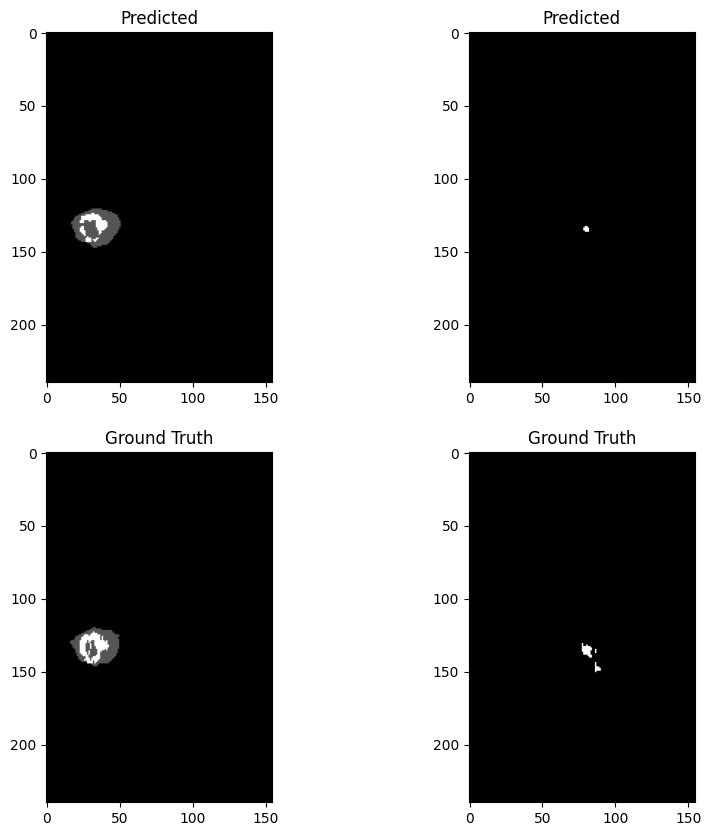

100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Average Validation Loss: 0.01493908520605342

Average Validation DSC: [0.99845747 0.82269066 0.89875753 0.68755186]
Average Validation ASSD: [ 0.15570369 29.61708543 18.34099917 26.6251099 ]
Epoch 38/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


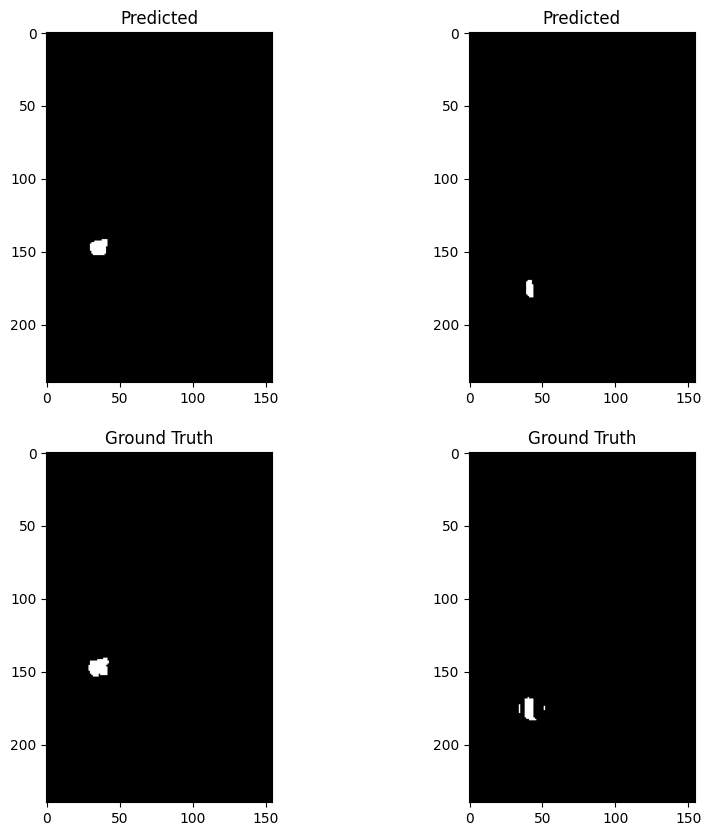

100%|██████████| 202/202 [07:06<00:00,  2.11s/it]



Average Training Loss: 0.008777788833318518

Average Training DSC: [0.99893759 0.90512454 0.93139649 0.77669367]
Average Training ASSD: [ 0.10243231 11.39387801 10.83817489 23.35031607]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


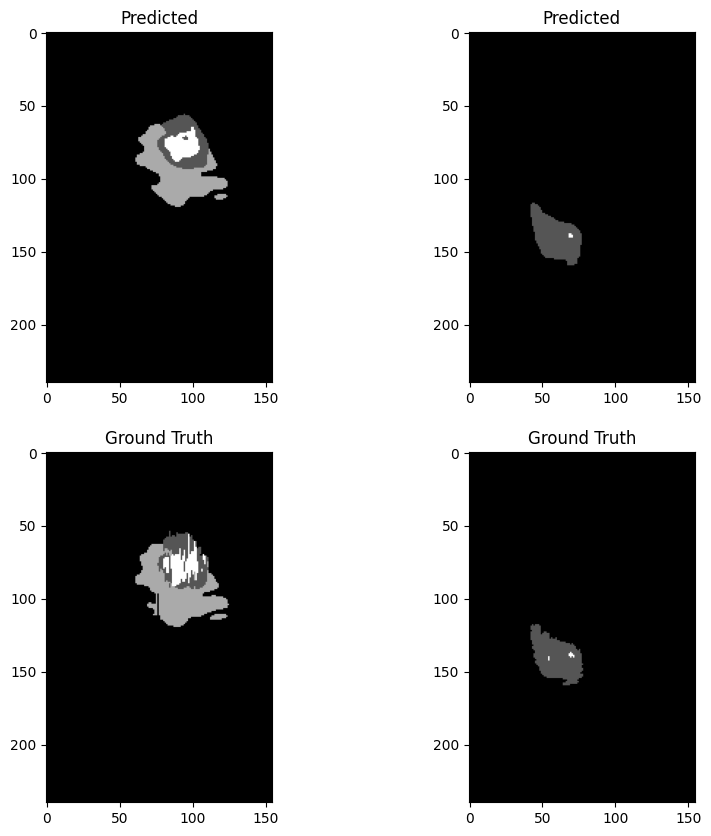

100%|██████████| 51/51 [01:14<00:00,  1.46s/it]


Average Validation Loss: 0.013235144874117538

Average Validation DSC: [0.99858734 0.84906481 0.90539455 0.73479044]
Average Validation ASSD: [ 0.1385512  23.7234779  19.10905107 21.06593284]
Epoch 39/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


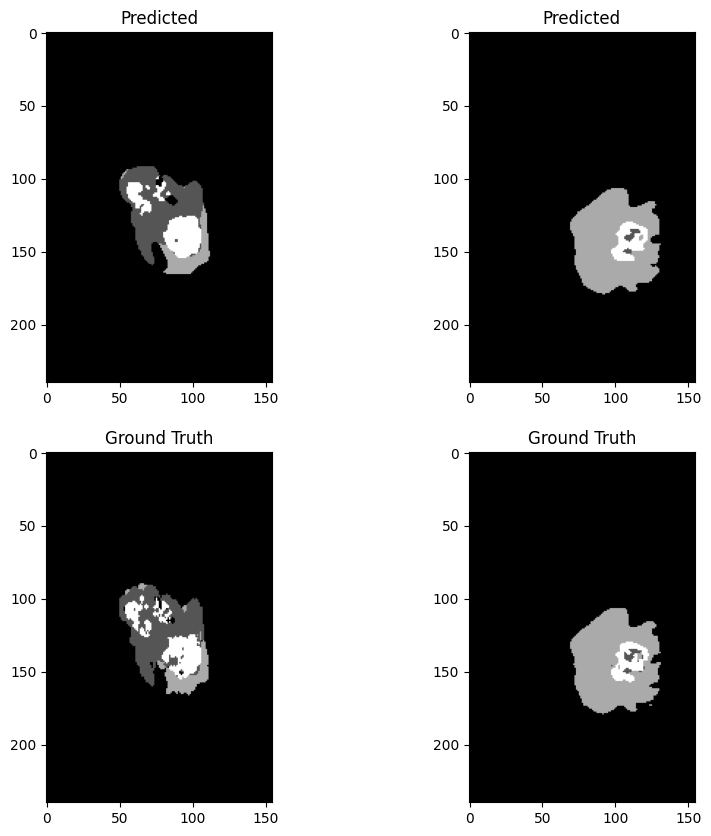

100%|██████████| 202/202 [07:08<00:00,  2.12s/it]



Average Training Loss: 0.009414867770000555

Average Training DSC: [0.99893174 0.89281517 0.91825528 0.76766713]
Average Training ASSD: [ 0.10229944 14.9200219  14.68147309 24.18572671]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


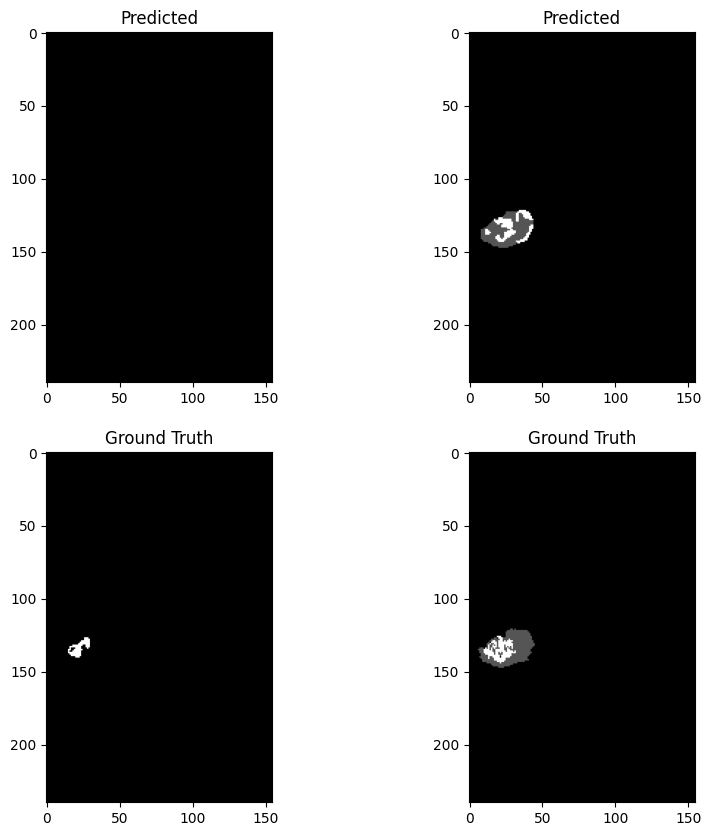

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.015543203180034956

Average Validation DSC: [0.99843403 0.83203171 0.83693658 0.71001372]
Average Validation ASSD: [ 0.16829122 27.2246288  37.98348414 21.38880508]
Epoch 40/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


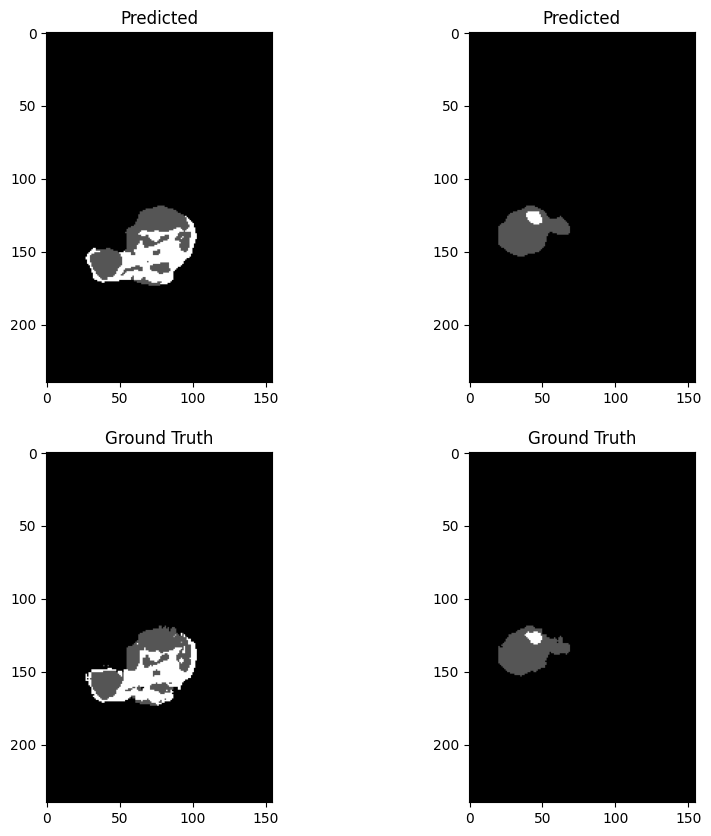

100%|██████████| 202/202 [07:03<00:00,  2.10s/it]



Average Training Loss: 0.008491562730125567

Average Training DSC: [0.99898832 0.90581105 0.92890244 0.78336889]
Average Training ASSD: [ 0.09536975 11.59914925 11.81158255 23.14938452]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


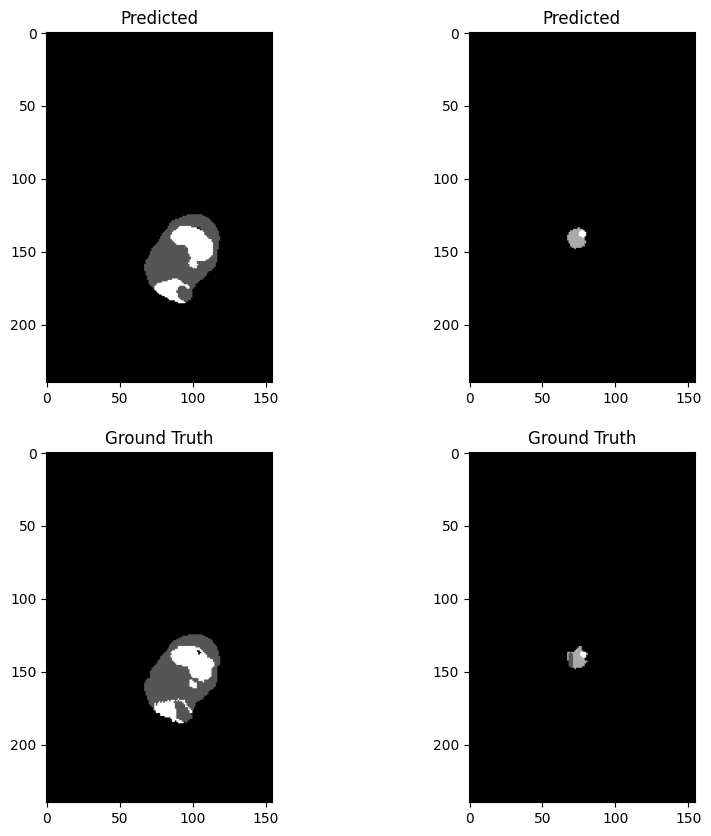

100%|██████████| 51/51 [01:21<00:00,  1.59s/it]


Average Validation Loss: 0.011756540650465325

Average Validation DSC: [0.99881095 0.86842757 0.90967989 0.77079859]
Average Validation ASSD: [ 0.11631217 21.19830045 18.84429917 15.42009347]
Epoch 41/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


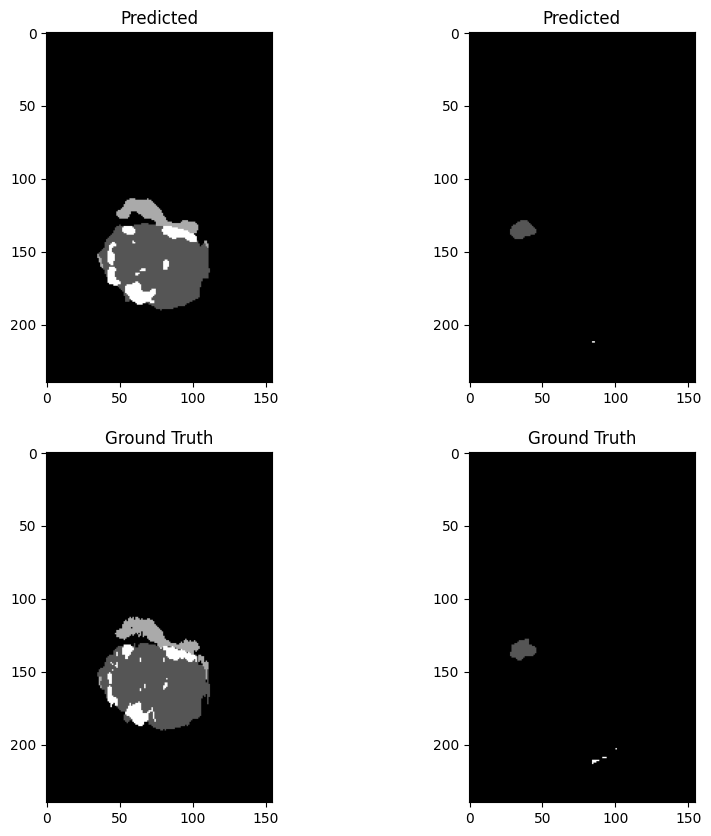

100%|██████████| 202/202 [07:11<00:00,  2.14s/it]



Average Training Loss: 0.007361667553460834

Average Training DSC: [0.99911999 0.92531513 0.93904015 0.8026651 ]
Average Training ASSD: [ 0.08222129  7.29033452  9.31090633 23.25177285]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


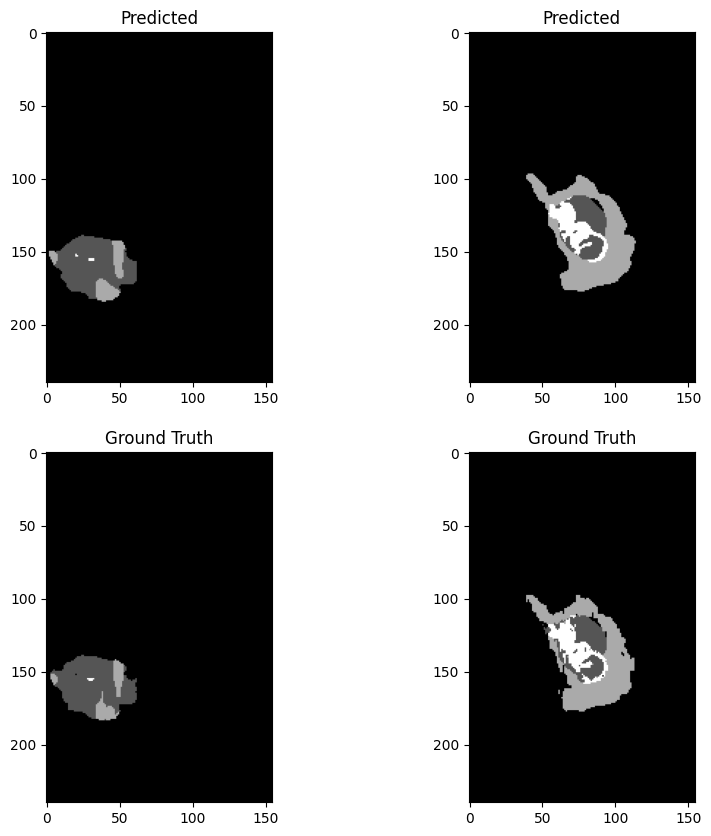

100%|██████████| 51/51 [01:17<00:00,  1.51s/it]


Average Validation Loss: 0.011928436227654125

Average Validation DSC: [0.99873813 0.86749427 0.89389786 0.76909592]
Average Validation ASSD: [ 0.12927187 21.51018962 21.57278255 15.90863074]
Epoch 42/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


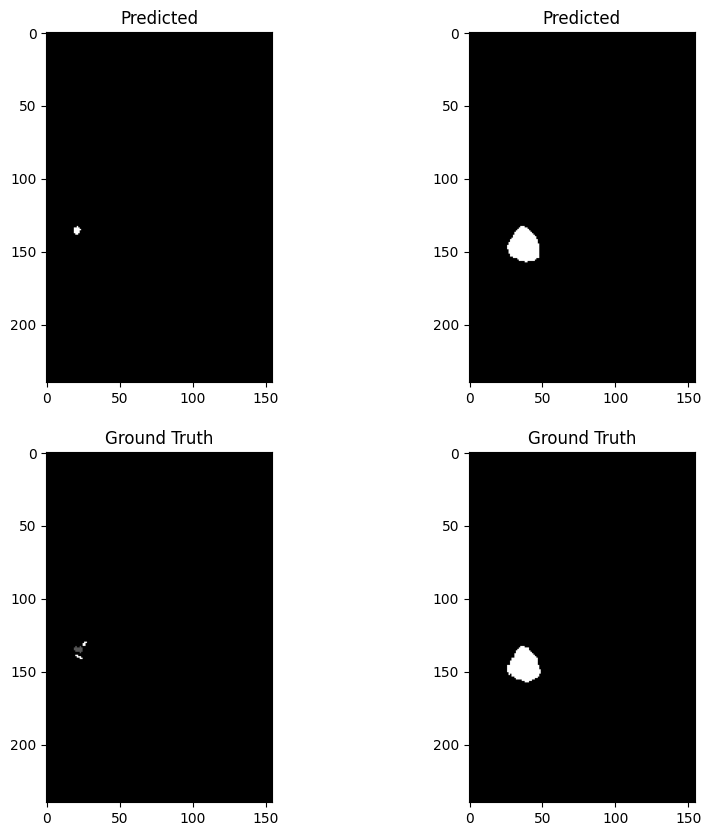

100%|██████████| 202/202 [07:08<00:00,  2.12s/it]



Average Training Loss: 0.0073476911909730715

Average Training DSC: [0.99912932 0.92034182 0.94133507 0.80475709]
Average Training ASSD: [ 0.08087203  8.85822278  8.04083259 21.72449235]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


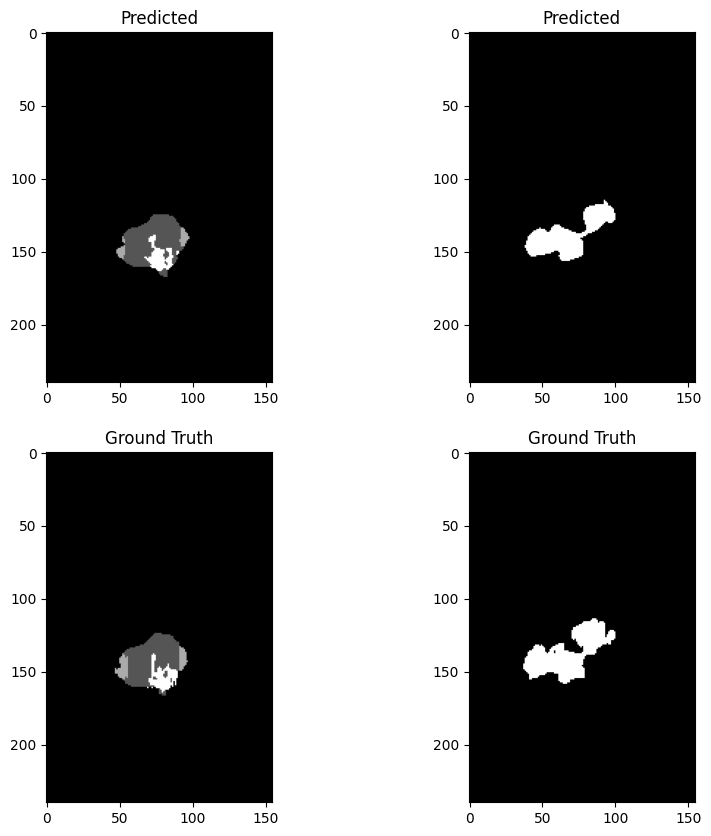

100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Average Validation Loss: 0.015929341526227256

Average Validation DSC: [0.99834927 0.83864238 0.89766311 0.72653577]
Average Validation ASSD: [ 0.1730306  25.14613454 18.85251577 17.54817332]
Epoch 43/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


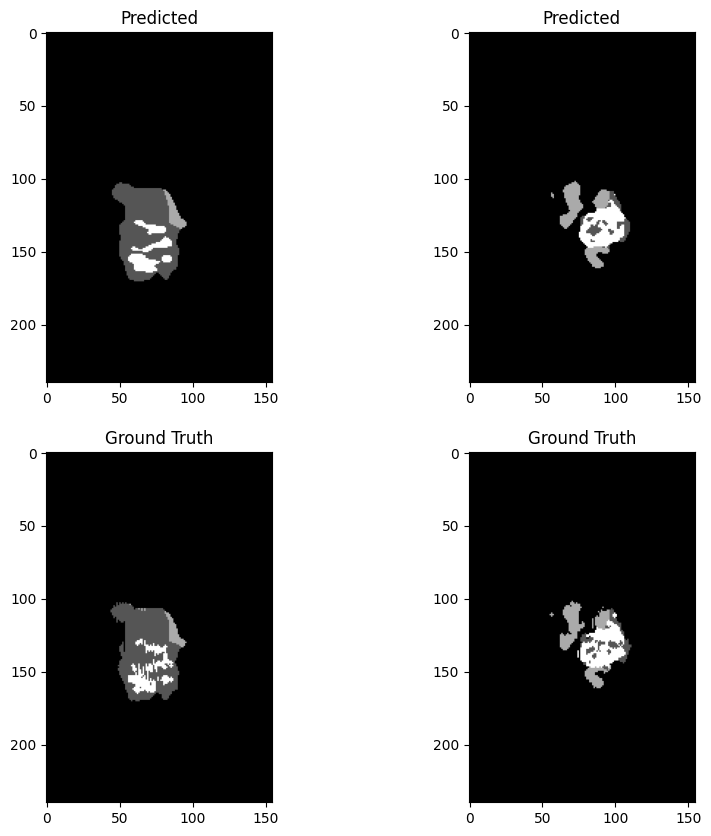

100%|██████████| 202/202 [07:07<00:00,  2.12s/it]



Average Training Loss: 0.007379374056501259

Average Training DSC: [0.99912207 0.9202533  0.93956165 0.80133491]
Average Training ASSD: [ 0.0839218   8.41435163  9.38039601 21.76285216]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


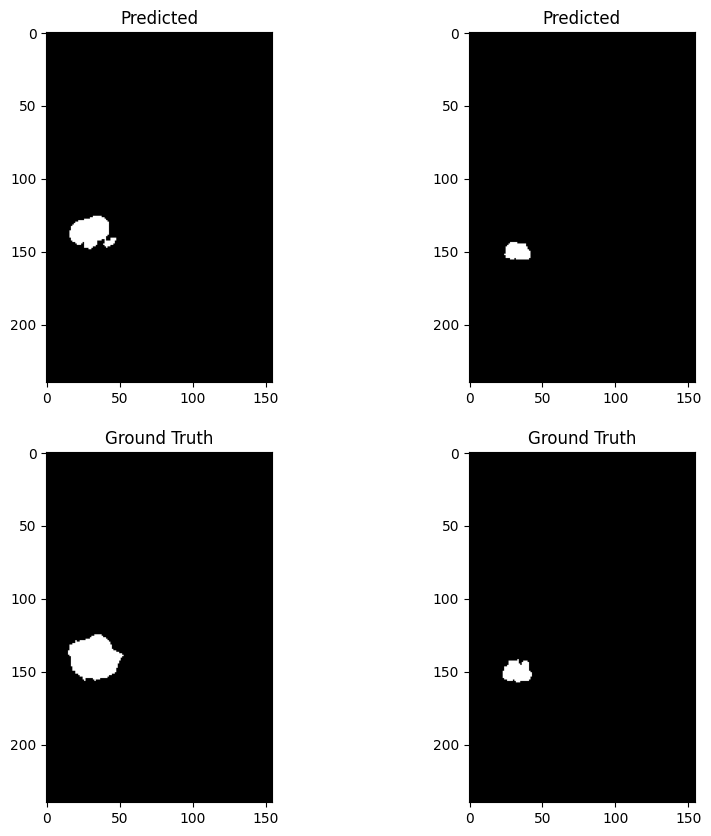

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.01690127780916644

Average Validation DSC: [0.99835432 0.80455994 0.84108074 0.66961125]
Average Validation ASSD: [ 0.17833165 35.88533151 35.13765627 30.31672619]
Epoch 44/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


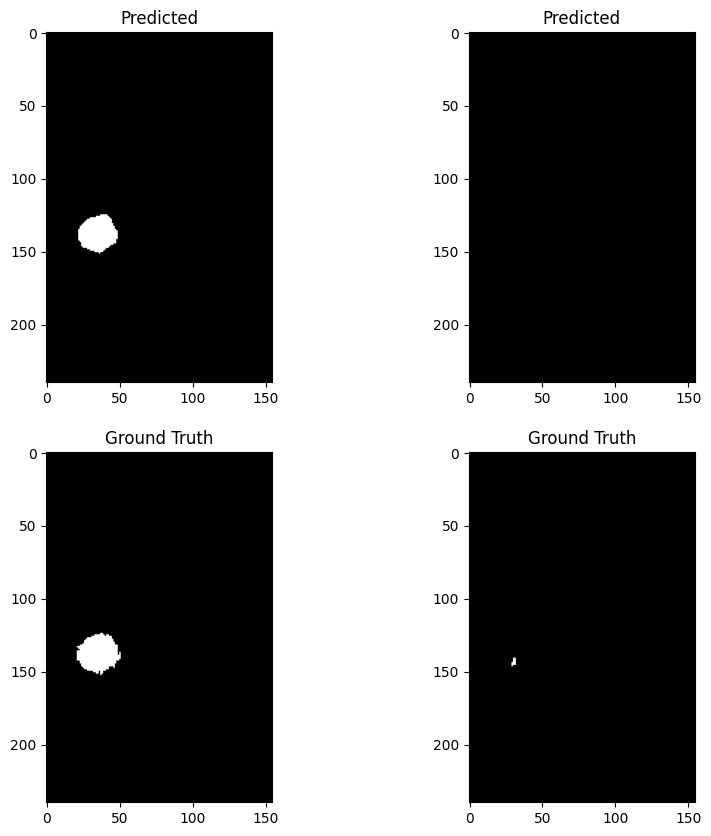

100%|██████████| 202/202 [07:05<00:00,  2.11s/it]



Average Training Loss: 0.0081644079182297

Average Training DSC: [0.99904629 0.90642968 0.92780859 0.79166825]
Average Training ASSD: [ 0.09084385 11.4507371  13.06691398 21.63866451]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


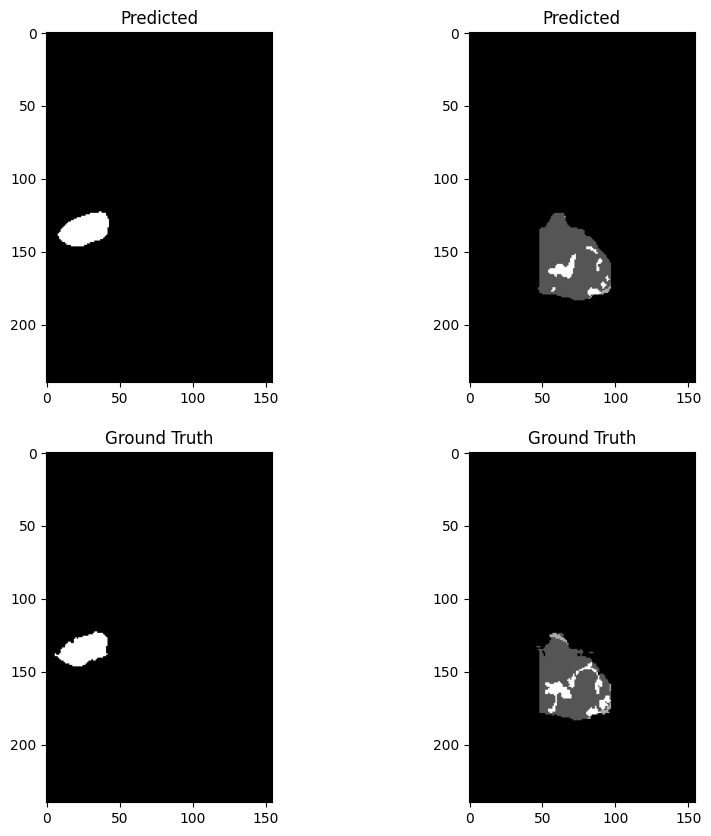

100%|██████████| 51/51 [01:14<00:00,  1.47s/it]


Average Validation Loss: 0.012620387288431326

Average Validation DSC: [0.99858813 0.87064918 0.90711103 0.75712003]
Average Validation ASSD: [ 0.13839999 19.18342776 17.75231568 16.11406651]
Epoch 45/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


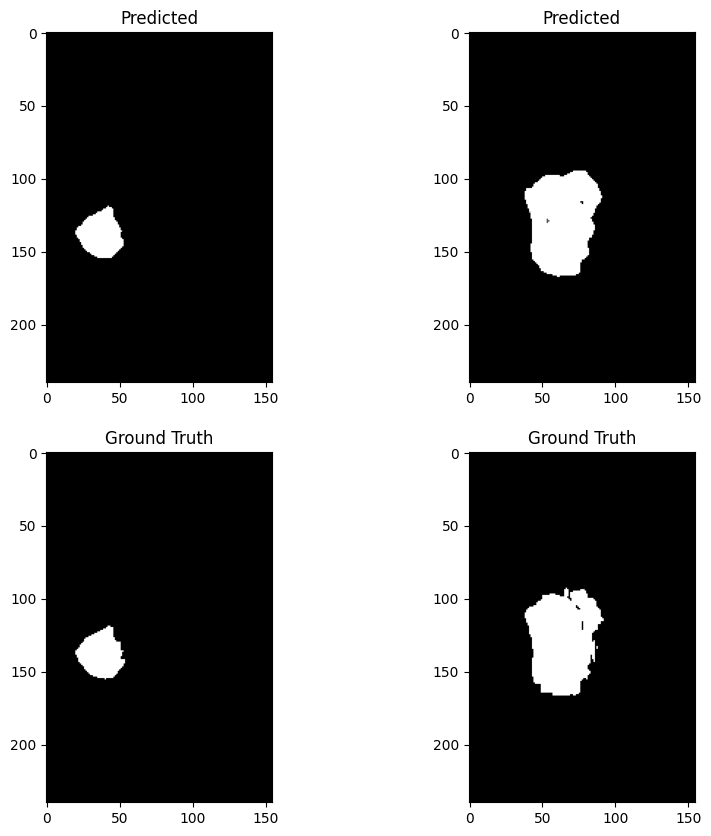

100%|██████████| 202/202 [07:03<00:00,  2.10s/it]



Average Training Loss: 0.00724397825611995

Average Training DSC: [0.99913323 0.91960687 0.94030767 0.80415486]
Average Training ASSD: [ 0.0811268   9.38116235  9.08035935 20.40825522]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


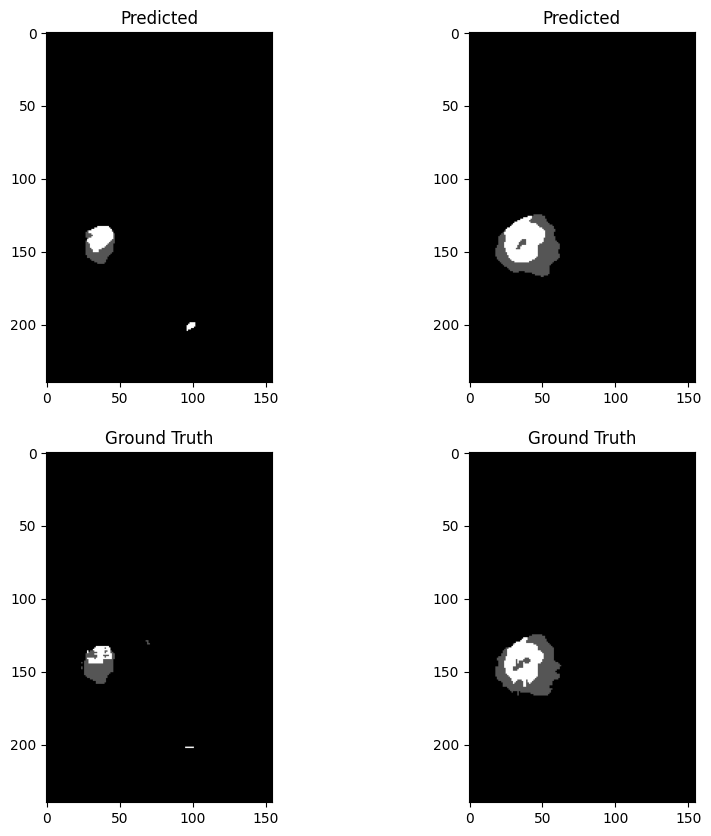

100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Average Validation Loss: 0.012384481645901413

Average Validation DSC: [0.99866601 0.79567719 0.8898398  0.76176536]
Average Validation ASSD: [ 0.15741508 46.61944904 26.01801212 11.46238494]
Epoch 46/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


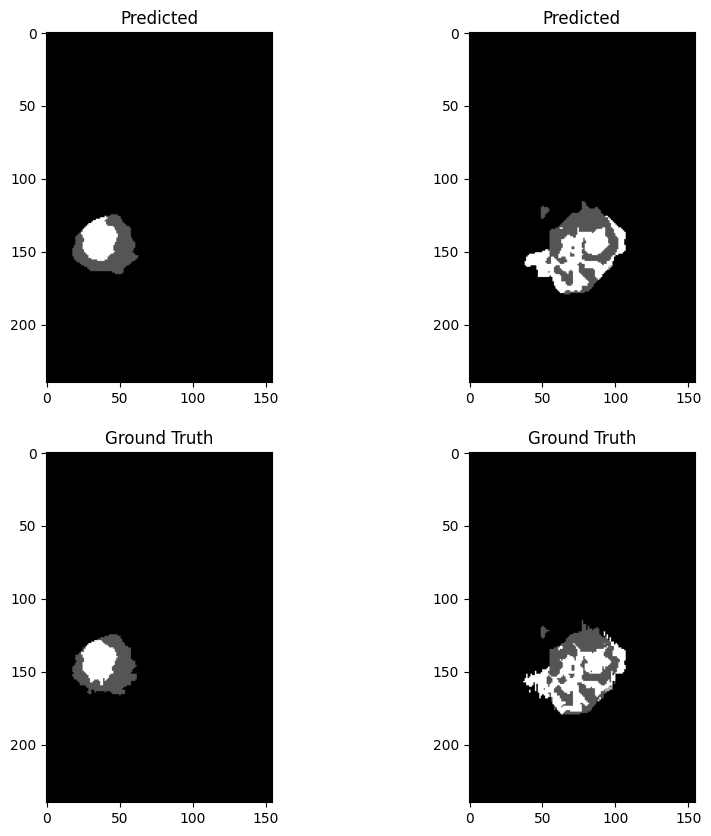

100%|██████████| 202/202 [07:02<00:00,  2.09s/it]



Average Training Loss: 0.008588294581611557

Average Training DSC: [0.99900655 0.89720629 0.92677499 0.78396121]
Average Training ASSD: [ 0.09699975 14.66631517 12.6376316  20.1796476 ]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


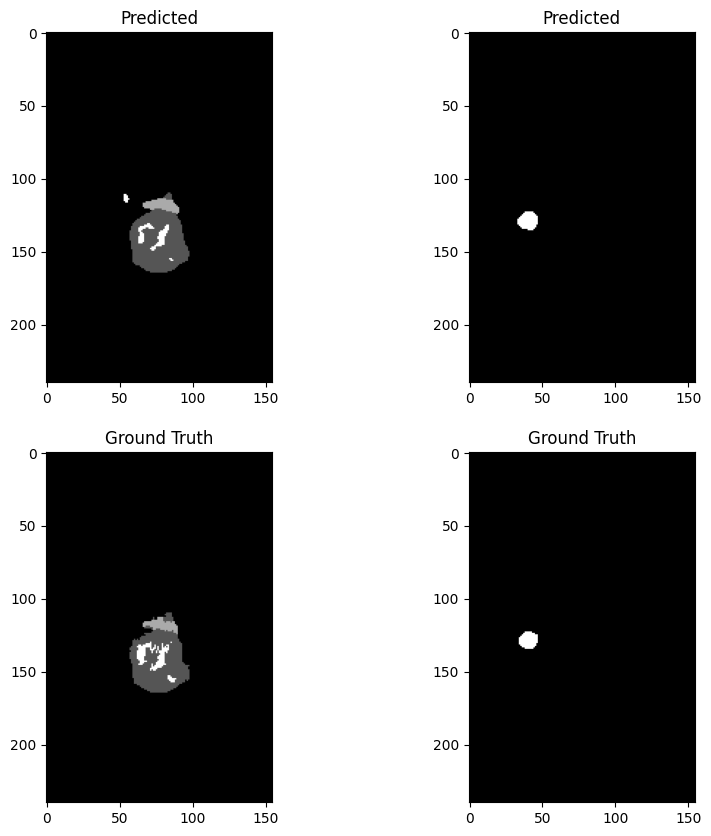

100%|██████████| 51/51 [01:17<00:00,  1.53s/it]


Average Validation Loss: 0.013129557263763511

Average Validation DSC: [0.99858656 0.82359299 0.89044183 0.73777306]
Average Validation ASSD: [ 0.14173137 36.57591297 22.23054597 16.29914758]
Epoch 47/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


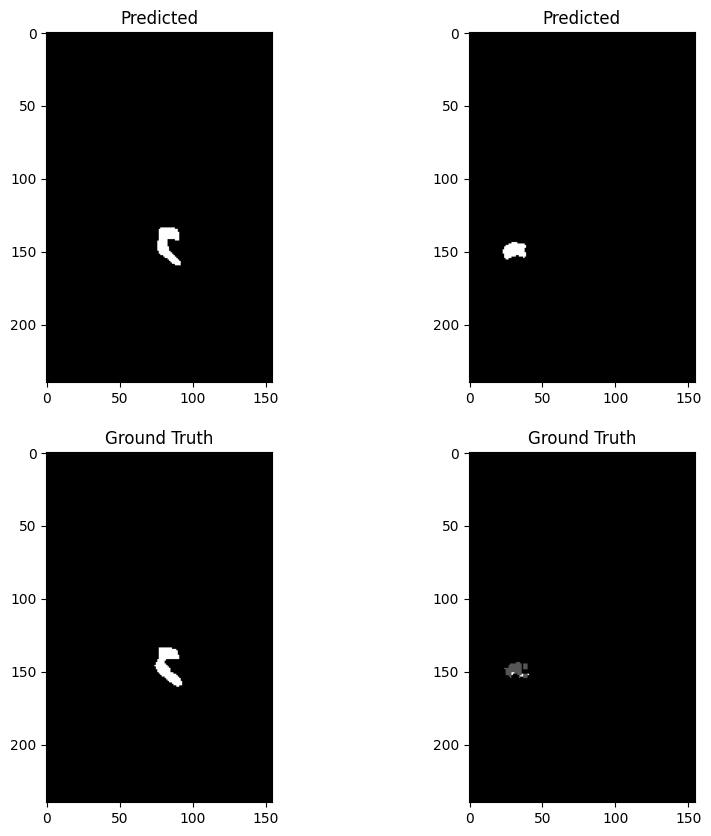

100%|██████████| 202/202 [07:05<00:00,  2.10s/it]



Average Training Loss: 0.0087444413139826

Average Training DSC: [0.99901013 0.89200797 0.91951944 0.78327386]
Average Training ASSD: [ 0.09651042 16.3328514  15.34616809 20.63195836]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


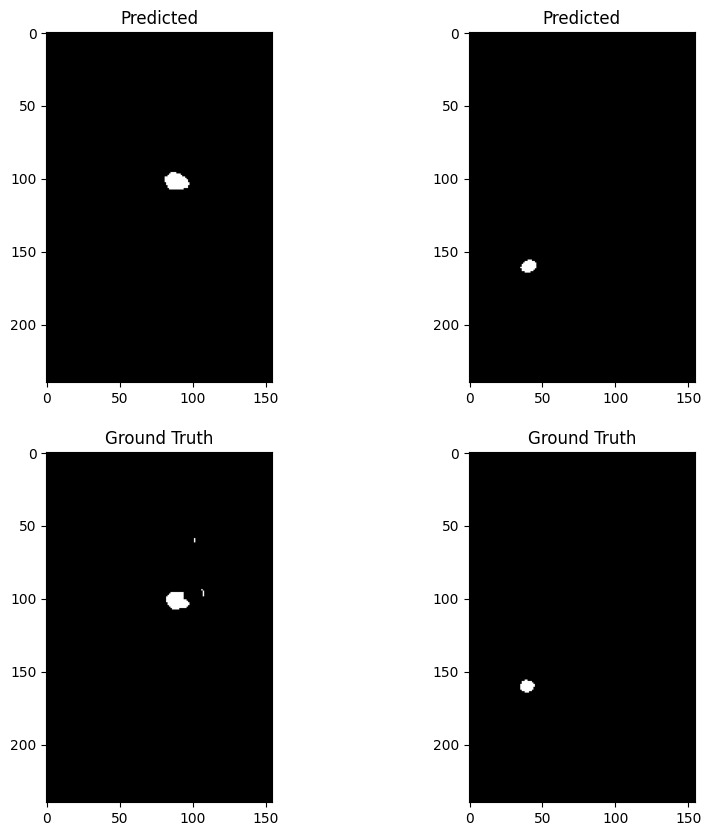

100%|██████████| 51/51 [01:15<00:00,  1.47s/it]


Average Validation Loss: 0.01684060431651625

Average Validation DSC: [0.99824356 0.75479929 0.66244725 0.72443633]
Average Validation ASSD: [ 0.27637052 52.4771888  96.95885127  9.22254148]
Epoch 48/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


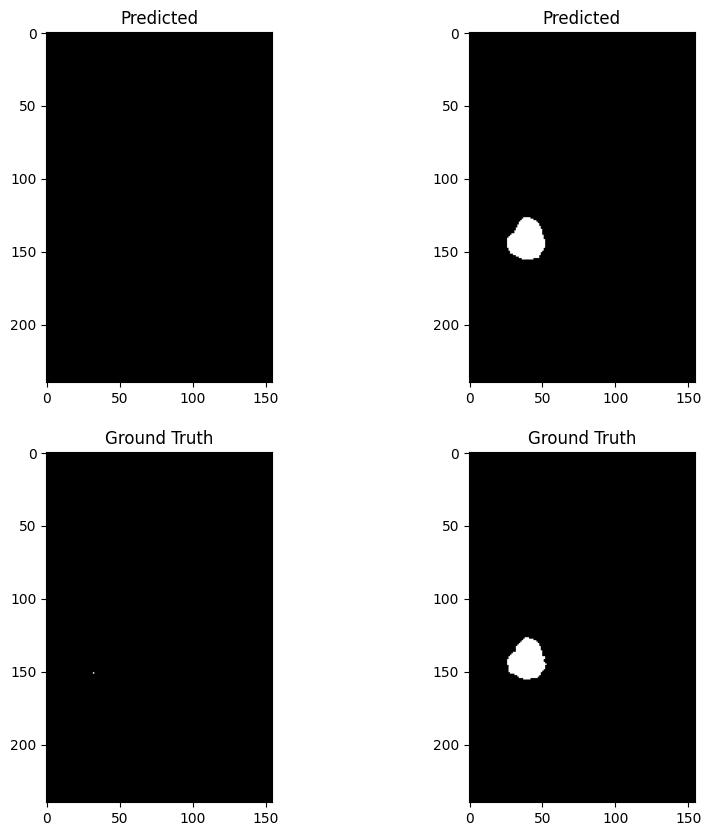

100%|██████████| 202/202 [07:06<00:00,  2.11s/it]



Average Training Loss: 0.007755936019694303

Average Training DSC: [0.99910086 0.91295991 0.93458951 0.79586651]
Average Training ASSD: [ 0.08542017 10.59450081 10.44741862 21.42799483]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


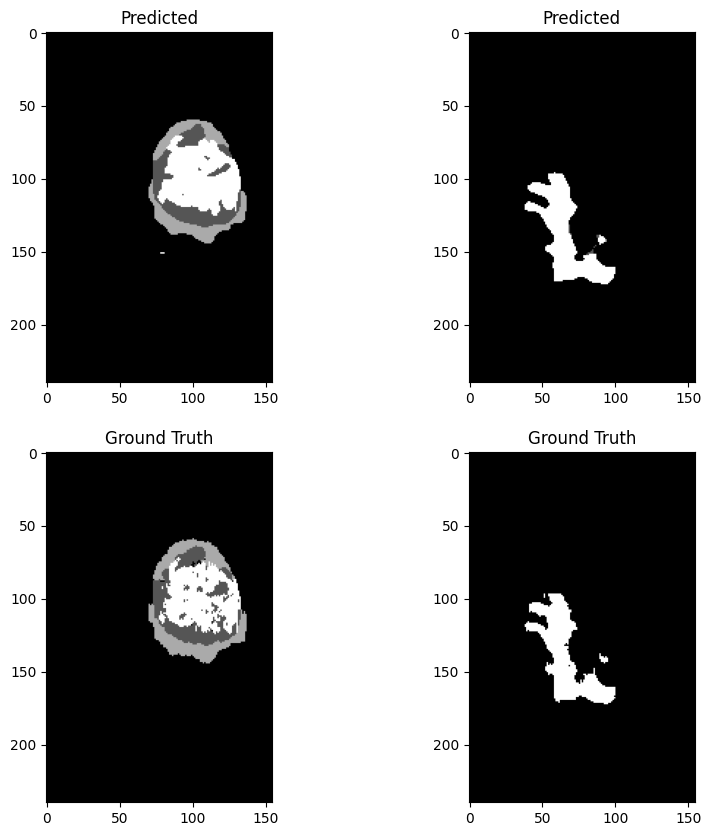

100%|██████████| 51/51 [01:15<00:00,  1.49s/it]


Average Validation Loss: 0.012597679890984414

Average Validation DSC: [0.99871419 0.8553395  0.90548939 0.77110287]
Average Validation ASSD: [ 0.13268175 22.75111807 18.87667838  9.67444331]
Epoch 49/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


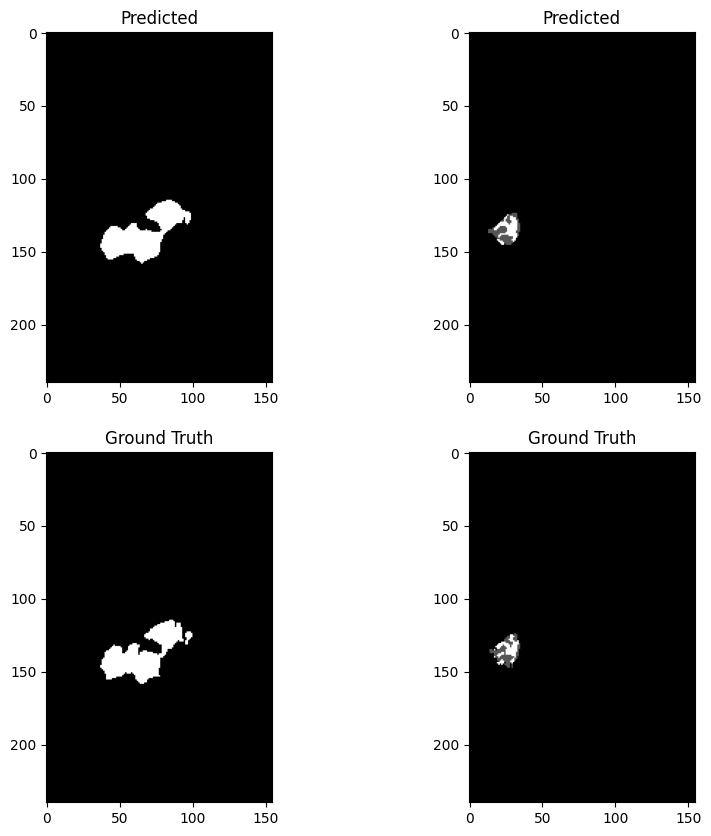

100%|██████████| 202/202 [07:05<00:00,  2.11s/it]



Average Training Loss: 0.00634930700658461

Average Training DSC: [0.99923508 0.93590049 0.94245849 0.82244138]
Average Training ASSD: [ 0.07068746  5.60134277  9.29143171 19.72398389]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


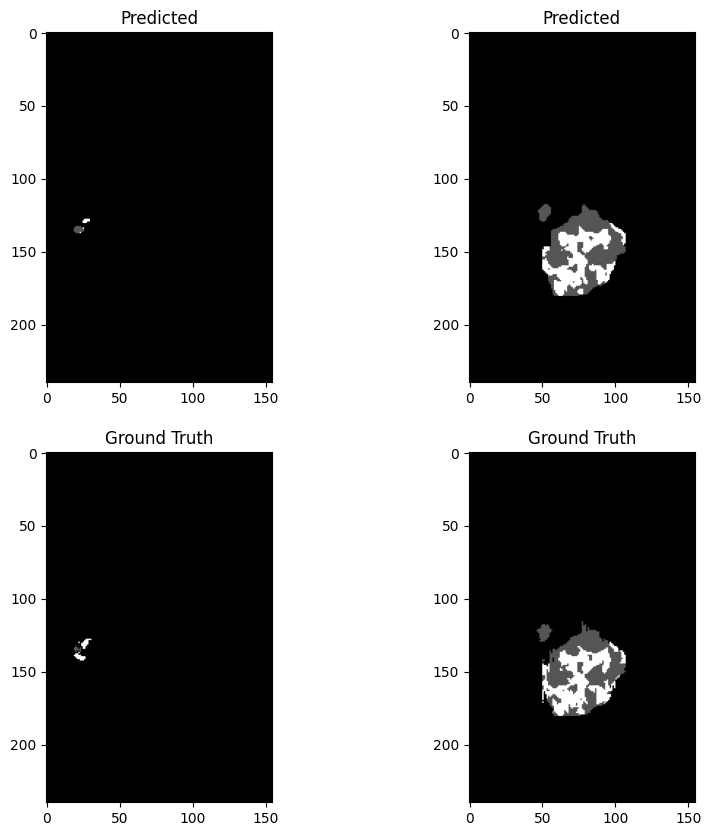

100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Average Validation Loss: 0.010793628919796617

Average Validation DSC: [0.99896624 0.89538277 0.92532526 0.7834115 ]
Average Validation ASSD: [ 0.10536876 15.23249638 14.98426186 18.65128862]
Epoch 50/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


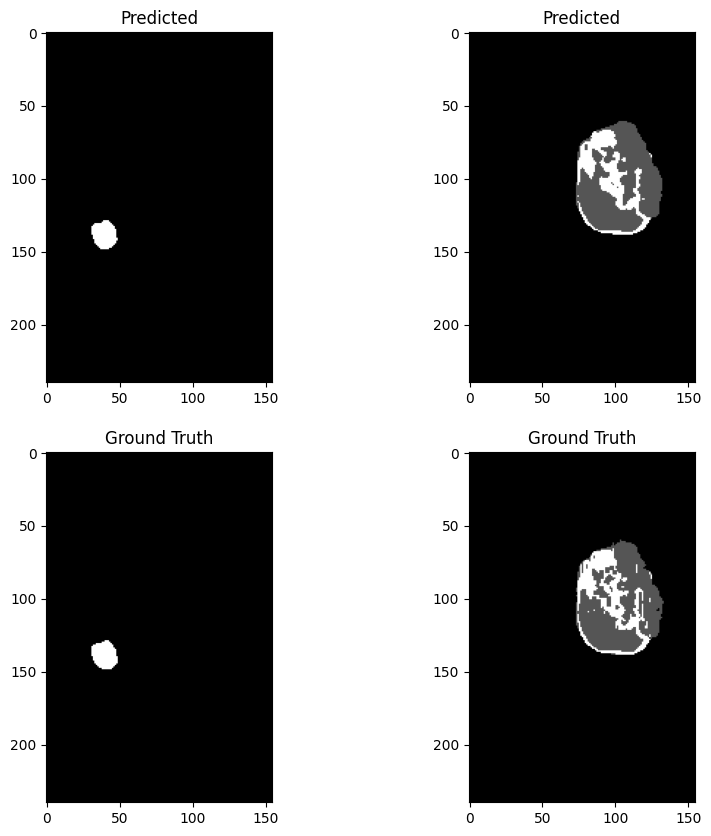

100%|██████████| 202/202 [07:03<00:00,  2.10s/it]



Average Training Loss: 0.0061793591571270975

Average Training DSC: [0.99926121 0.93767632 0.94904545 0.82700314]
Average Training ASSD: [ 0.06971067  4.99539731  7.3309832  19.86530837]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


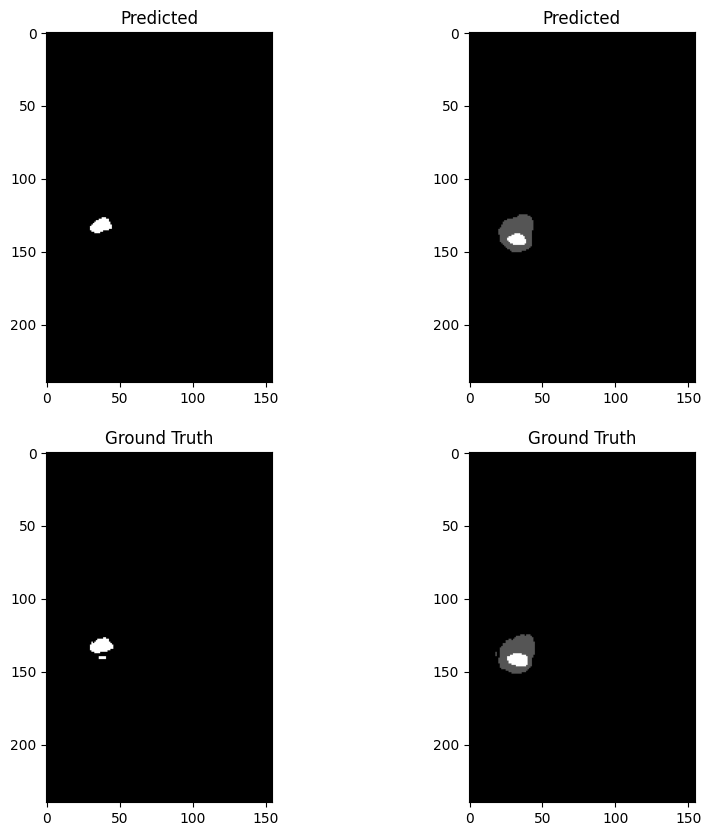

100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Average Validation Loss: 0.010795505799572258

Average Validation DSC: [0.9990005  0.88319224 0.92360206 0.77579492]
Average Validation ASSD: [ 0.10294787 19.9017572  14.98378305 22.13614041]
Epoch 51/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


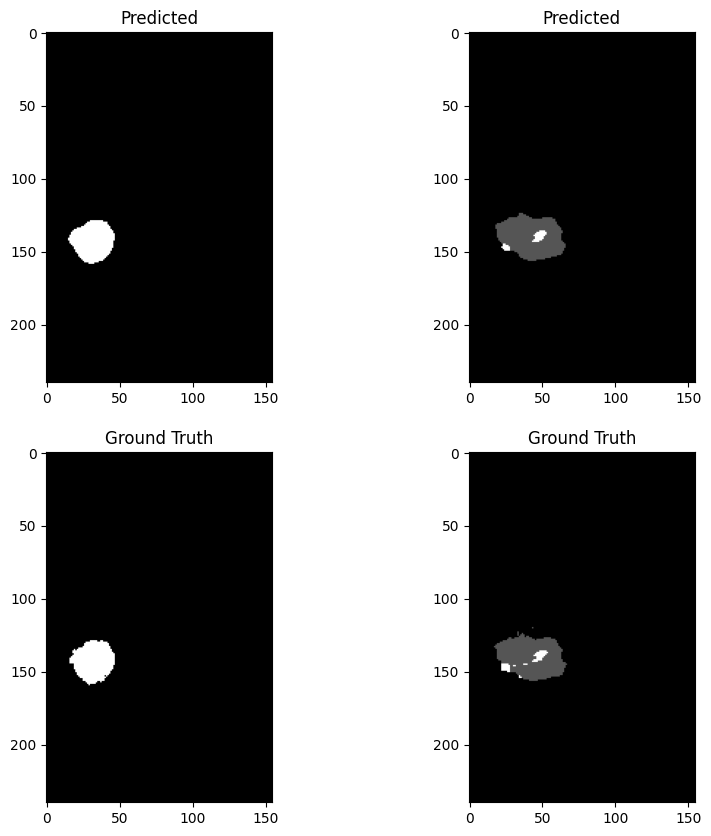

100%|██████████| 202/202 [07:02<00:00,  2.09s/it]



Average Training Loss: 0.005662876463698057

Average Training DSC: [0.99932131 0.94466883 0.95229012 0.83548781]
Average Training ASSD: [ 0.06245363  4.0774827   6.72214991 19.66957047]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


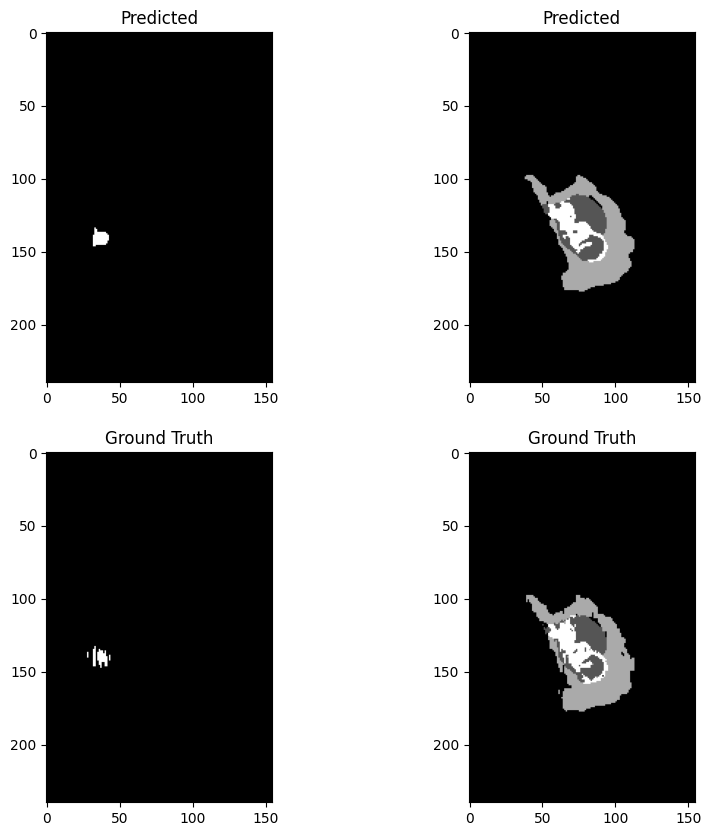

100%|██████████| 51/51 [01:19<00:00,  1.55s/it]


Average Validation Loss: 0.01038451848880333

Average Validation DSC: [0.99903499 0.89906337 0.92900749 0.79229436]
Average Validation ASSD: [ 0.10256019 14.31752083 13.48437403 18.52218459]
Epoch 52/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


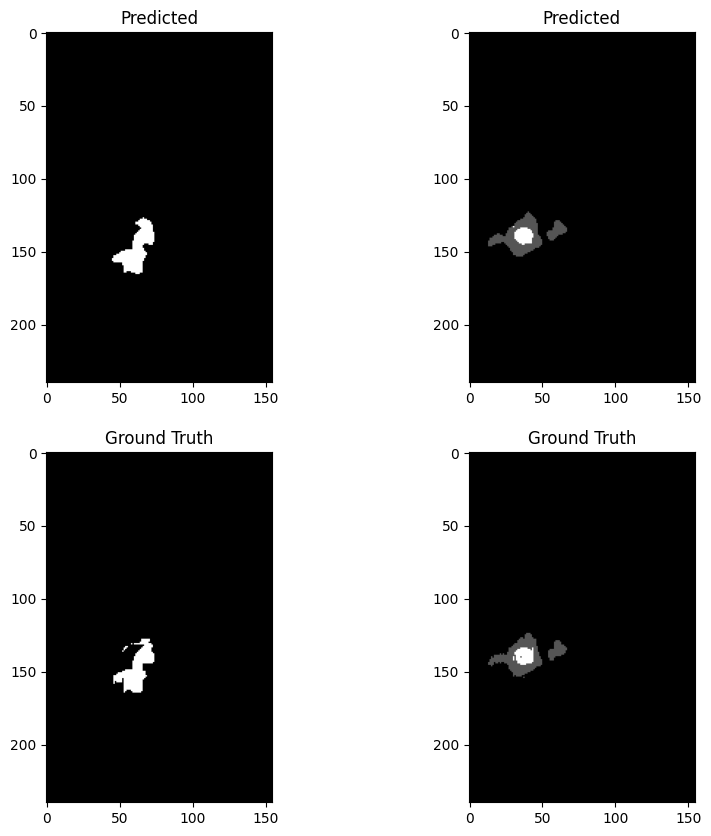

100%|██████████| 202/202 [07:00<00:00,  2.08s/it]



Average Training Loss: 0.005358510725615122

Average Training DSC: [0.99935988 0.94586007 0.95456339 0.84211803]
Average Training ASSD: [ 0.05929362  4.13381932  6.27291882 19.01462759]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


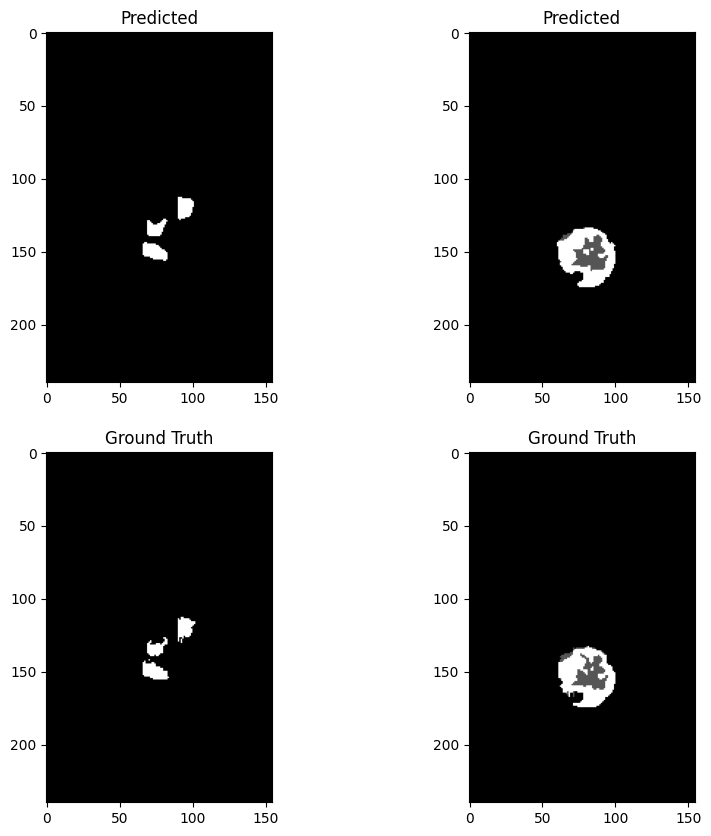

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.010358673611692354

Average Validation DSC: [0.99903694 0.89861151 0.92613196 0.79125708]
Average Validation ASSD: [ 0.09966423 15.19535581 15.567336   18.80405508]
Epoch 53/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


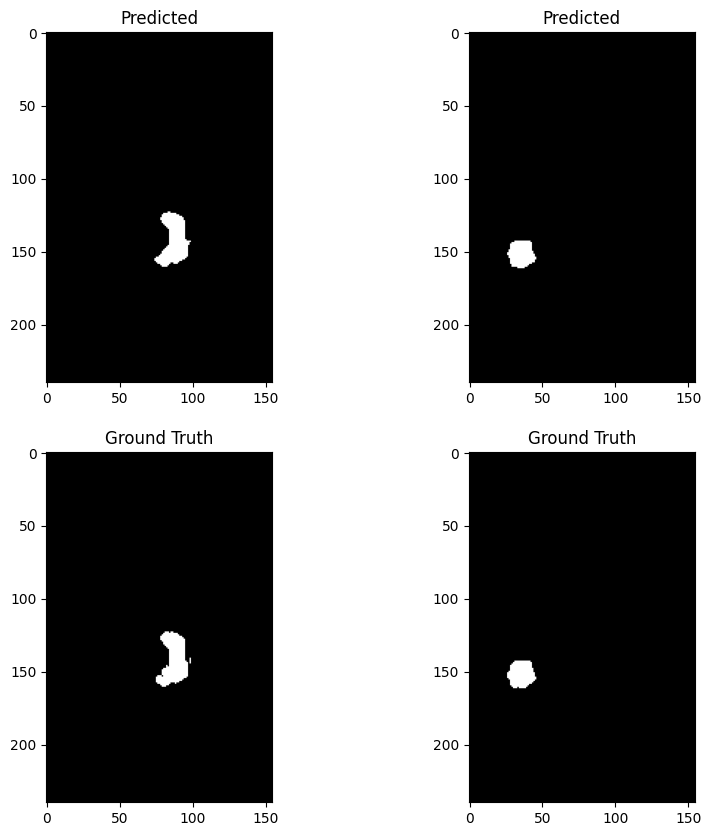

100%|██████████| 202/202 [07:00<00:00,  2.08s/it]



Average Training Loss: 0.0052707156334717824

Average Training DSC: [0.99936753 0.9498908  0.95355665 0.84682431]
Average Training ASSD: [ 0.05699548  2.93674539  6.49822568 17.55124392]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


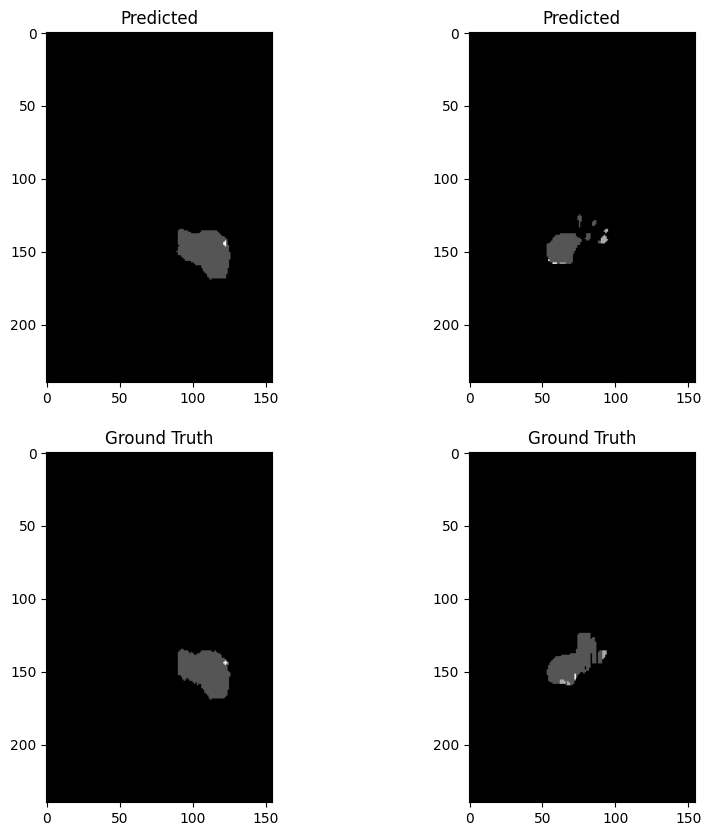

100%|██████████| 51/51 [01:15<00:00,  1.47s/it]


Average Validation Loss: 0.010224058895426638

Average Validation DSC: [0.9990368  0.89040016 0.92770349 0.80930781]
Average Validation ASSD: [ 0.09865629 17.78119217 14.36891142 11.29621149]
Epoch 54/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


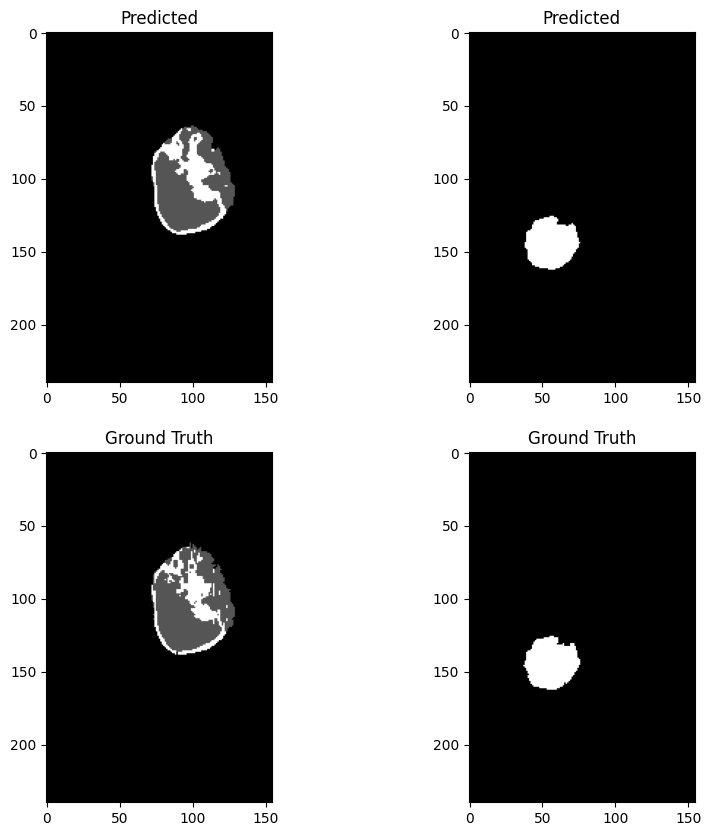

100%|██████████| 202/202 [07:10<00:00,  2.13s/it]



Average Training Loss: 0.005183337738110435

Average Training DSC: [0.99937903 0.9490852  0.95400301 0.84888965]
Average Training ASSD: [ 0.05573513  3.30395519  6.72229619 16.31569437]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


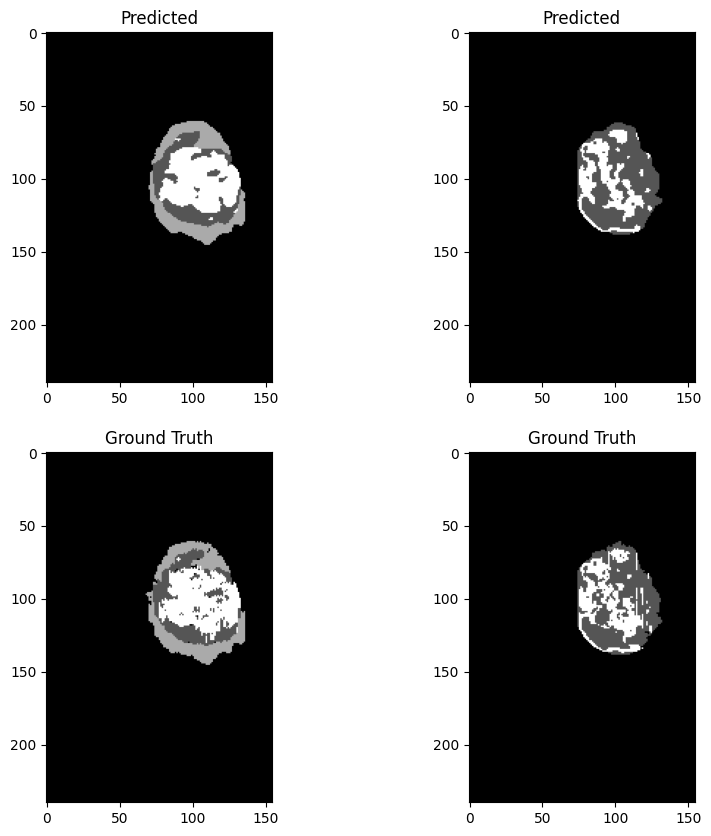

100%|██████████| 51/51 [01:14<00:00,  1.47s/it]


Average Validation Loss: 0.010158767741100461

Average Validation DSC: [0.99905173 0.89520324 0.92498054 0.80425675]
Average Validation ASSD: [ 0.09507821 16.90293527 14.99464379 14.60188697]
Epoch 55/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


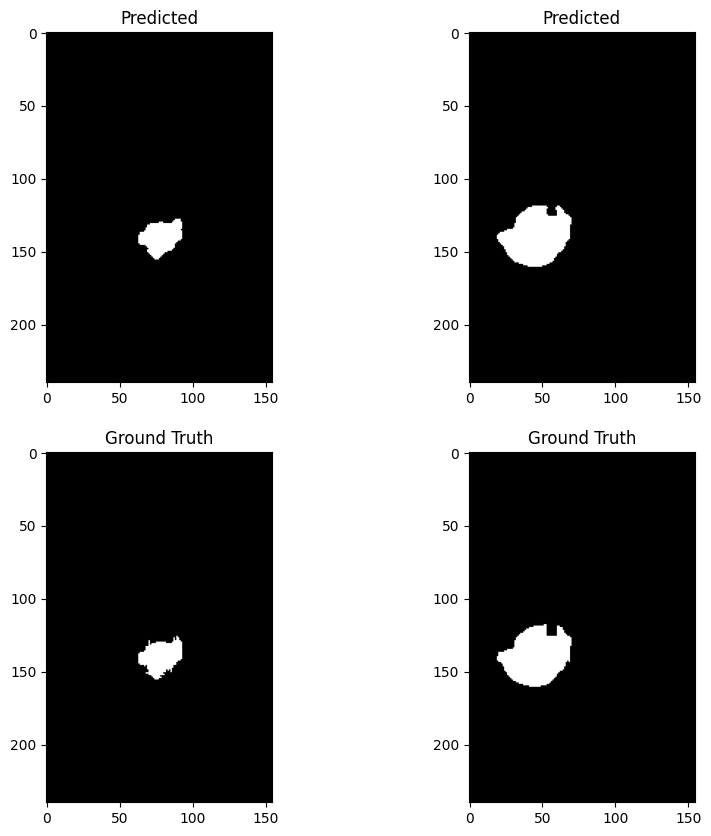

100%|██████████| 202/202 [07:06<00:00,  2.11s/it]



Average Training Loss: 0.005130095232167457

Average Training DSC: [0.9993885  0.94863826 0.95269545 0.84928878]
Average Training ASSD: [ 0.05468193  4.04582864  6.7251181  17.17204655]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


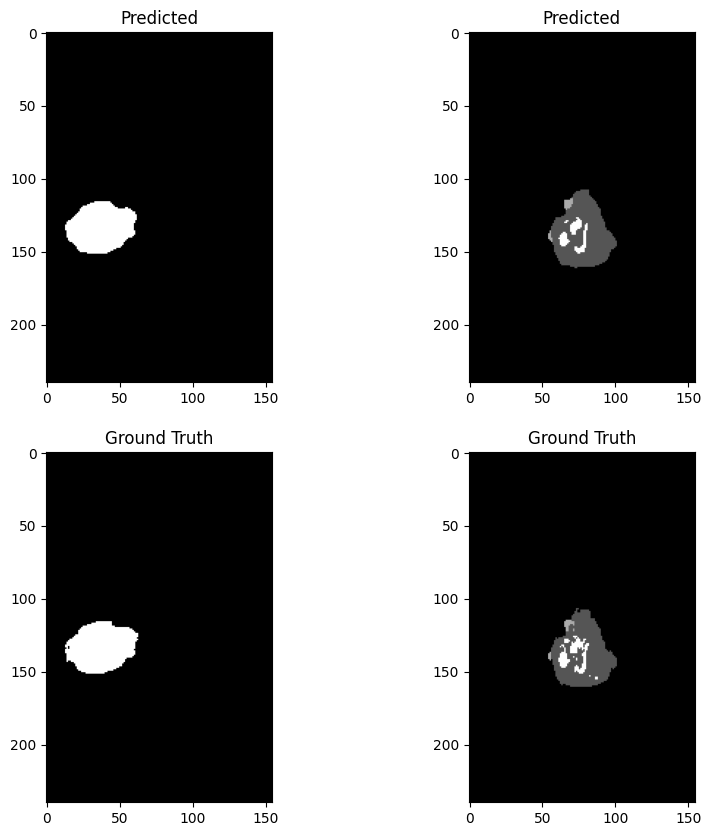

100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Average Validation Loss: 0.010368628454778124

Average Validation DSC: [0.9990016  0.88952137 0.92293603 0.79984924]
Average Validation ASSD: [ 0.09936336 19.02056399 16.14355511 15.52559675]
Epoch 56/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


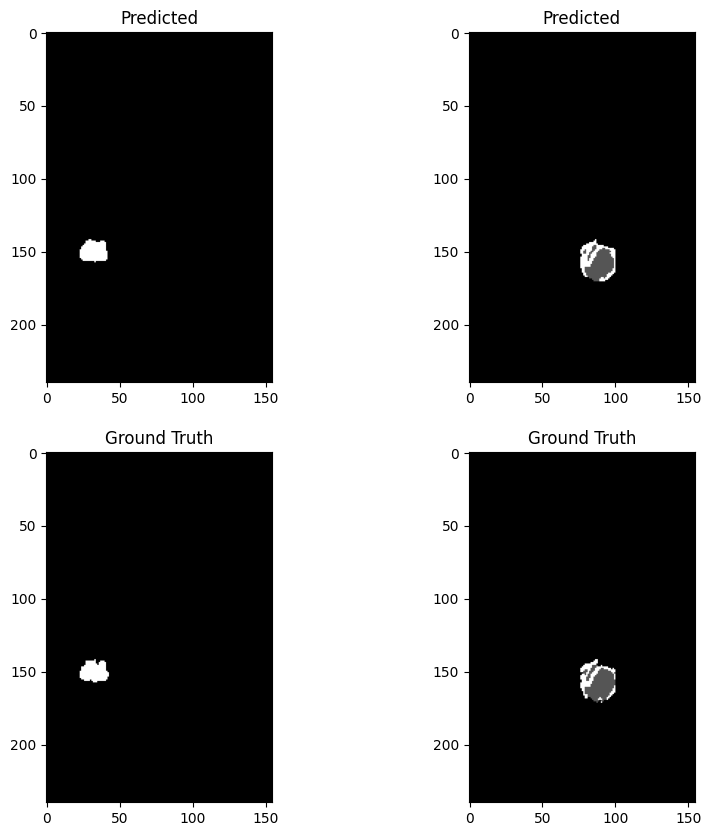

100%|██████████| 202/202 [07:02<00:00,  2.09s/it]



Average Training Loss: 0.00501356237120742

Average Training DSC: [0.99940334 0.94889253 0.95531725 0.85063709]
Average Training ASSD: [ 0.05410832  3.67325404  6.04408817 16.98072047]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


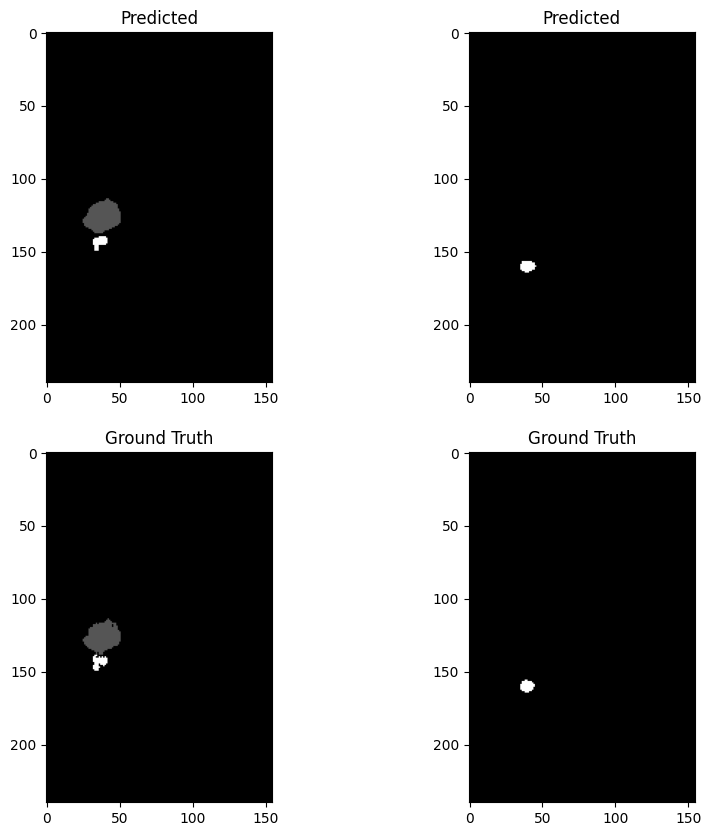

100%|██████████| 51/51 [01:18<00:00,  1.54s/it]


Average Validation Loss: 0.010690302661090506

Average Validation DSC: [0.99901225 0.89278778 0.92381574 0.80735169]
Average Validation ASSD: [ 0.09935214 17.50314055 14.40892891 13.65488909]
Epoch 57/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


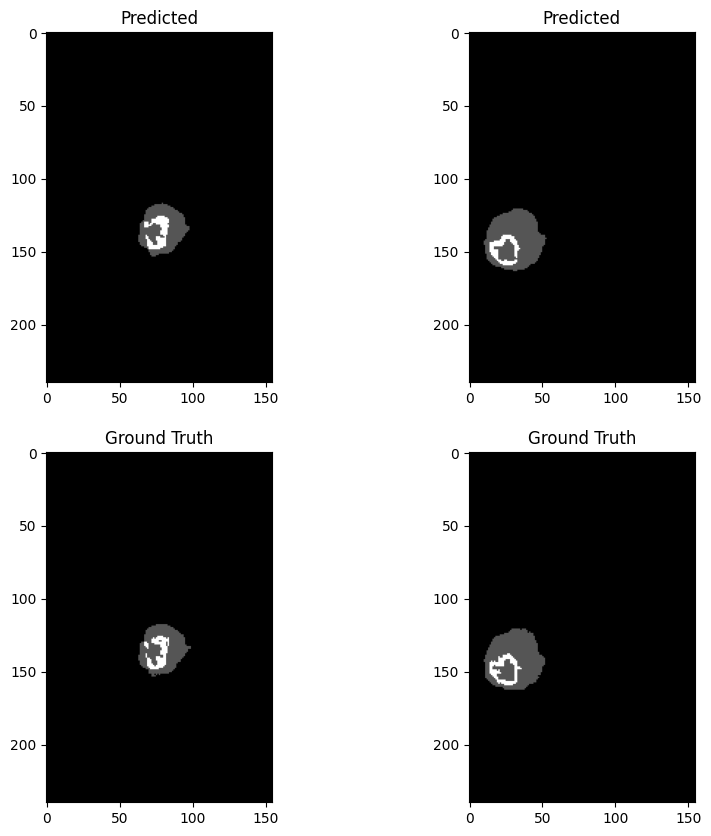

100%|██████████| 202/202 [06:56<00:00,  2.06s/it]



Average Training Loss: 0.005168453983888768

Average Training DSC: [0.99937922 0.94659074 0.95134844 0.8491598 ]
Average Training ASSD: [ 0.05606981  4.35026631  7.54044465 17.18309426]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


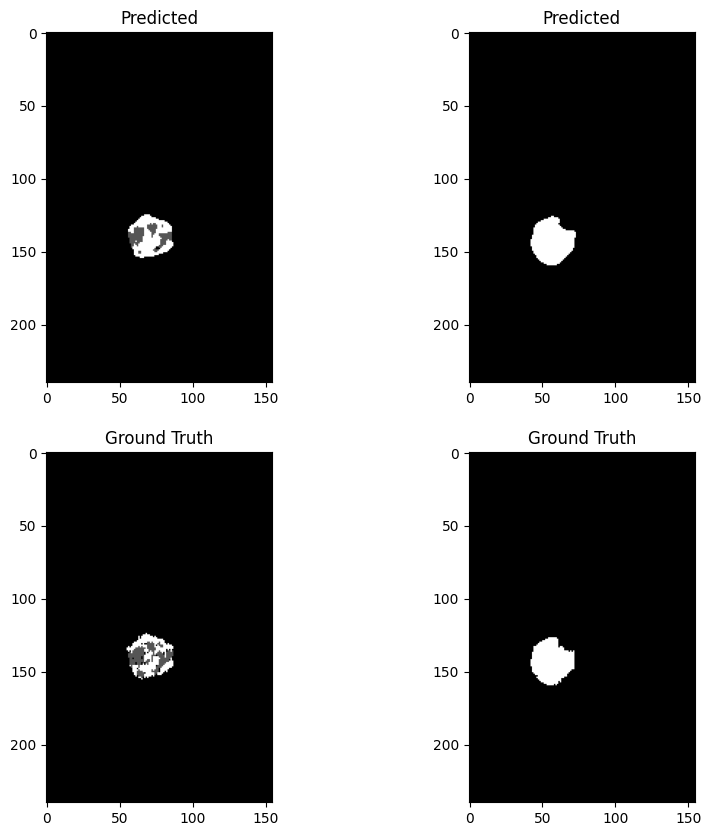

100%|██████████| 51/51 [01:17<00:00,  1.51s/it]


Average Validation Loss: 0.010391091434832881

Average Validation DSC: [0.99902103 0.87911649 0.92327537 0.80257449]
Average Validation ASSD: [ 0.09538653 23.40523846 14.67989016 14.64786844]
Epoch 58/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


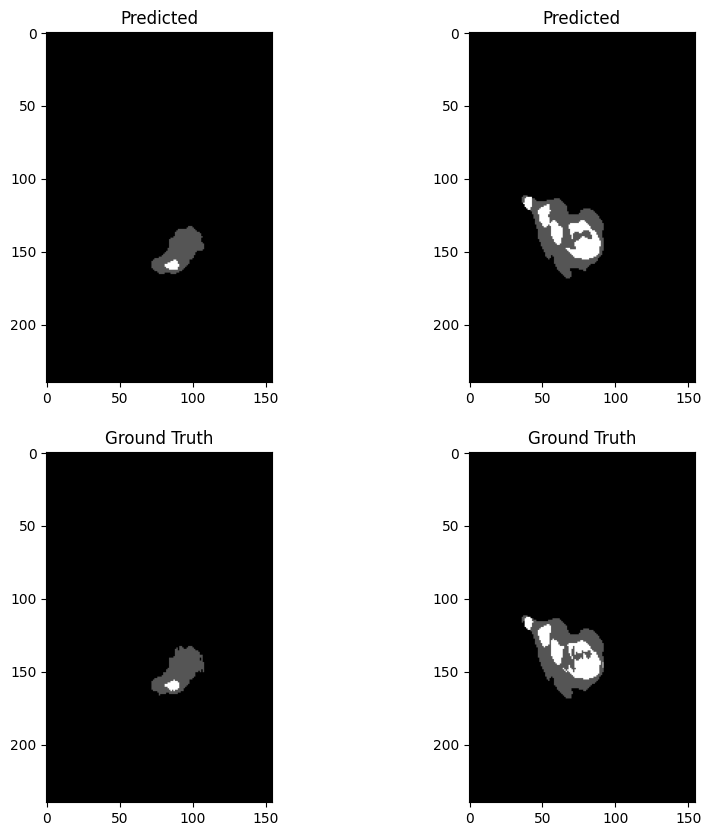

100%|██████████| 202/202 [06:55<00:00,  2.06s/it]



Average Training Loss: 0.005116574991826374

Average Training DSC: [0.99938933 0.94667893 0.9509902  0.85279081]
Average Training ASSD: [ 0.05467548  4.19983388  6.87968477 15.84097121]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


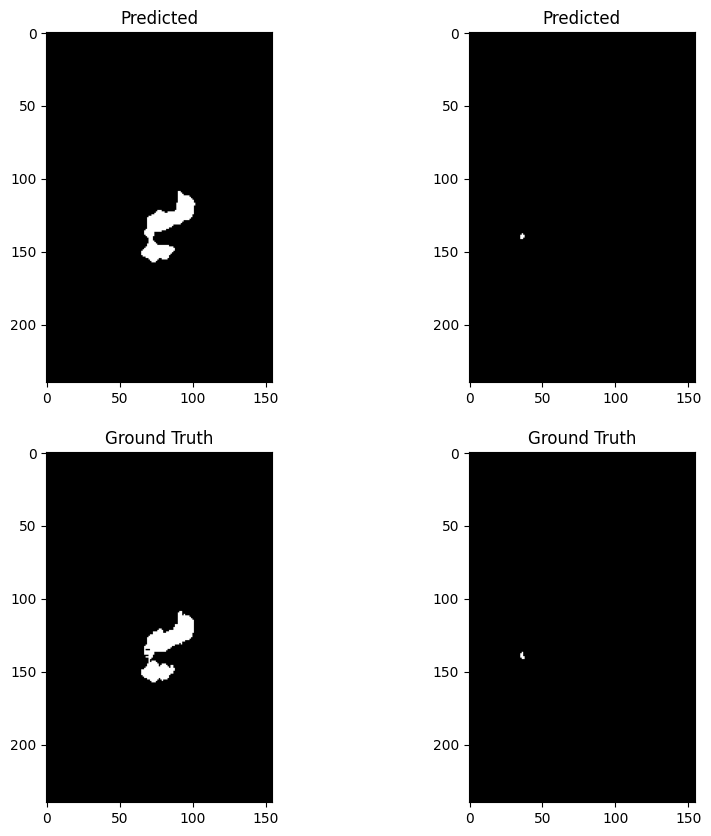

100%|██████████| 51/51 [01:15<00:00,  1.47s/it]


Average Validation Loss: 0.01115670602074733

Average Validation DSC: [0.99895541 0.87123917 0.91182112 0.80143329]
Average Validation ASSD: [ 0.1034853  24.93212285 17.36942444 15.2606835 ]
Epoch 59/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


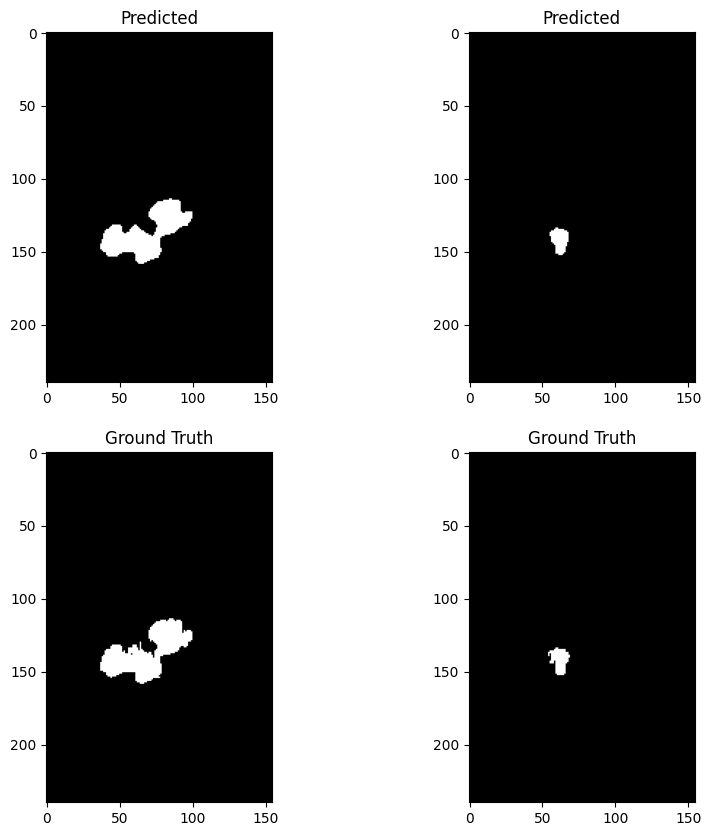

100%|██████████| 202/202 [06:59<00:00,  2.08s/it]



Average Training Loss: 0.005503119217314859

Average Training DSC: [0.99936681 0.93740798 0.95018349 0.8437335 ]
Average Training ASSD: [ 0.05696417  6.76468602  7.48015331 15.27034151]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


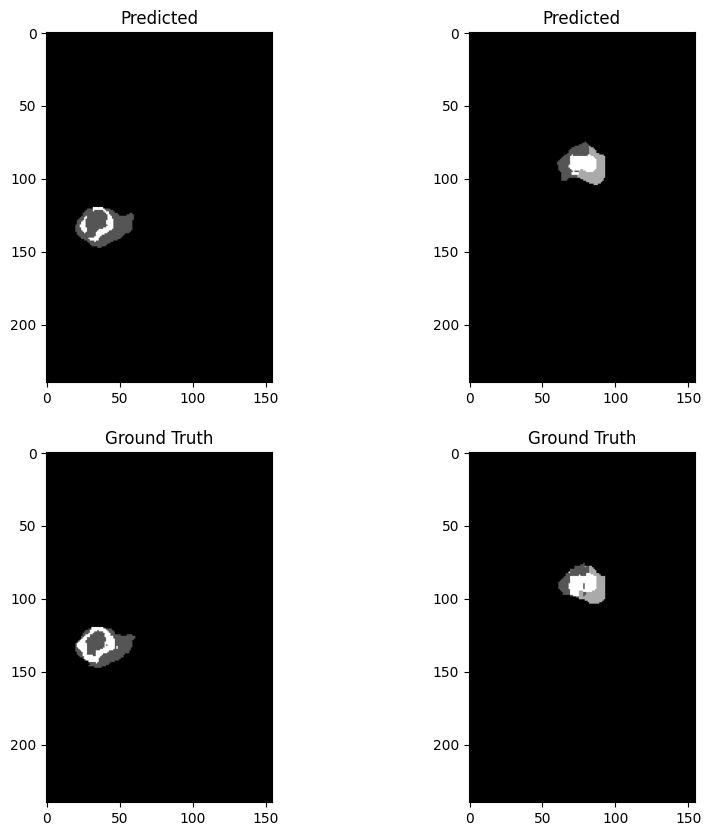

100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Average Validation Loss: 0.011974911141556268

Average Validation DSC: [0.99889347 0.7808442  0.88625051 0.7453087 ]
Average Validation ASSD: [ 0.12243205 53.96404193 27.47798596 22.09578009]
Epoch 60/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


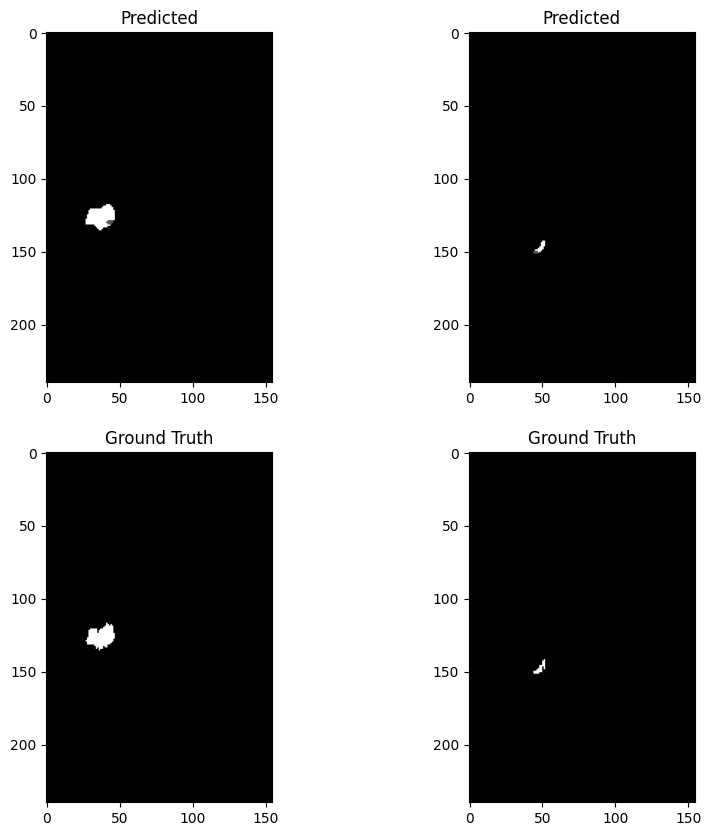

100%|██████████| 202/202 [07:01<00:00,  2.09s/it]



Average Training Loss: 0.005856469172136028

Average Training DSC: [0.9992964  0.9283851  0.94359349 0.83747964]
Average Training ASSD: [ 0.0655357   9.16496636  9.6044987  15.23494908]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


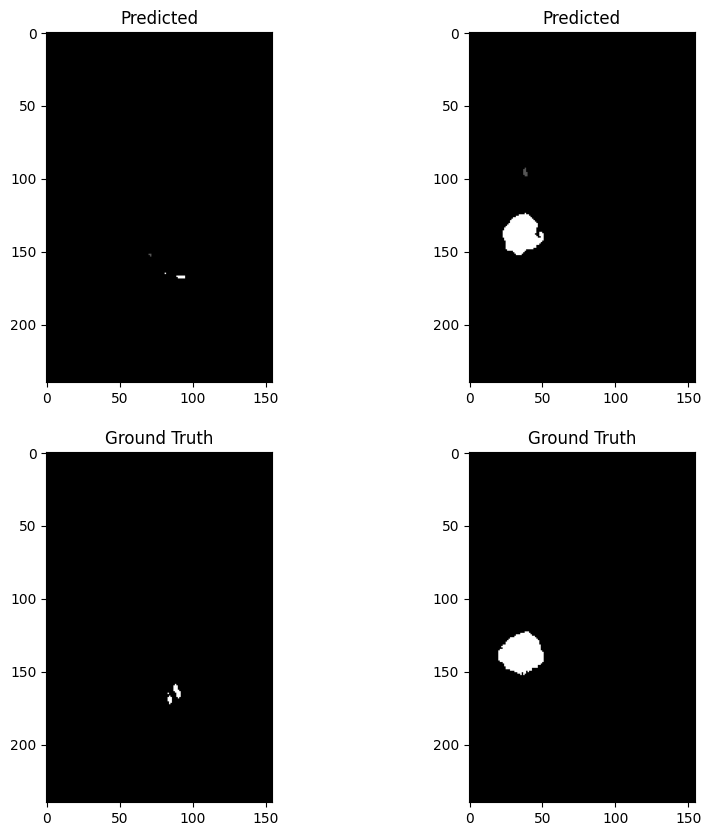

100%|██████████| 51/51 [01:14<00:00,  1.45s/it]


Average Validation Loss: 0.021091858034624773

Average Validation DSC: [0.99789348 0.79336447 0.87041973 0.67086666]
Average Validation ASSD: [ 0.24106899 33.93370267 27.98317078 24.50068556]
Epoch 61/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


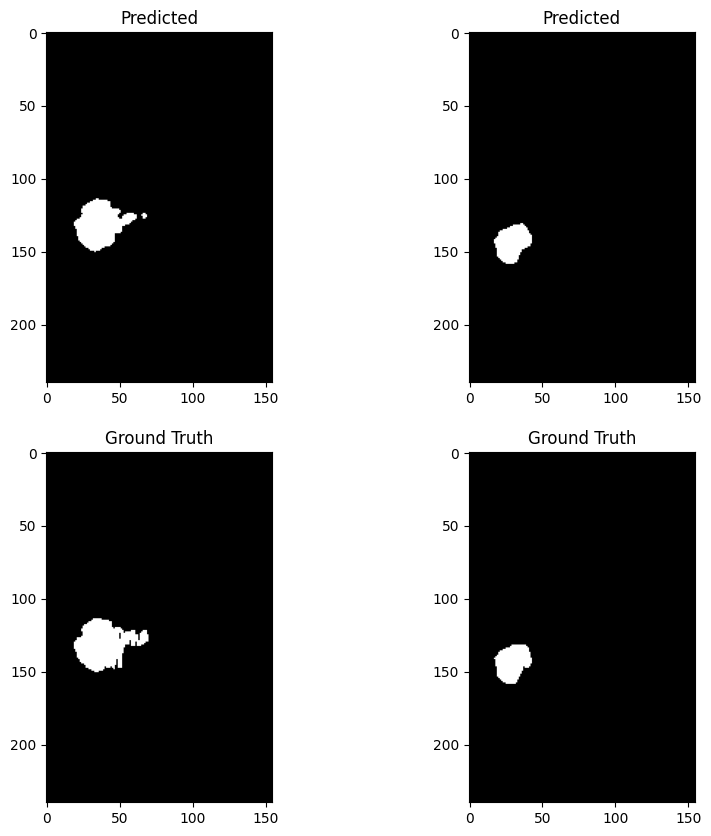

100%|██████████| 202/202 [07:02<00:00,  2.09s/it]



Average Training Loss: 0.011058517517337557

Average Training DSC: [0.99874373 0.84441607 0.89421239 0.75545412]
Average Training ASSD: [ 0.13889115 29.33825311 21.85156429 19.46801536]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


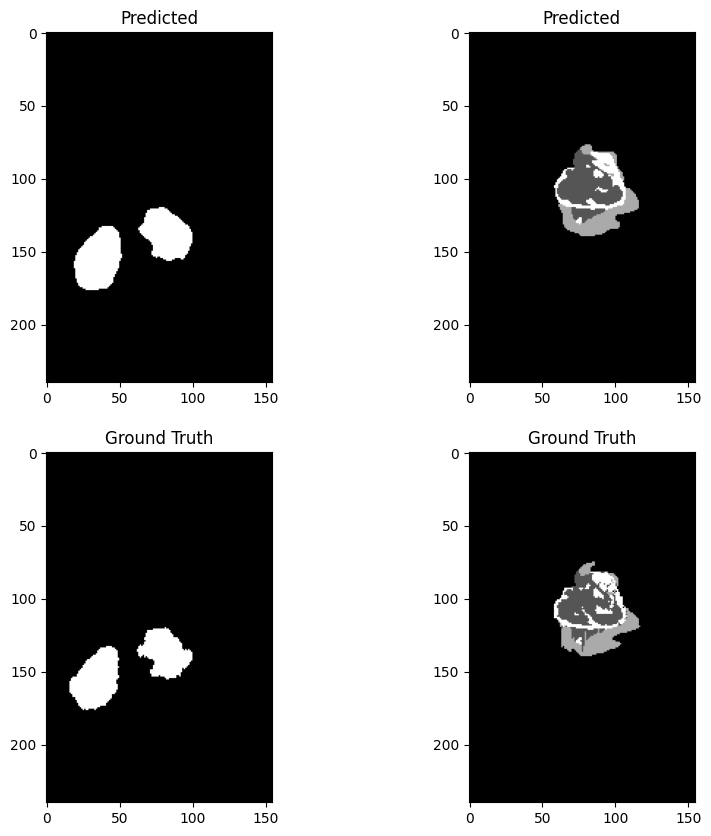

100%|██████████| 51/51 [01:19<00:00,  1.55s/it]


Average Validation Loss: 0.022646654178114498

Average Validation DSC: [0.99775072 0.75692353 0.83560073 0.68809811]
Average Validation ASSD: [ 0.22790059 39.93721752 31.80413503 11.51216486]
Epoch 62/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


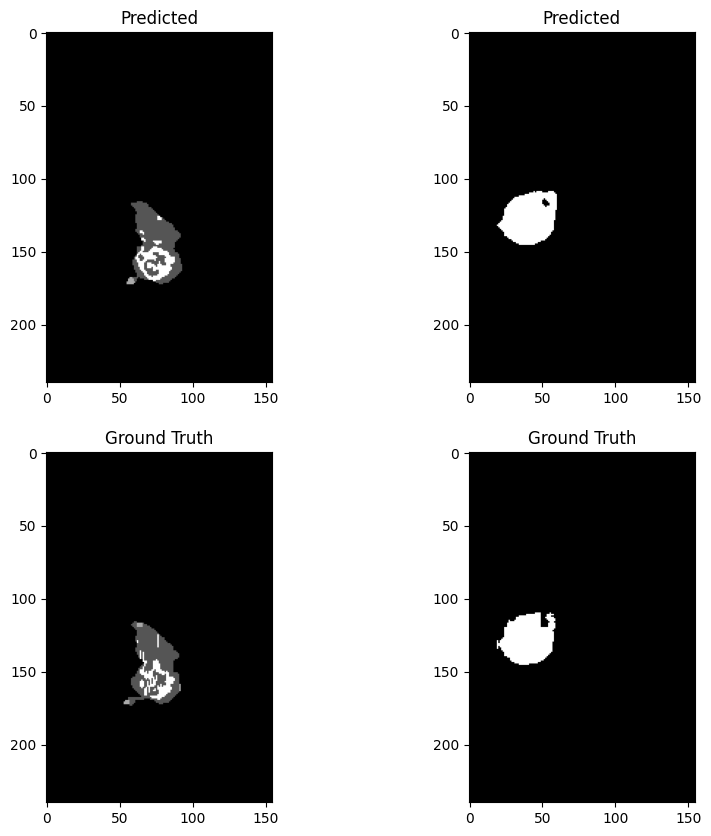

100%|██████████| 202/202 [07:01<00:00,  2.09s/it]



Average Training Loss: 0.008212212310633668

Average Training DSC: [0.99907056 0.89344552 0.92597932 0.79605341]
Average Training ASSD: [ 0.09122579 17.64285014 13.82252985 18.83071905]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


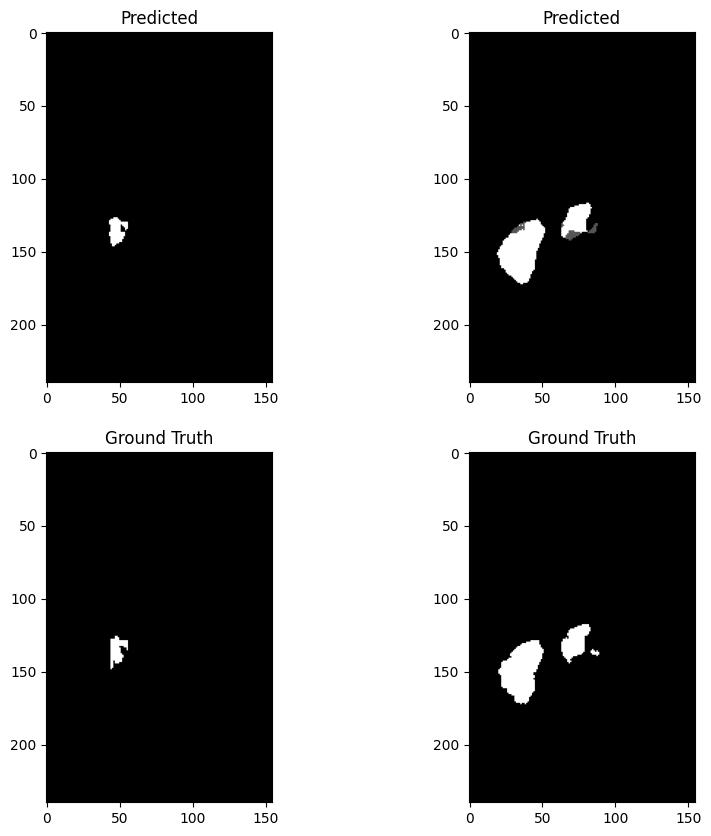

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.012100036602978613

Average Validation DSC: [0.99876479 0.82947679 0.90824029 0.7663996 ]
Average Validation ASSD: [ 0.12779511 37.40693294 18.82665904 18.92780419]
Epoch 63/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


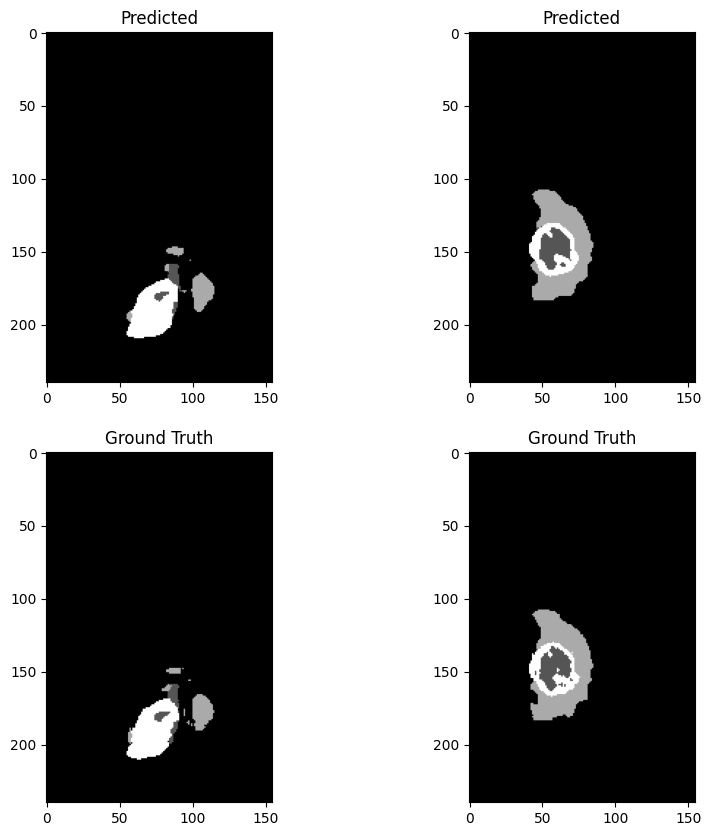

100%|██████████| 202/202 [06:58<00:00,  2.07s/it]



Average Training Loss: 0.006505777439250067

Average Training DSC: [0.99925648 0.92116744 0.94149141 0.82641994]
Average Training ASSD: [ 0.07064191 10.68406349  9.94248172 15.73364181]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


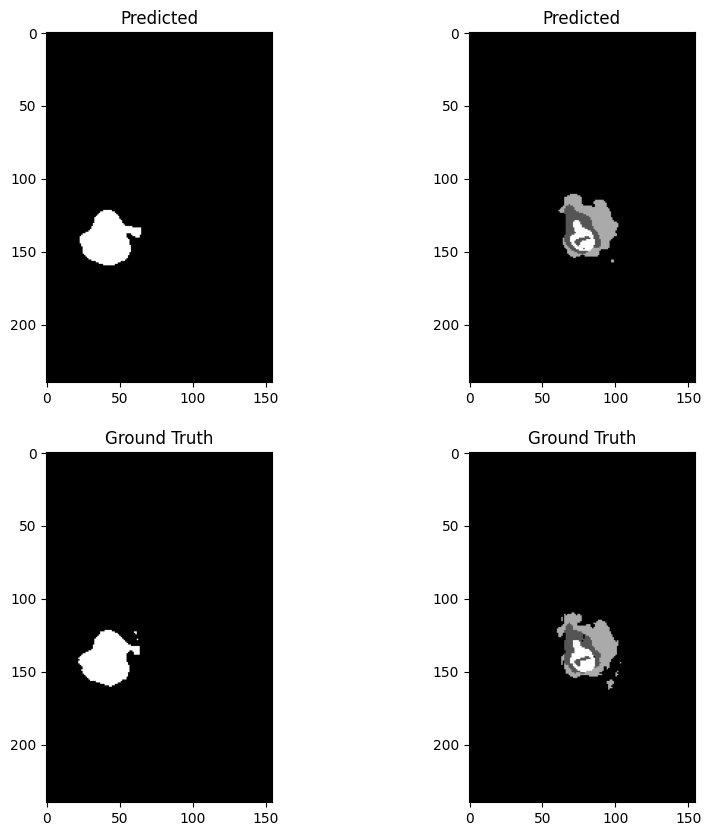

100%|██████████| 51/51 [01:15<00:00,  1.49s/it]


Average Validation Loss: 0.010706040725185006

Average Validation DSC: [0.99889582 0.86852346 0.93000121 0.77364838]
Average Validation ASSD: [ 0.11245541 24.57295547 12.3492395  20.12871309]
Epoch 64/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


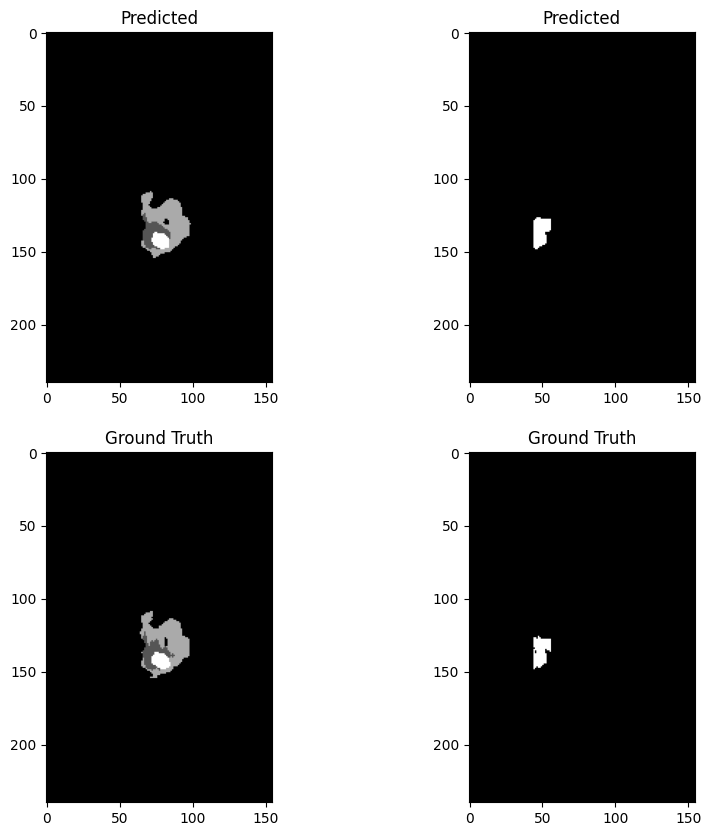

100%|██████████| 202/202 [06:58<00:00,  2.07s/it]



Average Training Loss: 0.0049259842829871

Average Training DSC: [0.9994254  0.94546784 0.95537595 0.85299282]
Average Training ASSD: [ 0.05152006  5.75224716  6.33931932 15.05672628]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


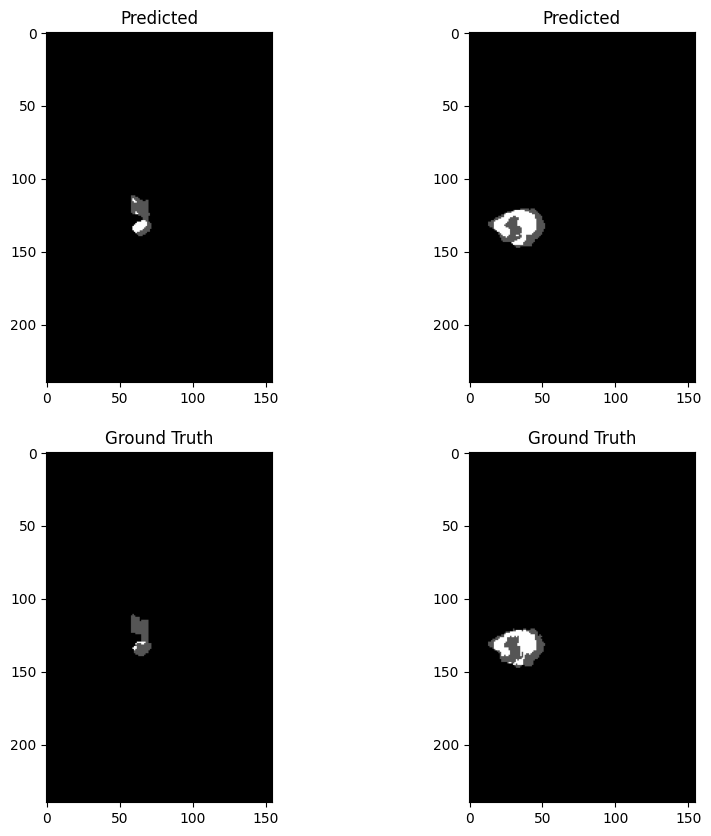

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.010714890371423726

Average Validation DSC: [0.99900178 0.88456481 0.92613803 0.79449176]
Average Validation ASSD: [ 0.10011798 15.21152122 13.76932922  7.64411726]
Epoch 65/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


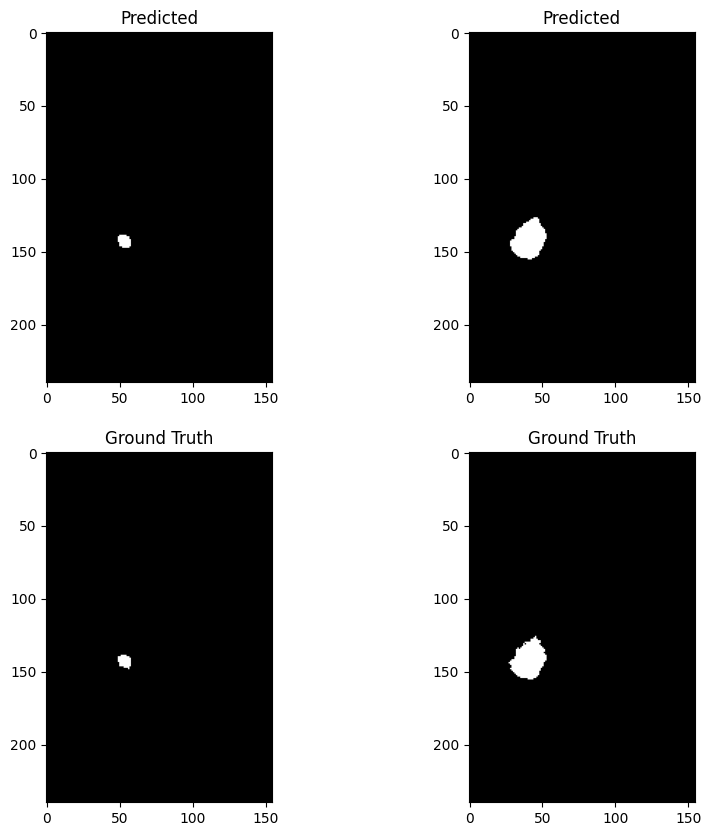

100%|██████████| 202/202 [07:07<00:00,  2.12s/it]



Average Training Loss: 0.004674360338174323

Average Training DSC: [0.9994707  0.95114064 0.9584931  0.85870047]
Average Training ASSD: [ 0.04674165  4.32012959  5.65426287 15.60609867]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


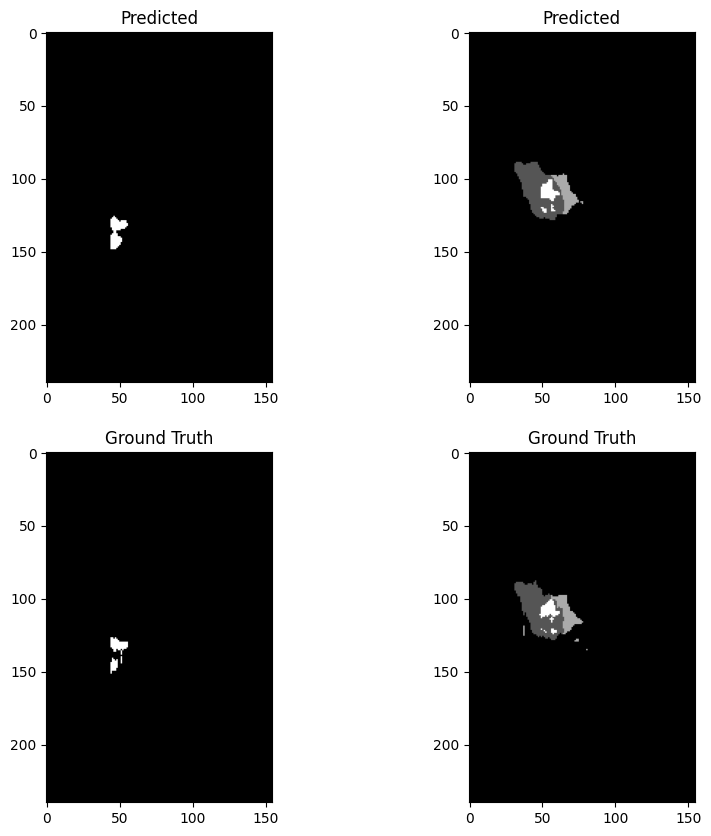

100%|██████████| 51/51 [01:14<00:00,  1.46s/it]


Average Validation Loss: 0.009642730750070484

Average Validation DSC: [0.99915894 0.90220554 0.934097   0.81744425]
Average Validation ASSD: [ 0.08619928 16.61716816 12.31296052 12.79703898]
Epoch 66/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


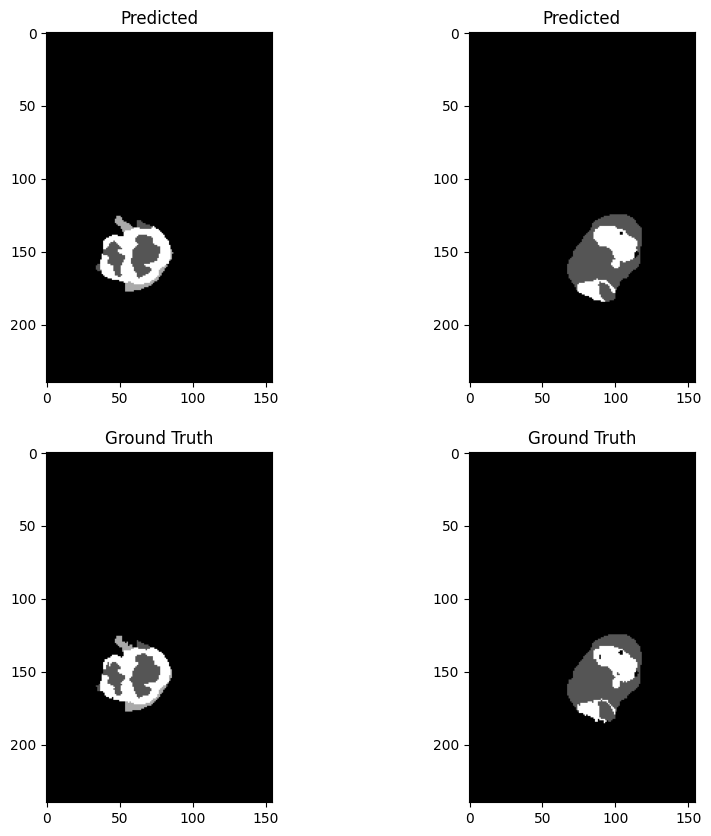

100%|██████████| 202/202 [07:05<00:00,  2.11s/it]



Average Training Loss: 0.004076822642421369

Average Training DSC: [0.99953162 0.9592124  0.96247121 0.87297265]
Average Training ASSD: [ 0.04026571  2.87293548  5.26653201 14.51613456]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


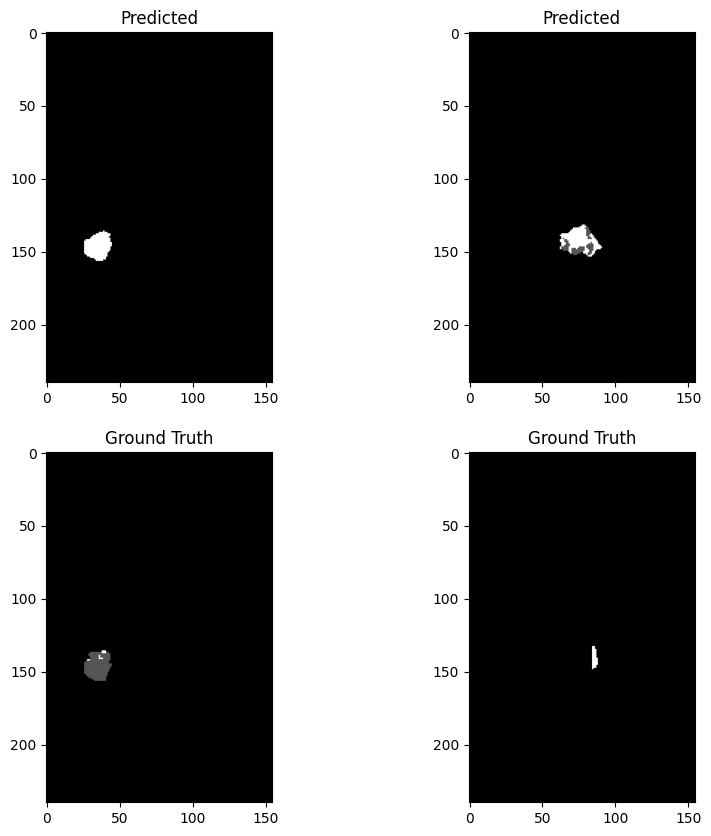

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.011335335589726181

Average Validation DSC: [0.99907957 0.89804264 0.93255009 0.81745076]
Average Validation ASSD: [ 0.0923756  15.45281197 12.83595316 10.91624324]
Epoch 67/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


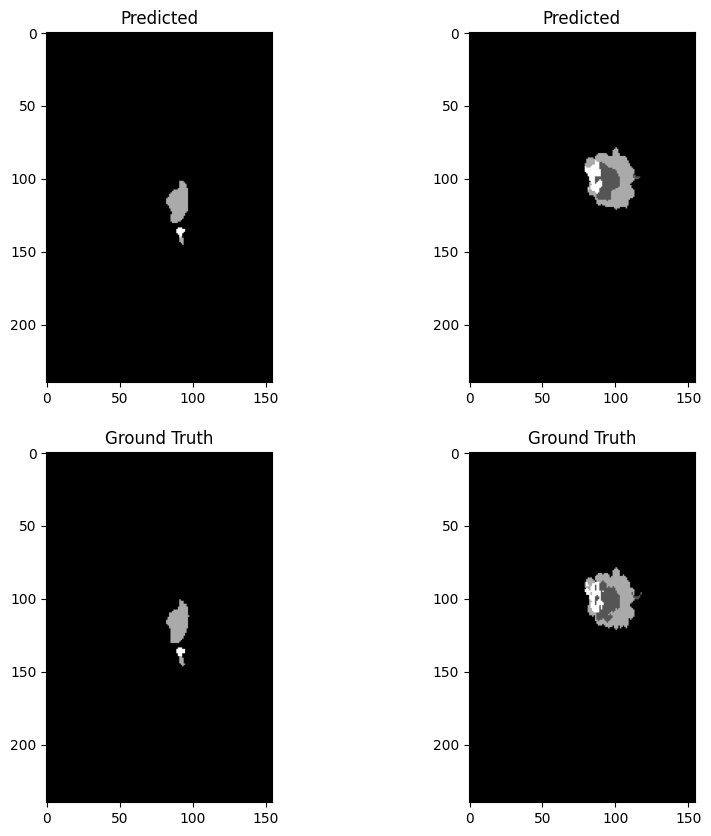

100%|██████████| 202/202 [07:07<00:00,  2.12s/it]



Average Training Loss: 0.003981126344412344

Average Training DSC: [0.99954182 0.96153853 0.96373247 0.87825597]
Average Training ASSD: [ 0.03987759  2.27384033  4.59446306 13.43848442]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


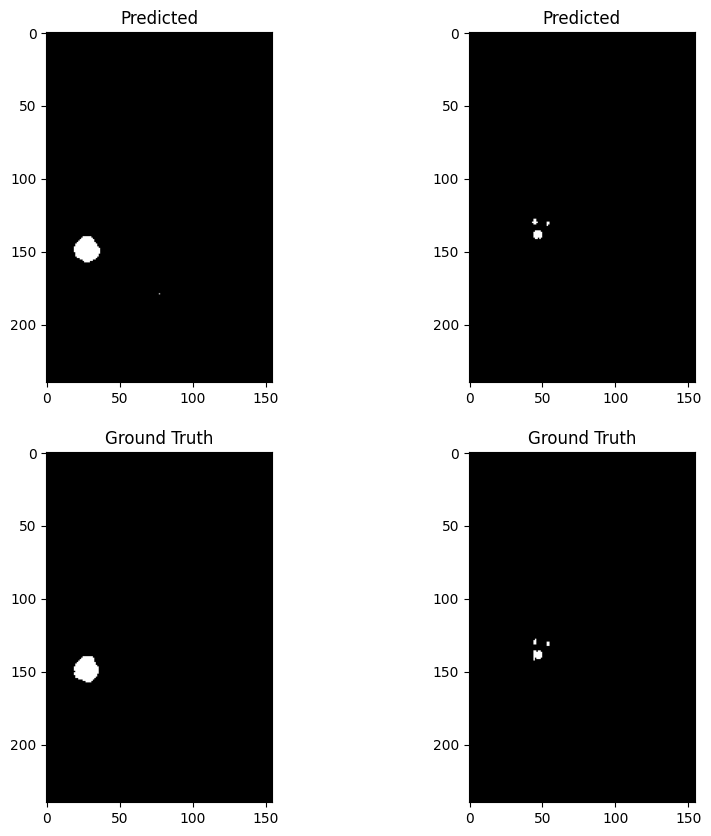

100%|██████████| 51/51 [01:17<00:00,  1.51s/it]


Average Validation Loss: 0.009675320402226028

Average Validation DSC: [0.99916906 0.90163912 0.93299168 0.82800233]
Average Validation ASSD: [ 0.08402388 17.69760176 13.15861848 11.63735417]
Epoch 68/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


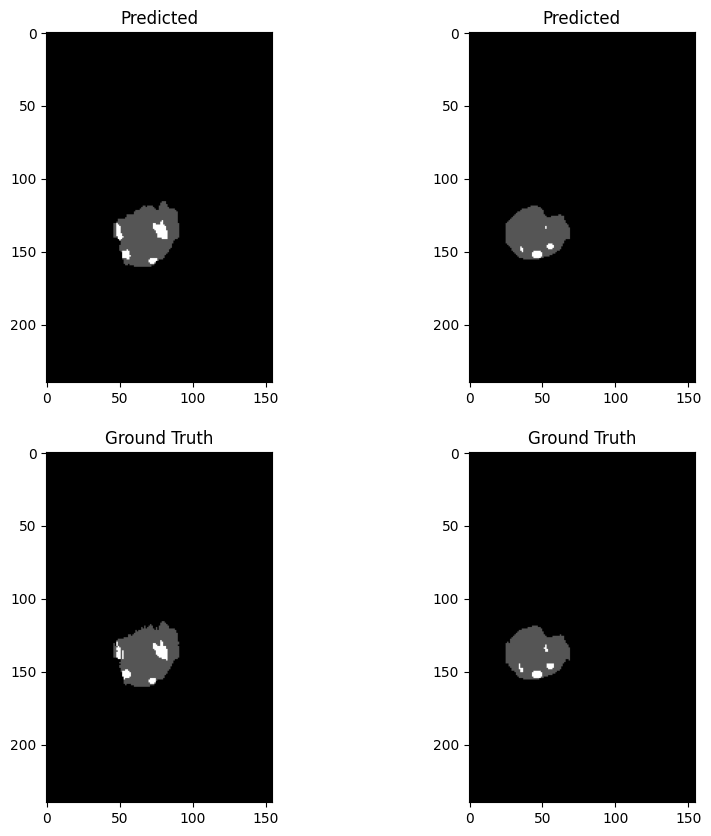

100%|██████████| 202/202 [07:10<00:00,  2.13s/it]



Average Training Loss: 0.0038228205665669377

Average Training DSC: [0.99955839 0.96416274 0.96316919 0.88361745]
Average Training ASSD: [ 0.03725395  1.59369534  4.81985187 12.36608226]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


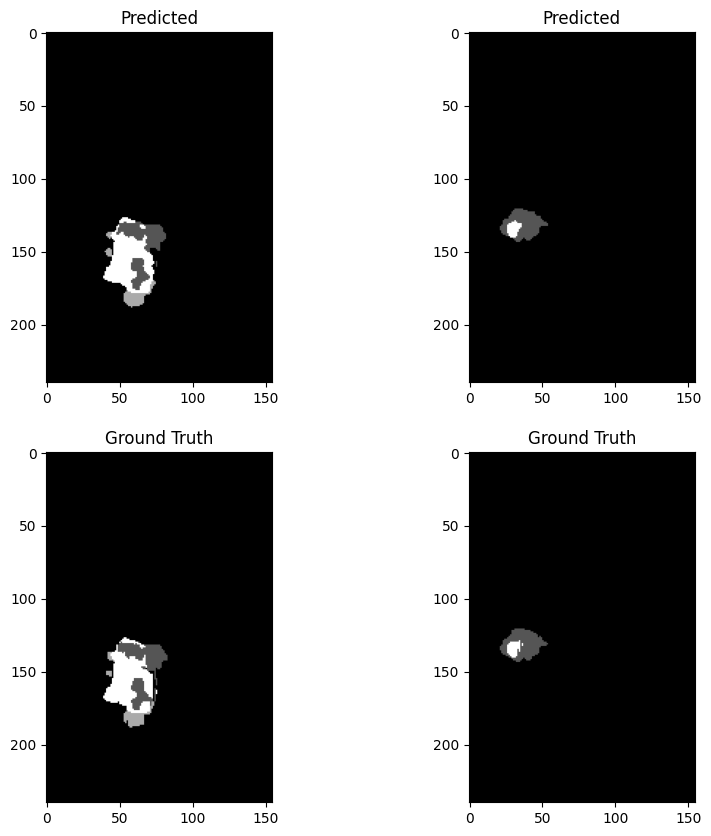

100%|██████████| 51/51 [01:14<00:00,  1.45s/it]


Average Validation Loss: 0.010037501534337507

Average Validation DSC: [0.99918432 0.90657665 0.936899   0.82605706]
Average Validation ASSD: [ 0.08449642 15.38016603 11.09120875 11.81769496]
Epoch 69/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


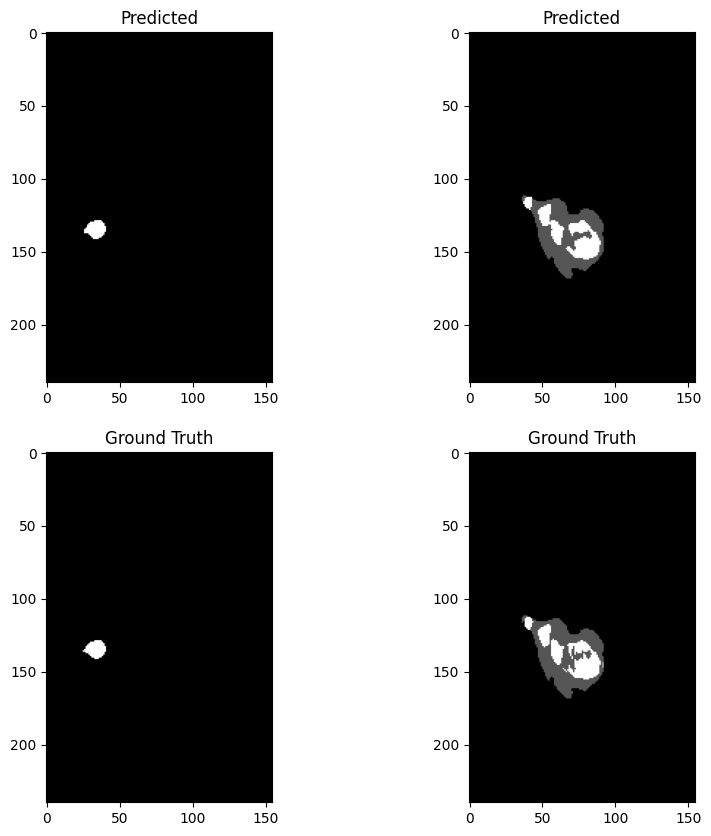

100%|██████████| 202/202 [06:57<00:00,  2.06s/it]



Average Training Loss: 0.0038098861799935007

Average Training DSC: [0.99955593 0.96365585 0.96409653 0.88325042]
Average Training ASSD: [ 0.03801639  1.89180539  4.59918451 12.59574959]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


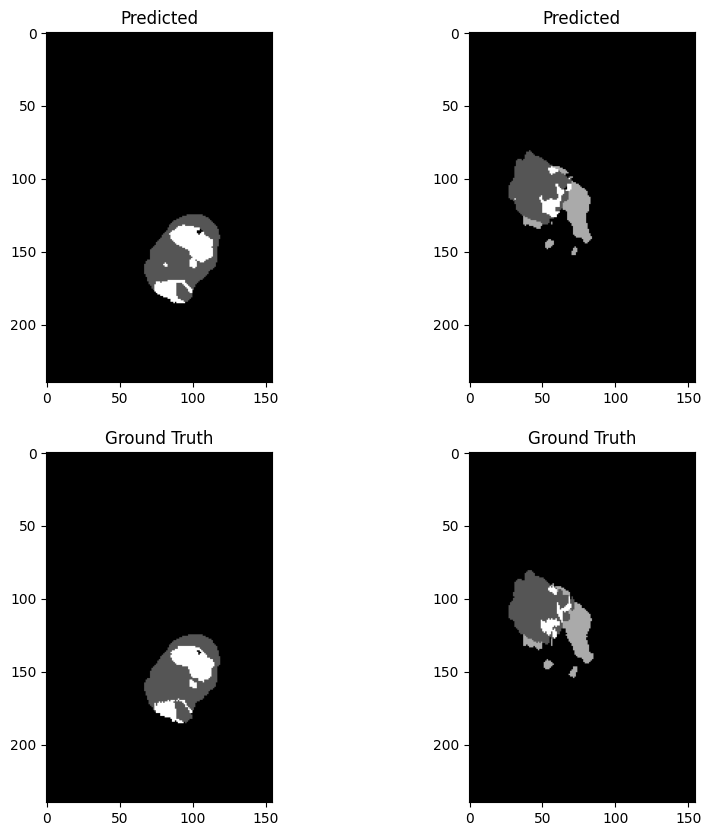

100%|██████████| 51/51 [01:14<00:00,  1.47s/it]


Average Validation Loss: 0.009982532182452725

Average Validation DSC: [0.99918302 0.9039495  0.93726056 0.83158707]
Average Validation ASSD: [ 0.08360853 16.02121158 11.18597386  9.24875787]
Epoch 70/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


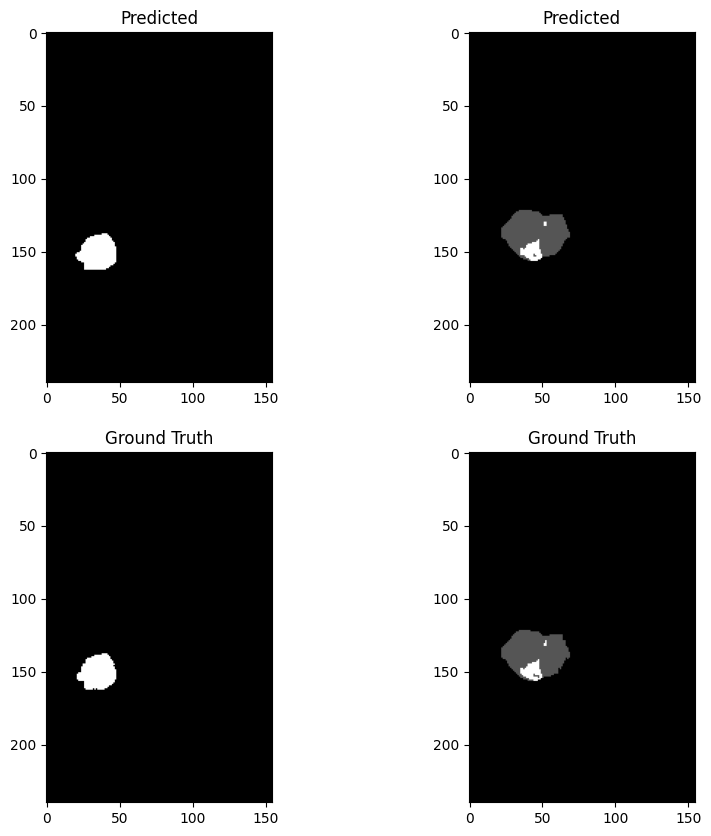

100%|██████████| 202/202 [07:03<00:00,  2.10s/it]



Average Training Loss: 0.0037647000154351243

Average Training DSC: [0.99956525 0.96236023 0.96190485 0.88897041]
Average Training ASSD: [ 0.03656699  2.63516044  5.26434941 11.03176542]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


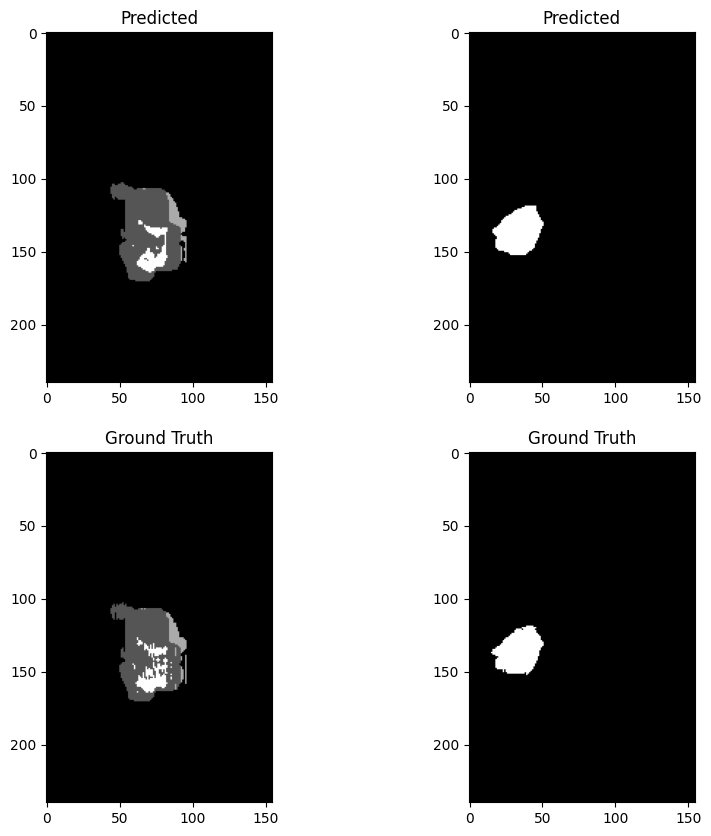

100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Average Validation Loss: 0.010089573249513028

Average Validation DSC: [0.99916594 0.89776817 0.93109859 0.82130713]
Average Validation ASSD: [ 0.08611728 18.37628357 12.5252846  11.24830672]
Epoch 71/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


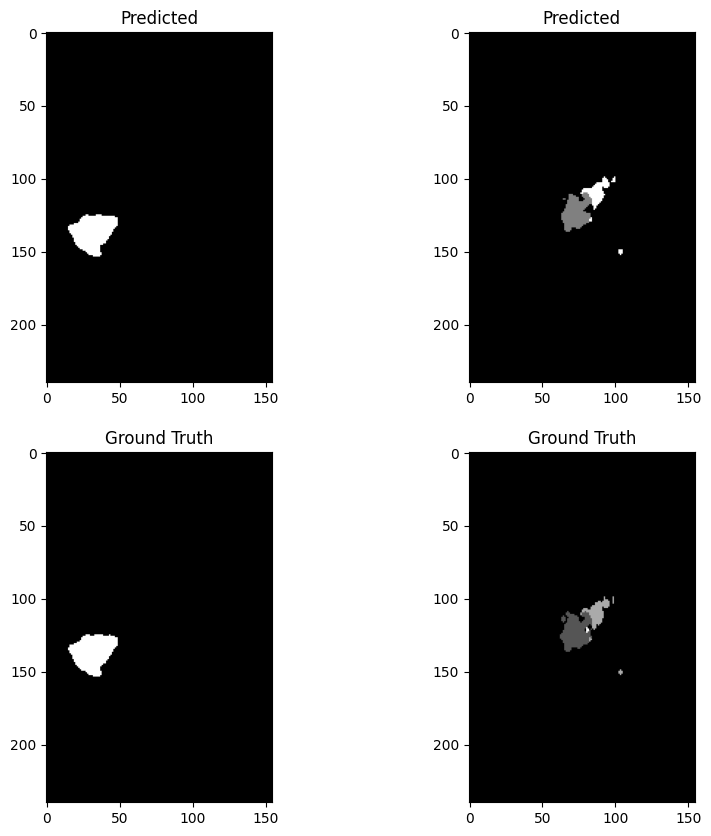

100%|██████████| 202/202 [07:14<00:00,  2.15s/it]



Average Training Loss: 0.003824100465430777

Average Training DSC: [0.99955918 0.96148353 0.96240333 0.88484853]
Average Training ASSD: [ 0.03762762  2.2720489   5.33070682 11.20720283]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


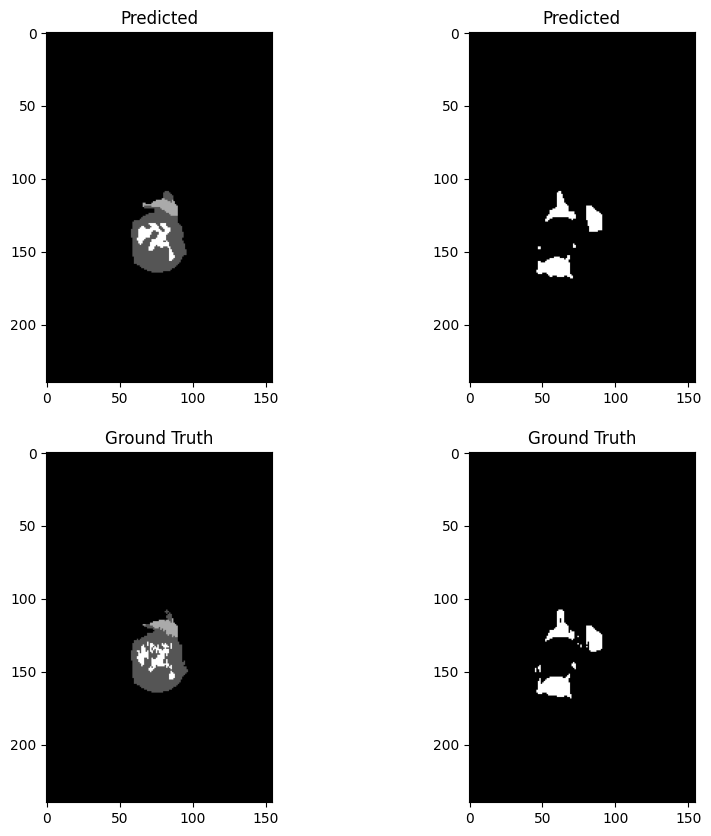

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.010129873138651544

Average Validation DSC: [0.99916122 0.89773961 0.93450603 0.82944502]
Average Validation ASSD: [ 0.08493768 16.63435167 11.38431235  8.44788403]
Epoch 72/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


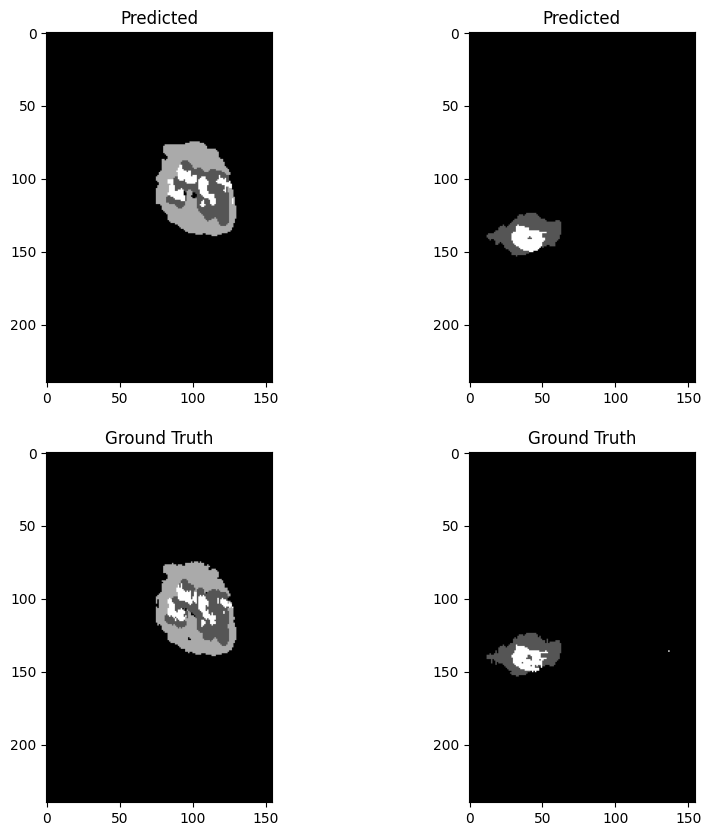

100%|██████████| 202/202 [07:08<00:00,  2.12s/it]



Average Training Loss: 0.0037337060727289702

Average Training DSC: [0.99957095 0.9634524  0.96237658 0.88646683]
Average Training ASSD: [ 0.03582503  2.11168331  5.26312929 11.05676344]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


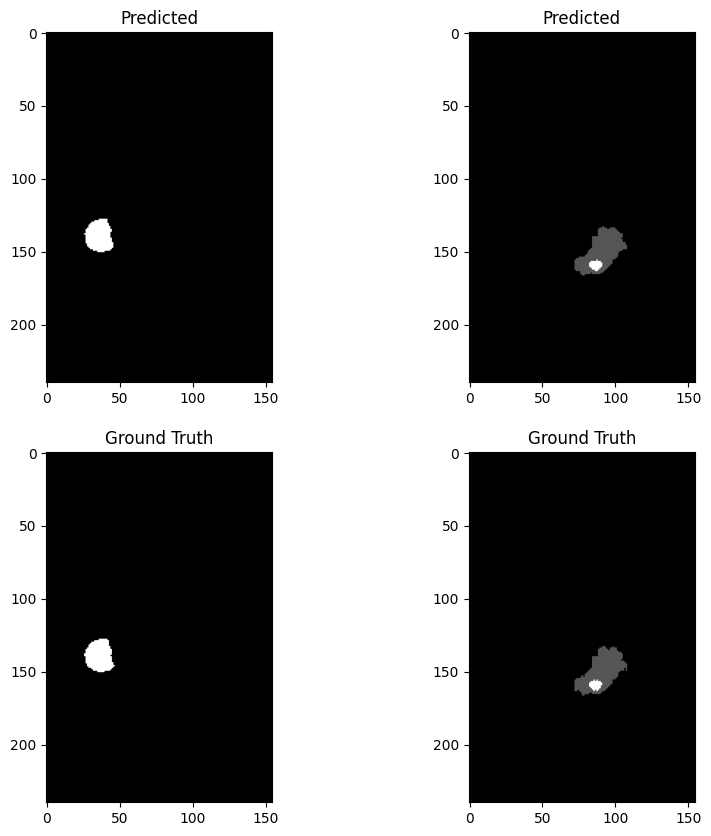

100%|██████████| 51/51 [01:20<00:00,  1.57s/it]


Average Validation Loss: 0.00993612483509031

Average Validation DSC: [0.99918283 0.90581922 0.93097772 0.83845721]
Average Validation ASSD: [ 0.0854583  15.96125444 13.53894153  8.29593546]
Epoch 73/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


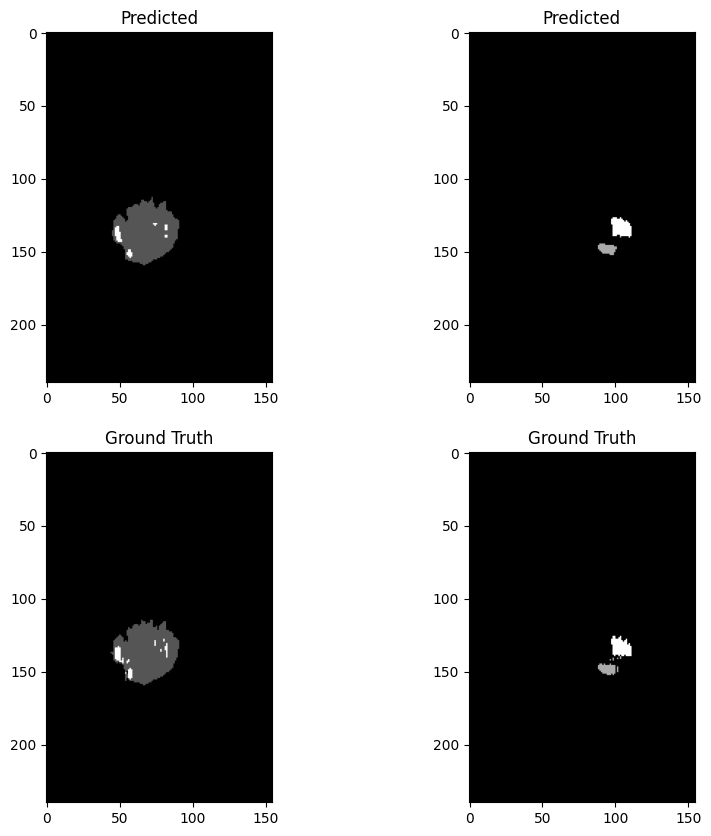

100%|██████████| 202/202 [07:10<00:00,  2.13s/it]



Average Training Loss: 0.003735166603796147

Average Training DSC: [0.99956705 0.96143354 0.96329174 0.8896909 ]
Average Training ASSD: [ 0.03656111  2.63211459  5.03701982 10.75627485]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


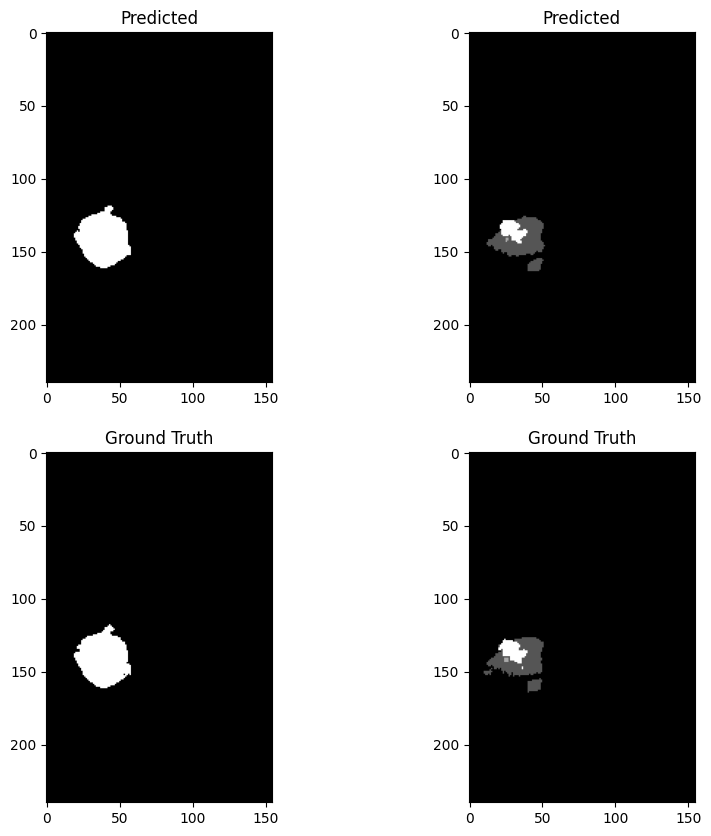

100%|██████████| 51/51 [01:15<00:00,  1.47s/it]


Average Validation Loss: 0.010516363415209687

Average Validation DSC: [0.99917208 0.89722766 0.93594867 0.82677193]
Average Validation ASSD: [ 0.08395817 15.43064549 10.53070547  7.06710469]
Epoch 74/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


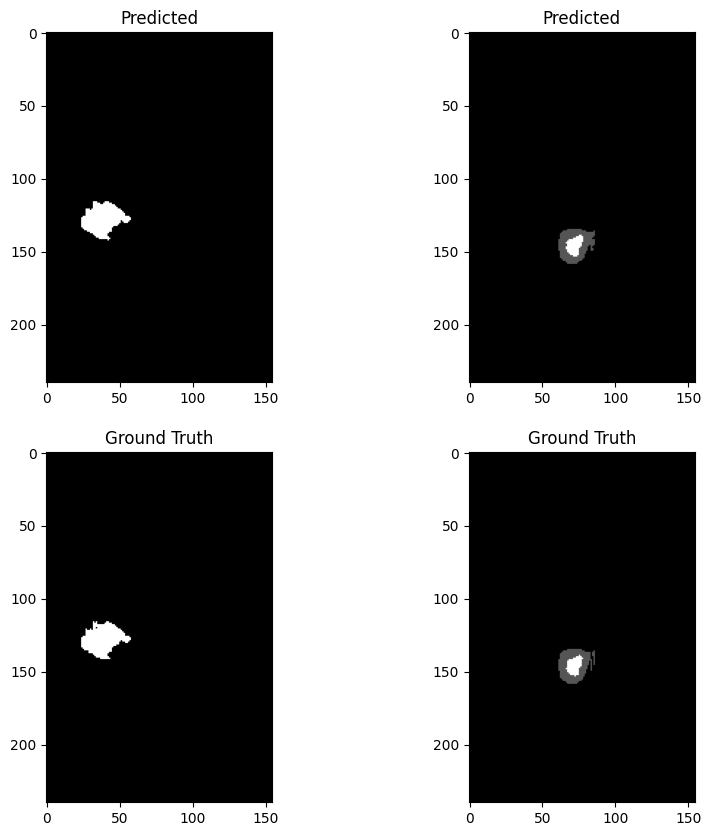

100%|██████████| 202/202 [07:12<00:00,  2.14s/it]



Average Training Loss: 0.0036539888564995167

Average Training DSC: [0.99957266 0.9629299  0.96380904 0.89135831]
Average Training ASSD: [ 0.03646909  2.33346985  5.03454787 10.66958352]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


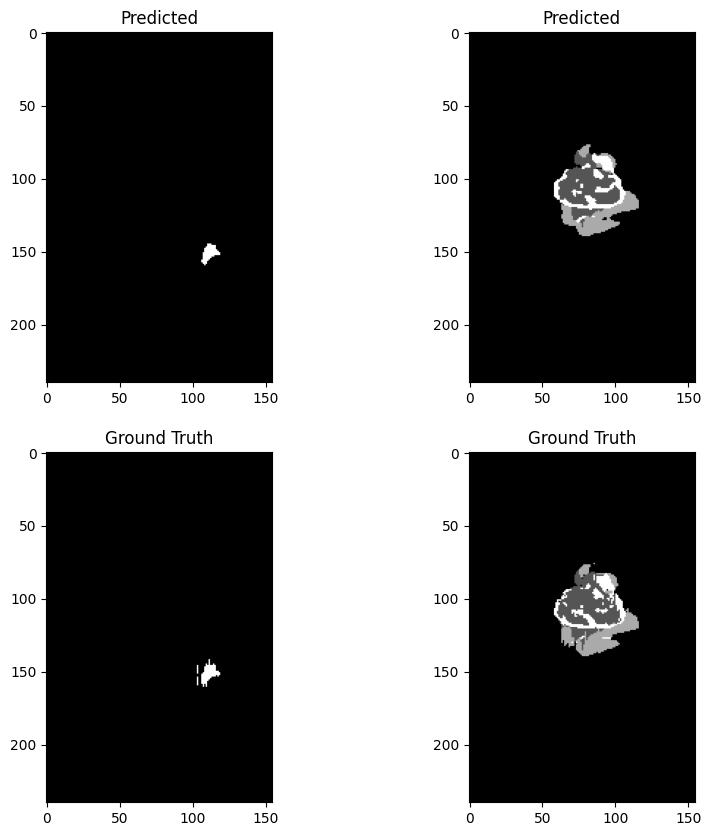

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.010255880863862294

Average Validation DSC: [0.99918092 0.90434692 0.9349353  0.83136886]
Average Validation ASSD: [ 0.08462527 15.91872565 12.35326084 10.74528605]
Epoch 75/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


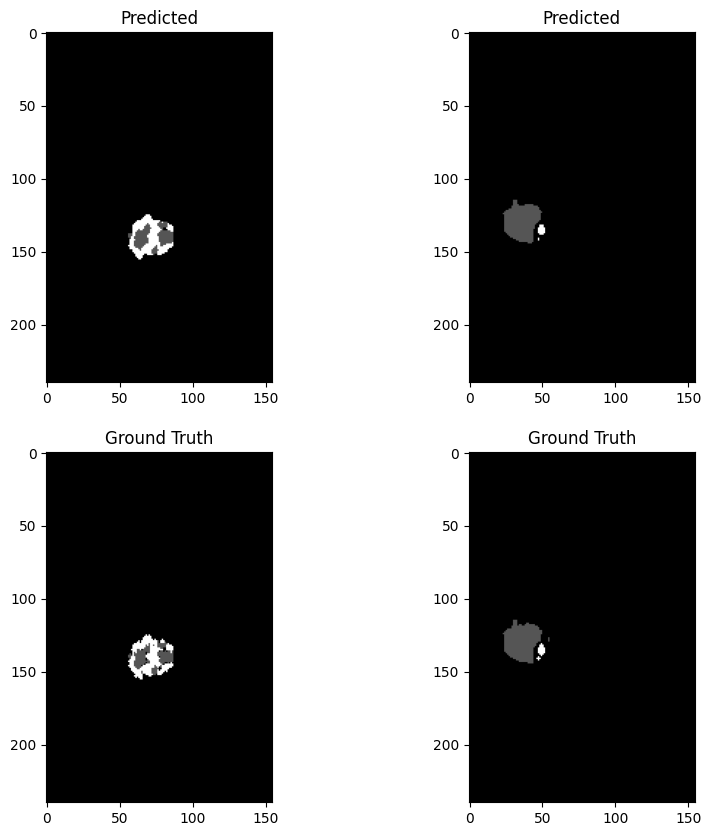

100%|██████████| 202/202 [06:56<00:00,  2.06s/it]



Average Training Loss: 0.003556742176694777

Average Training DSC: [0.99958238 0.96366407 0.96366456 0.89471244]
Average Training ASSD: [0.03507774 2.62428275 5.25734658 9.76107058]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


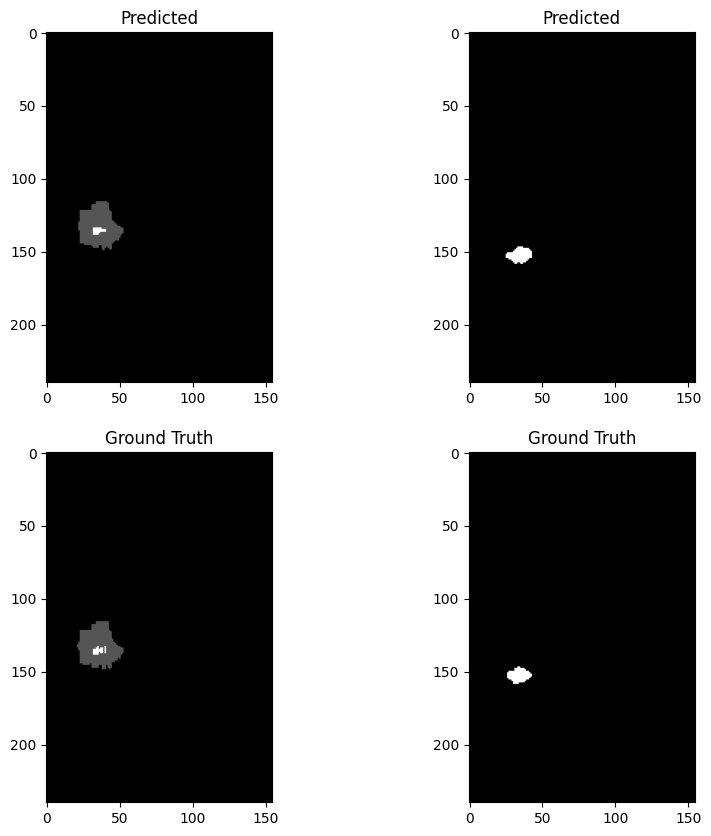

100%|██████████| 51/51 [01:14<00:00,  1.45s/it]


Average Validation Loss: 0.010538096293149626

Average Validation DSC: [0.99914672 0.89913223 0.93693969 0.83172068]
Average Validation ASSD: [ 0.08795294 17.44050916 10.89623205  8.30471135]
Epoch 76/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


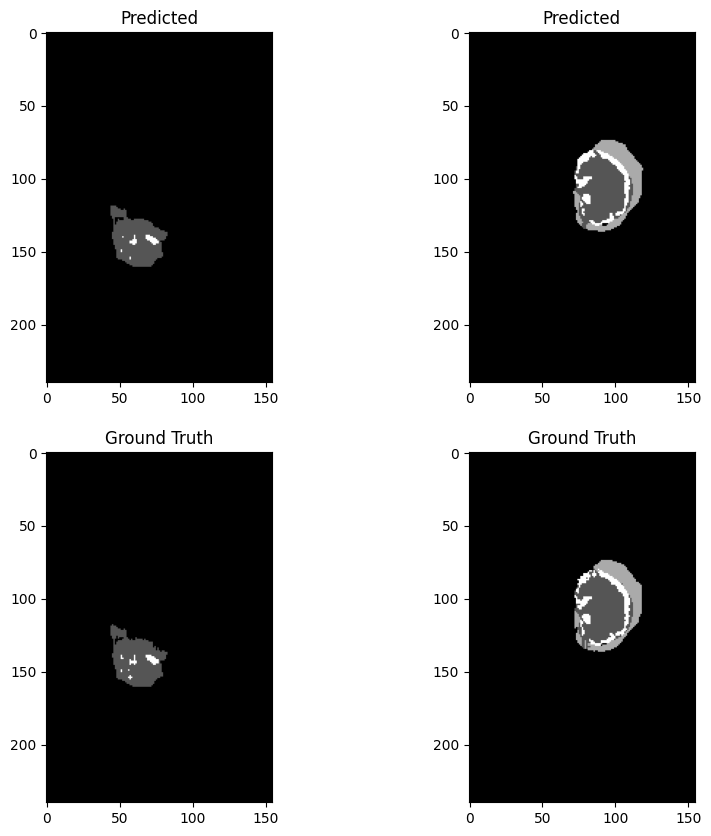

100%|██████████| 202/202 [07:06<00:00,  2.11s/it]



Average Training Loss: 0.0035063767964758053

Average Training DSC: [0.9995972  0.96387602 0.96543836 0.89587858]
Average Training ASSD: [0.03355939 2.47378207 4.43696721 9.37035916]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


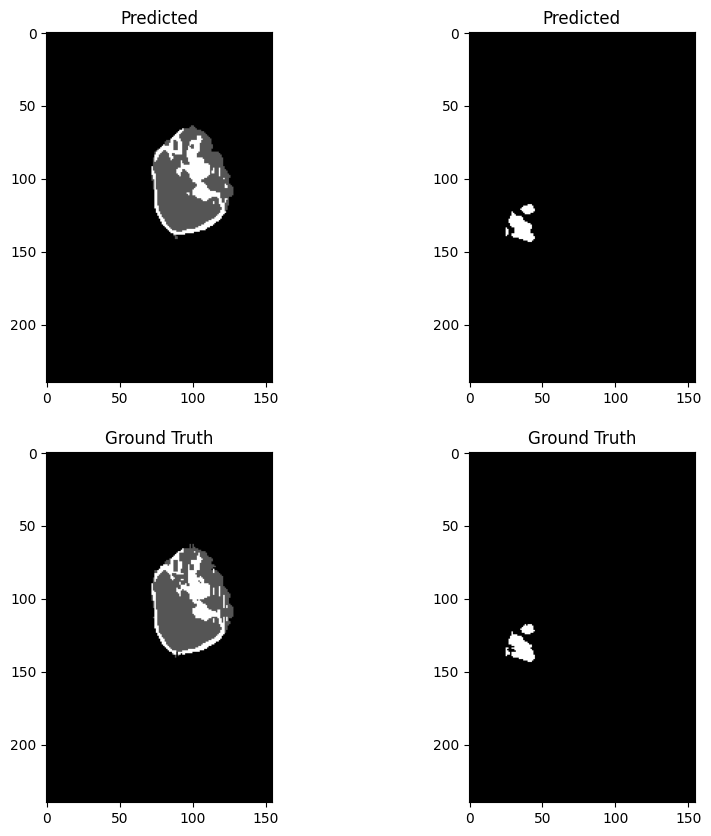

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.010361128304080636

Average Validation DSC: [0.99919316 0.89898551 0.93592938 0.83199556]
Average Validation ASSD: [ 0.08370976 18.04303326 12.33600865  8.98511392]
Epoch 77/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


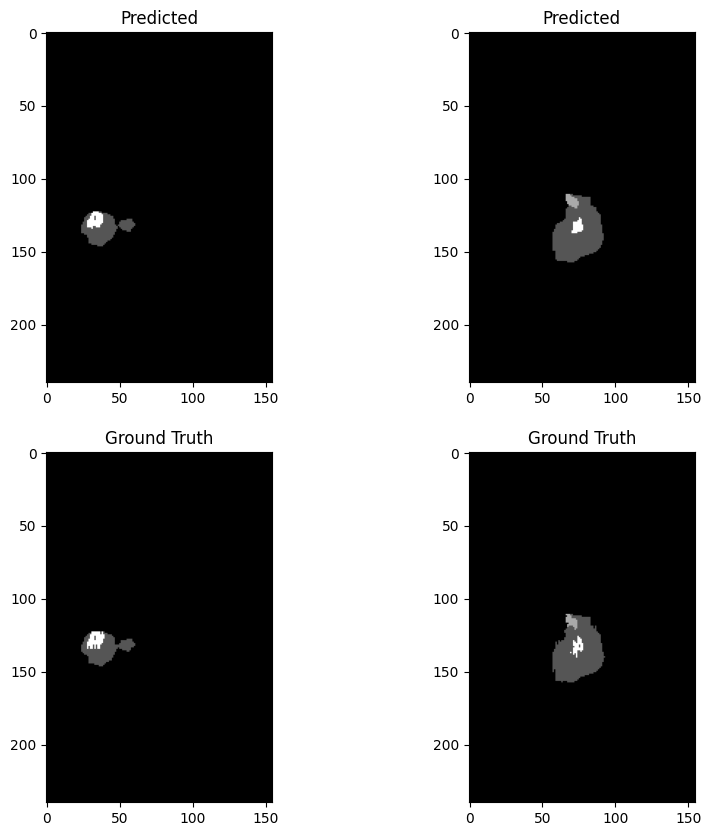

100%|██████████| 202/202 [07:03<00:00,  2.09s/it]



Average Training Loss: 0.0036714555785557863

Average Training DSC: [0.99957975 0.95961799 0.96246131 0.89133731]
Average Training ASSD: [ 0.03561866  3.60072062  5.55371139 10.08051837]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


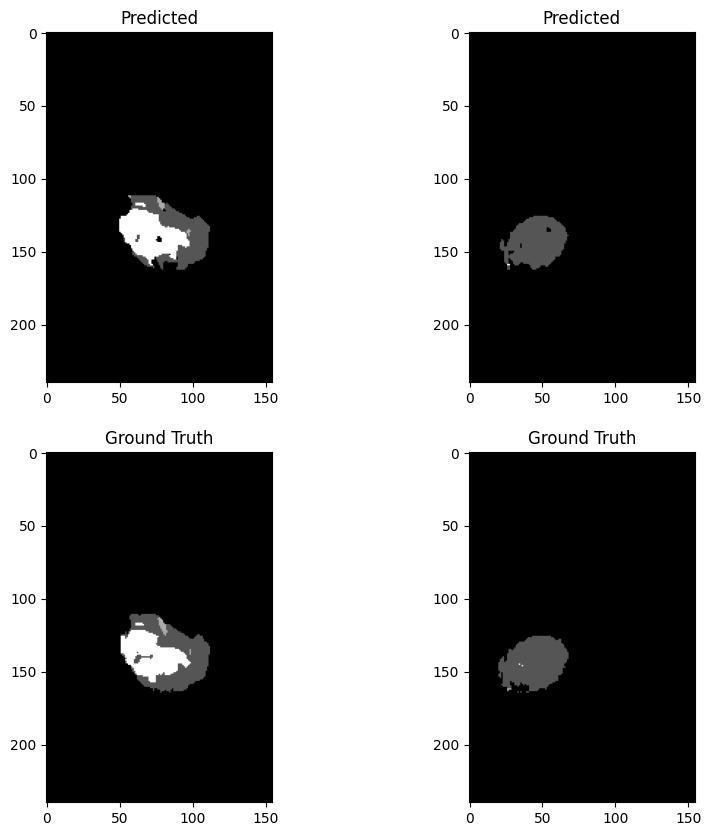

100%|██████████| 51/51 [01:18<00:00,  1.55s/it]


Average Validation Loss: 0.02043374910877616

Average Validation DSC: [0.99841693 0.82430984 0.91213687 0.73555594]
Average Validation ASSD: [ 0.15902334 18.54421297 15.97746521  7.39390697]
Epoch 78/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


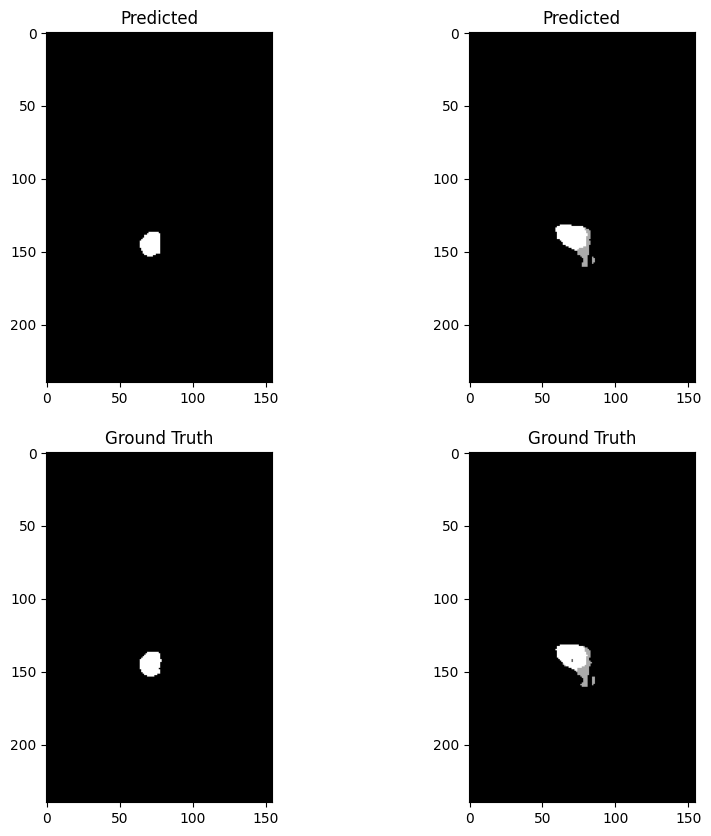

100%|██████████| 202/202 [07:11<00:00,  2.14s/it]



Average Training Loss: 0.0068016365633834855

Average Training DSC: [0.99923765 0.88968594 0.9278221  0.82786359]
Average Training ASSD: [ 0.07621681 21.31873719 13.94439249 12.19910333]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


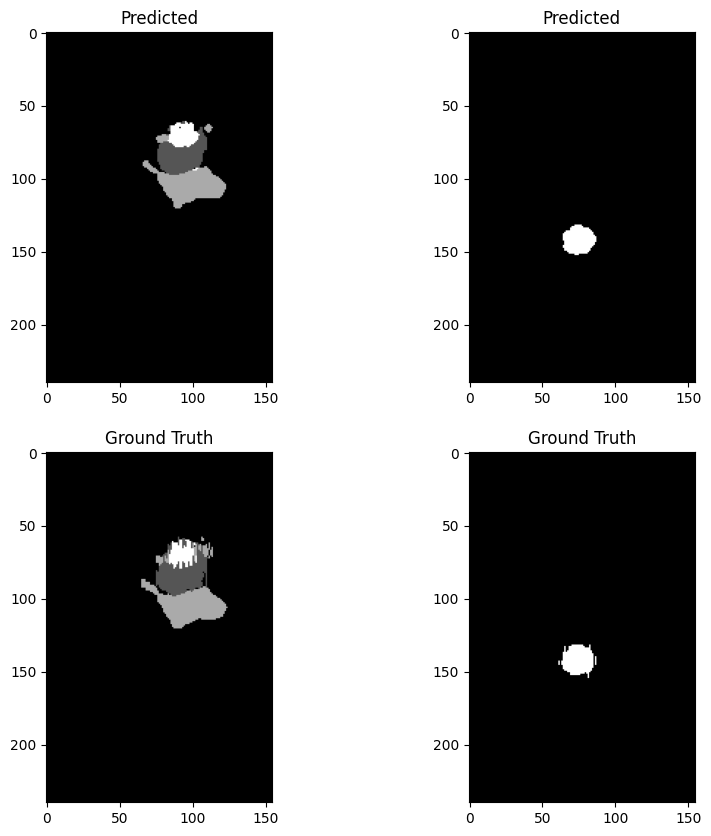

100%|██████████| 51/51 [01:17<00:00,  1.51s/it]


Average Validation Loss: 0.014935629917126075

Average Validation DSC: [0.99845127 0.82487953 0.89965199 0.73539419]
Average Validation ASSD: [ 0.16042557 24.20921338 19.53783432  9.04569417]
Epoch 79/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


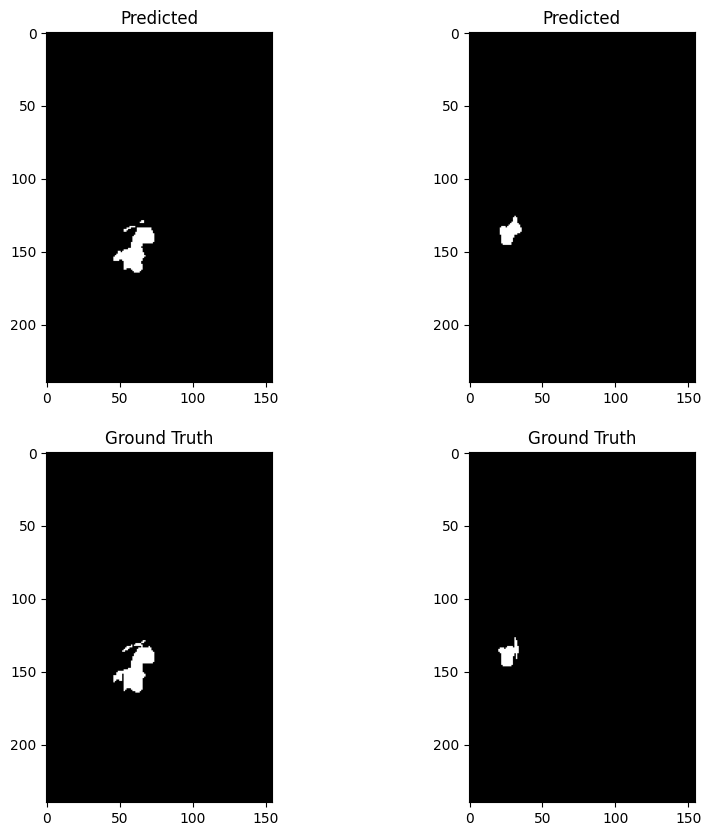

100%|██████████| 202/202 [07:10<00:00,  2.13s/it]



Average Training Loss: 0.0081763353364745

Average Training DSC: [0.99906253 0.88275578 0.92198372 0.80485302]
Average Training ASSD: [ 0.09439465 21.96004643 14.90351916 14.93573578]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


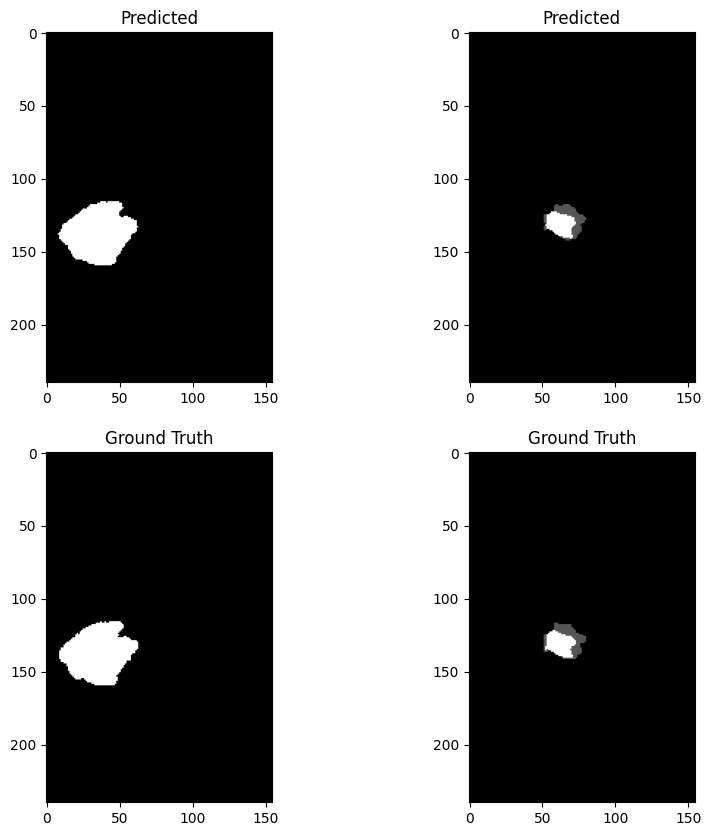

100%|██████████| 51/51 [01:14<00:00,  1.45s/it]


Average Validation Loss: 0.010680328935896065

Average Validation DSC: [0.99893748 0.85114118 0.91718074 0.78651071]
Average Validation ASSD: [ 0.11348936 30.30218004 16.26860107 13.7842143 ]
Epoch 80/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


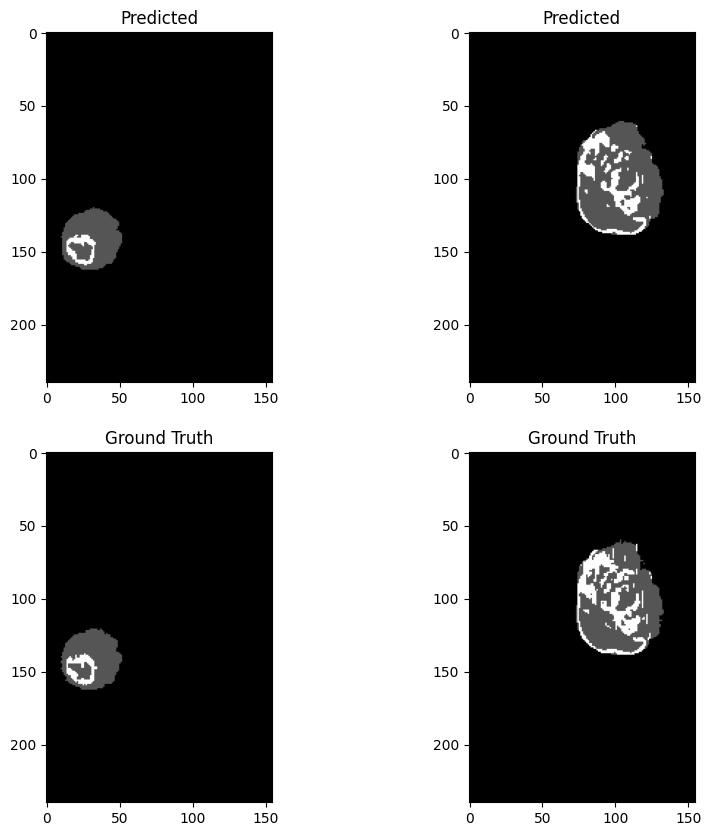

100%|██████████| 202/202 [07:06<00:00,  2.11s/it]



Average Training Loss: 0.006010238288689663

Average Training DSC: [0.99933952 0.92203425 0.93957994 0.84301367]
Average Training ASSD: [ 0.06131539 12.14228112 11.22082508 12.72374623]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


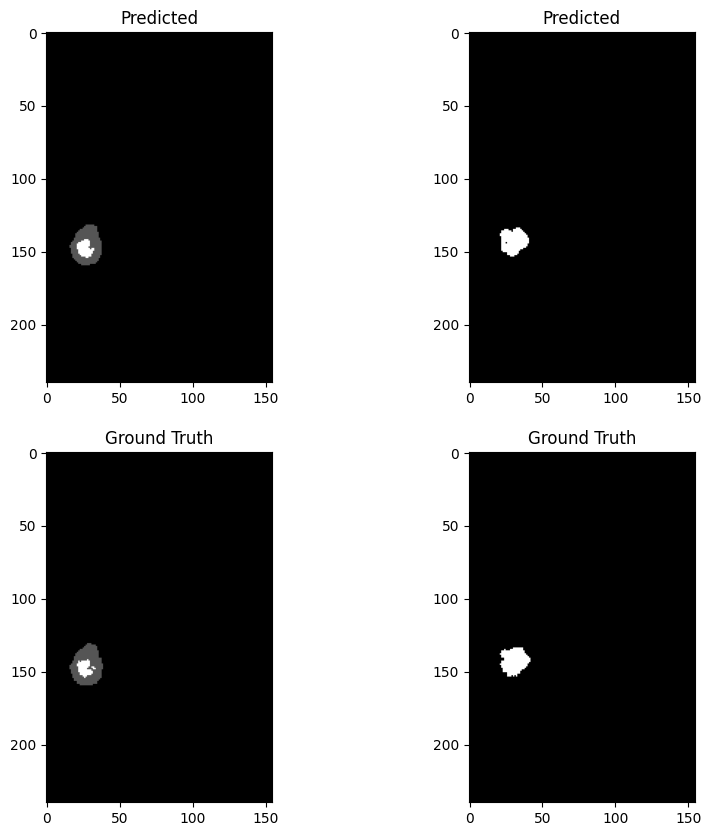

100%|██████████| 51/51 [01:14<00:00,  1.46s/it]


Average Validation Loss: 0.009629922197656888

Average Validation DSC: [0.99910628 0.89927674 0.92950646 0.81876321]
Average Validation ASSD: [ 0.09336672 16.33361885 13.78052645 11.6282292 ]
Epoch 81/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


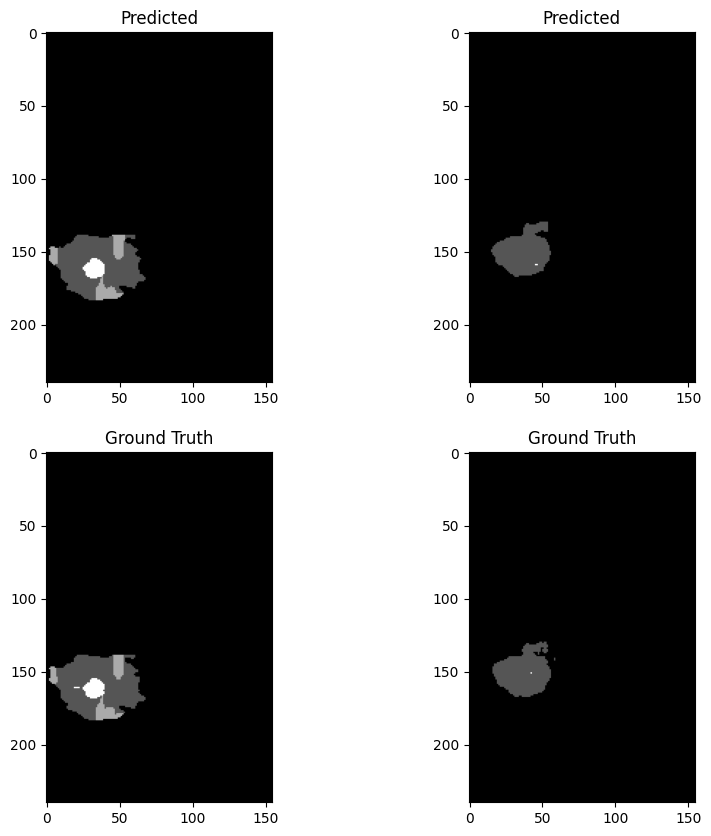

100%|██████████| 202/202 [07:05<00:00,  2.11s/it]



Average Training Loss: 0.004293988556785528

Average Training DSC: [0.99950422 0.94875115 0.96014704 0.87010486]
Average Training ASSD: [ 0.04424786  6.24565244  5.92832297 12.174822  ]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


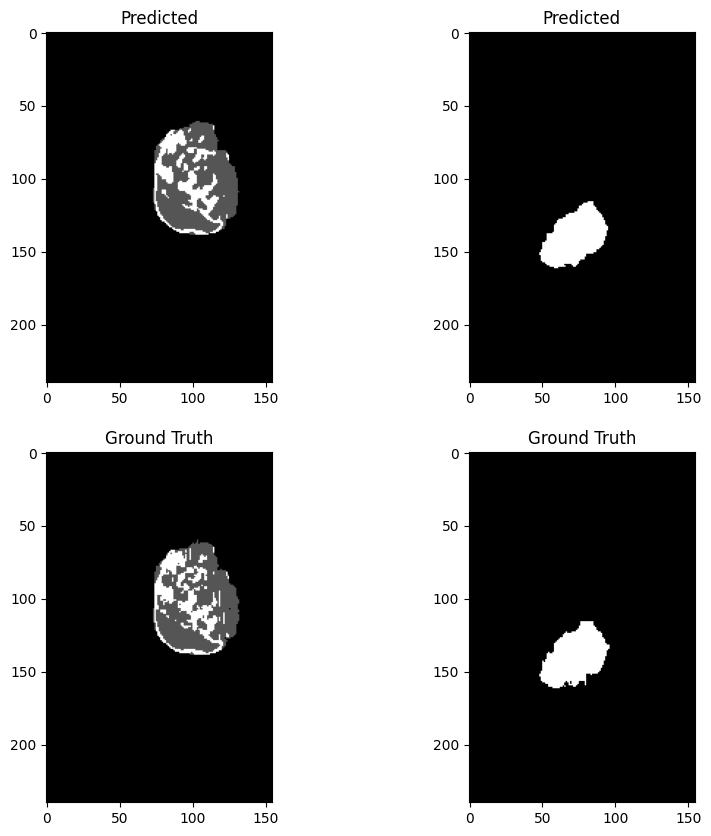

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.010163354979572343

Average Validation DSC: [0.99910588 0.86548214 0.92730538 0.81113391]
Average Validation ASSD: [ 0.08915423 29.3656979  14.95362708 12.96519912]
Epoch 82/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


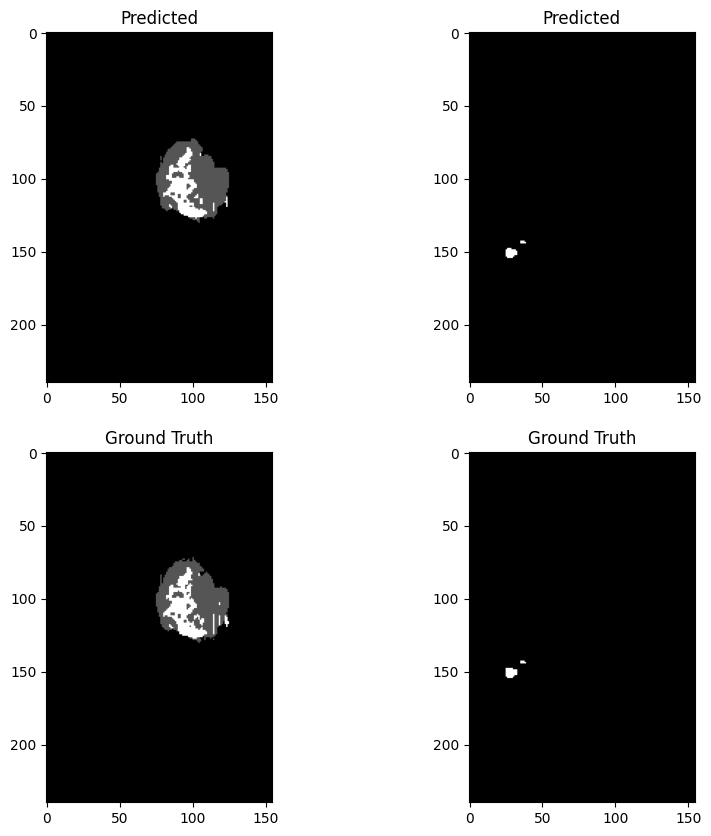

100%|██████████| 202/202 [07:05<00:00,  2.11s/it]



Average Training Loss: 0.0035084823295151316

Average Training DSC: [0.99959567 0.96412074 0.96671708 0.89326203]
Average Training ASSD: [ 0.03380437  2.76831475  4.50783003 10.48007186]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


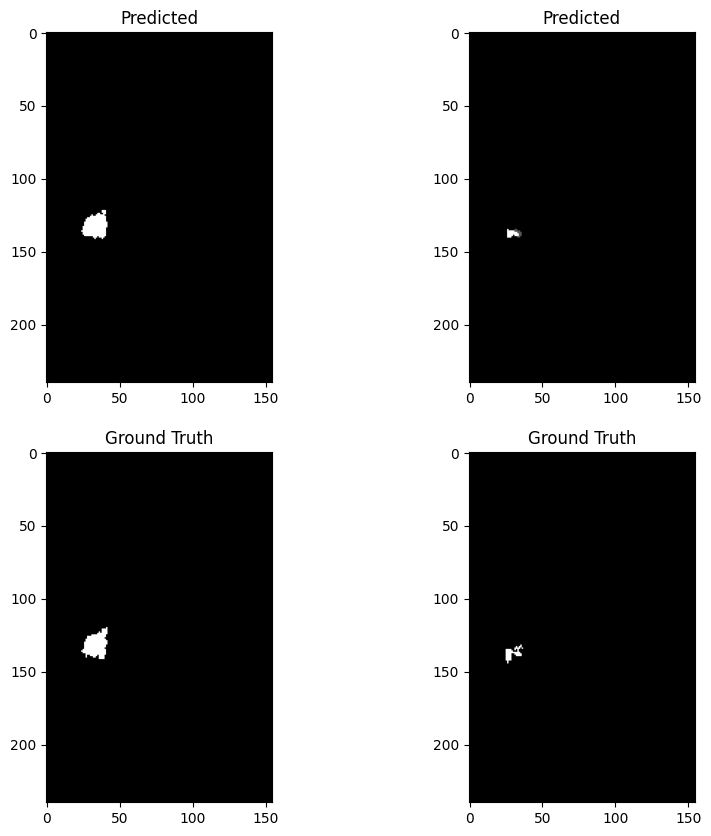

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.009821309936324171

Average Validation DSC: [0.99922434 0.90619886 0.93483857 0.83706774]
Average Validation ASSD: [ 0.08116822 17.17750599 13.15185229 12.17513636]
Epoch 83/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


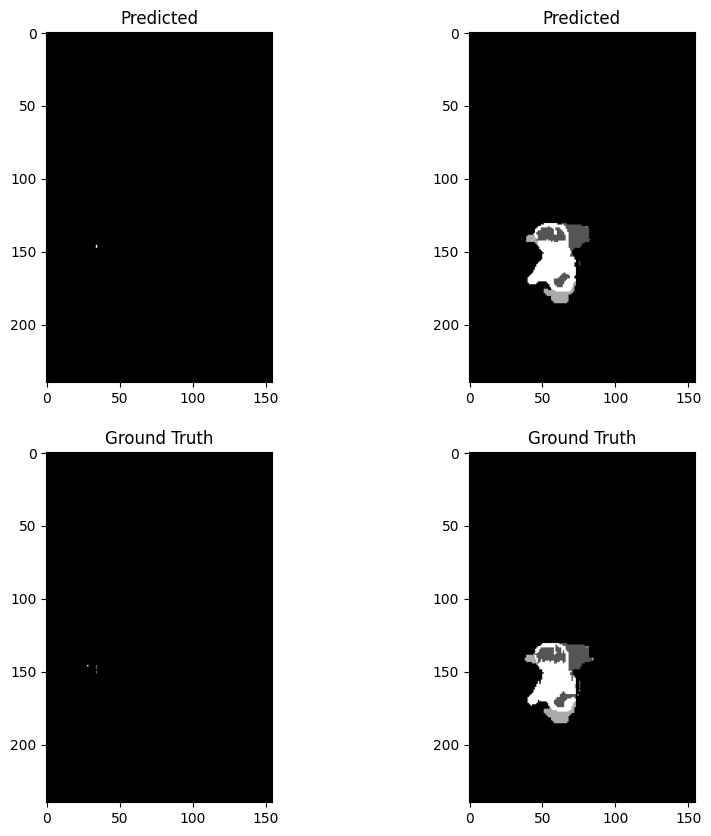

100%|██████████| 202/202 [07:06<00:00,  2.11s/it]



Average Training Loss: 0.003126863994760125

Average Training DSC: [0.9996525  0.97009979 0.96857705 0.90336654]
Average Training ASSD: [0.02923429 1.40830807 4.13041768 9.35106826]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


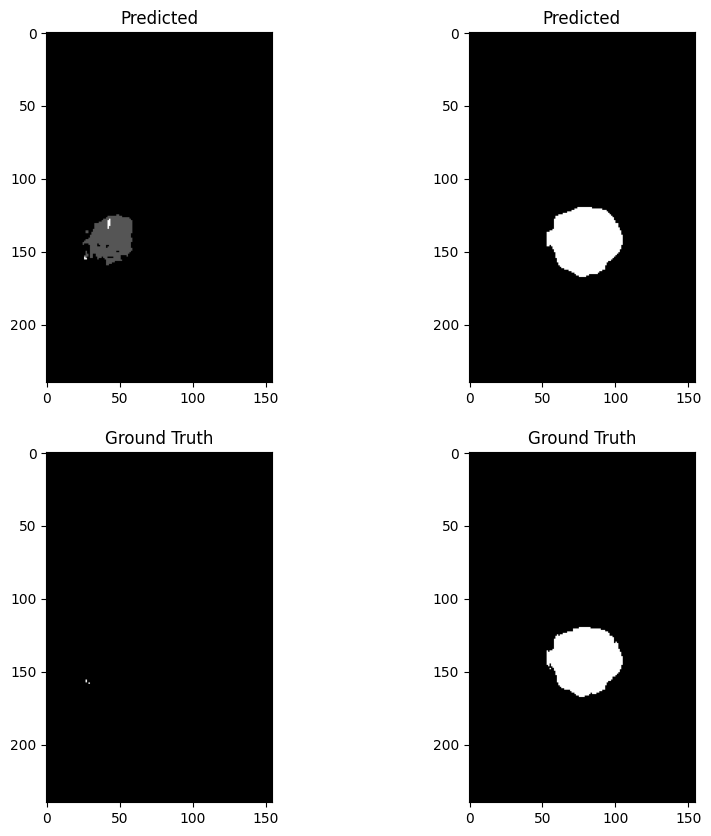

100%|██████████| 51/51 [01:20<00:00,  1.57s/it]


Average Validation Loss: 0.009537561604862703

Average Validation DSC: [0.99925898 0.90446765 0.93524489 0.84544475]
Average Validation ASSD: [ 0.0744769  17.17283239 13.11623615  8.64543155]
Epoch 84/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


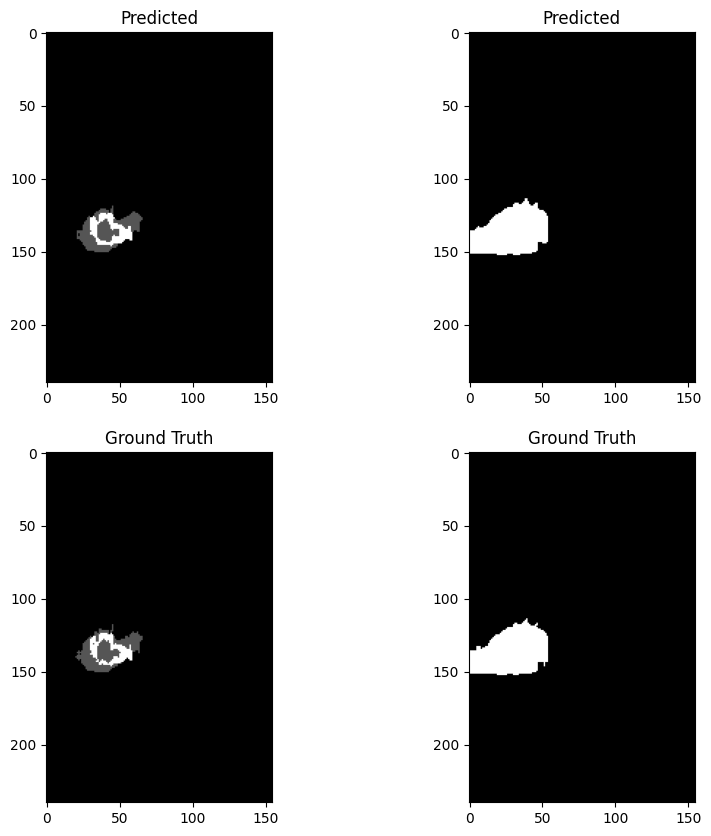

100%|██████████| 202/202 [07:06<00:00,  2.11s/it]



Average Training Loss: 0.0029705614975358515

Average Training DSC: [0.99966967 0.97086226 0.96946583 0.90881323]
Average Training ASSD: [0.02736291 1.62611032 4.26496632 9.16652621]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


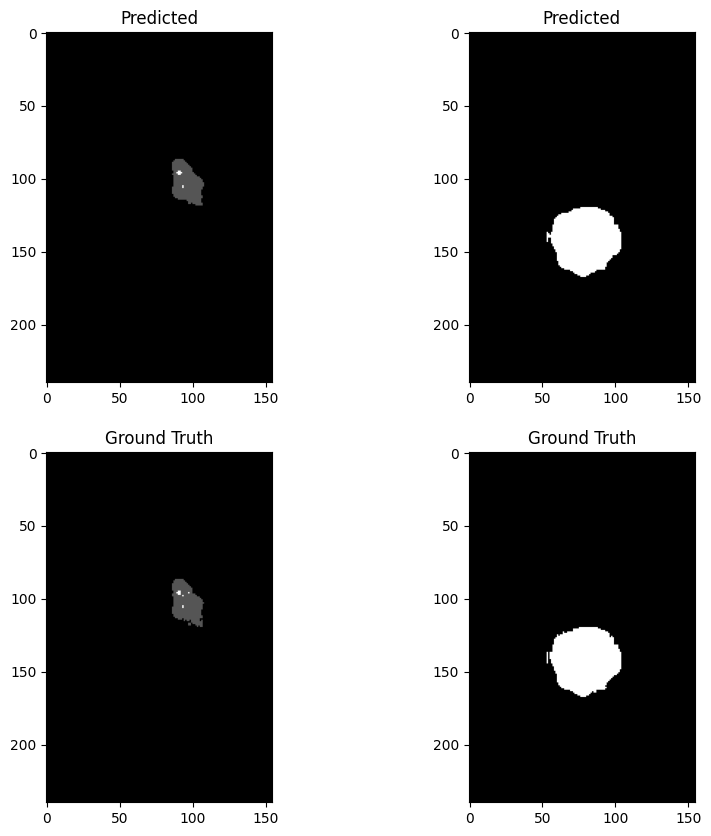

100%|██████████| 51/51 [01:16<00:00,  1.51s/it]


Average Validation Loss: 0.01007756097790073

Average Validation DSC: [0.99925398 0.90807208 0.93871773 0.84368894]
Average Validation ASSD: [ 0.08129862 16.29515985 11.96849435  9.28472546]
Epoch 85/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


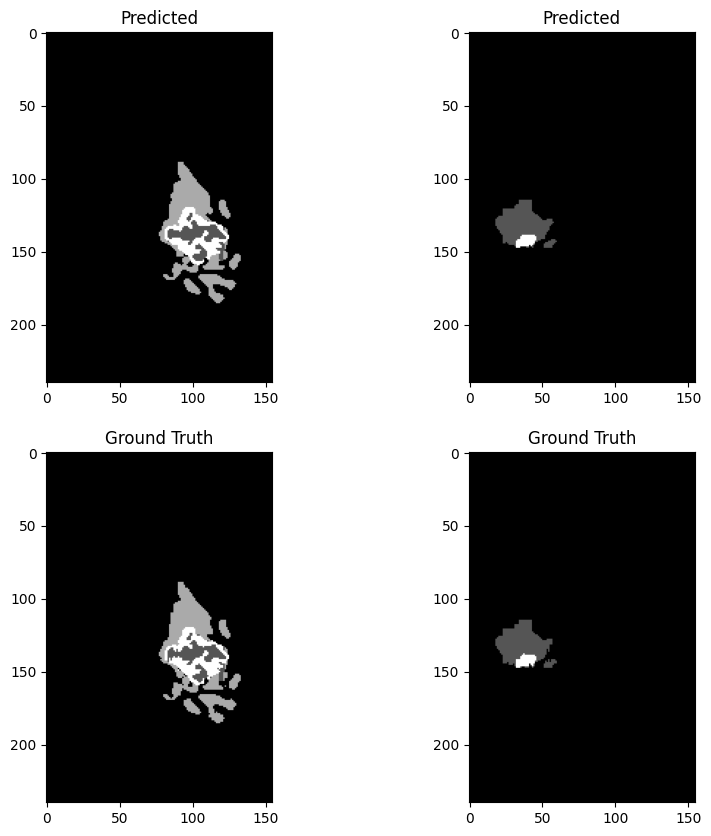

100%|██████████| 202/202 [07:11<00:00,  2.14s/it]



Average Training Loss: 0.00302387988782663

Average Training DSC: [0.99966535 0.9696343  0.96917028 0.90968959]
Average Training ASSD: [0.027538   1.85420371 4.4169619  7.72614796]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


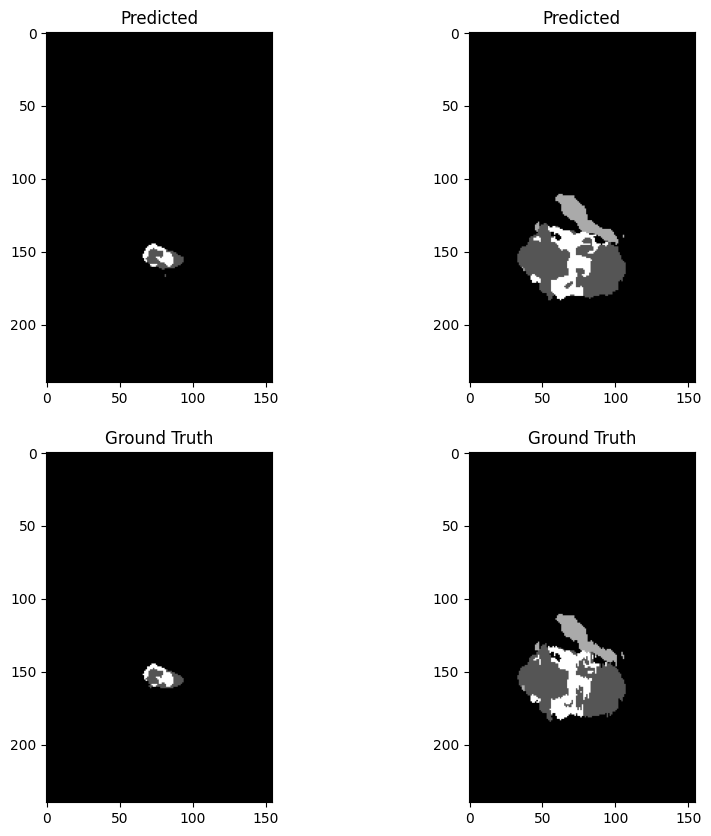

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.01018827823995083

Average Validation DSC: [0.99920023 0.90065236 0.9286032  0.83895652]
Average Validation ASSD: [ 0.08497437 18.66285883 13.54502283  8.22859293]
Epoch 86/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


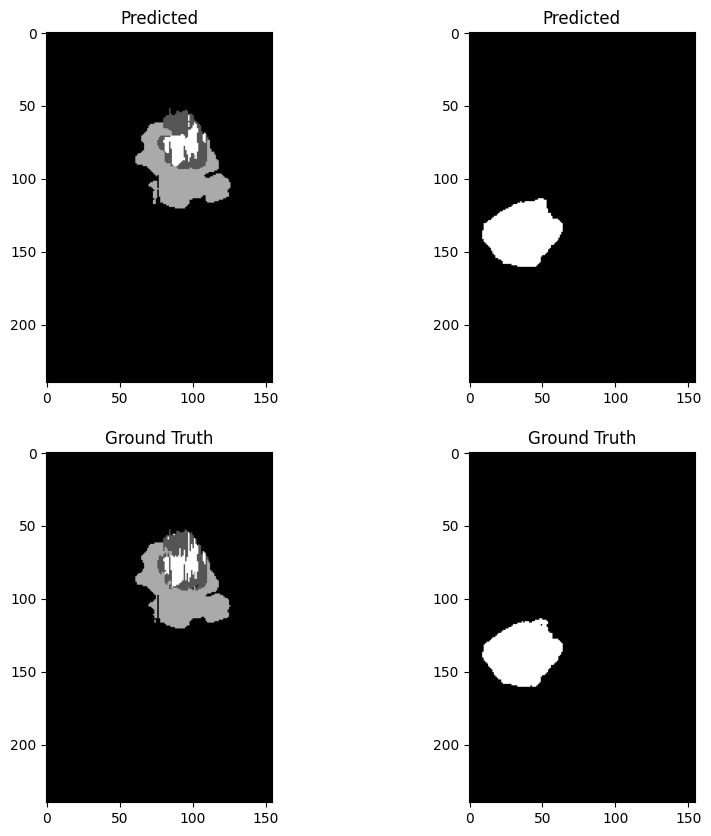

100%|██████████| 202/202 [07:07<00:00,  2.11s/it]



Average Training Loss: 0.0028990135248058873

Average Training DSC: [0.99967493 0.97143741 0.97142001 0.91268502]
Average Training ASSD: [0.02689794 1.61841206 3.29833451 7.85308855]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


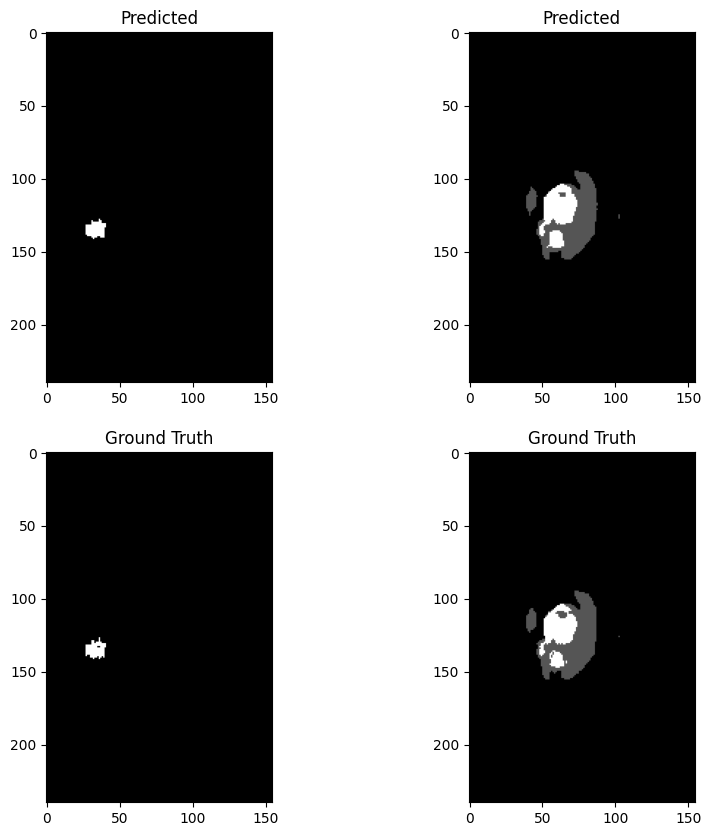

100%|██████████| 51/51 [01:17<00:00,  1.51s/it]


Average Validation Loss: 0.010246145931602108

Average Validation DSC: [0.99927343 0.90713262 0.93963258 0.84522049]
Average Validation ASSD: [ 0.07551736 15.41640703 11.07816361  5.81137704]
Epoch 87/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


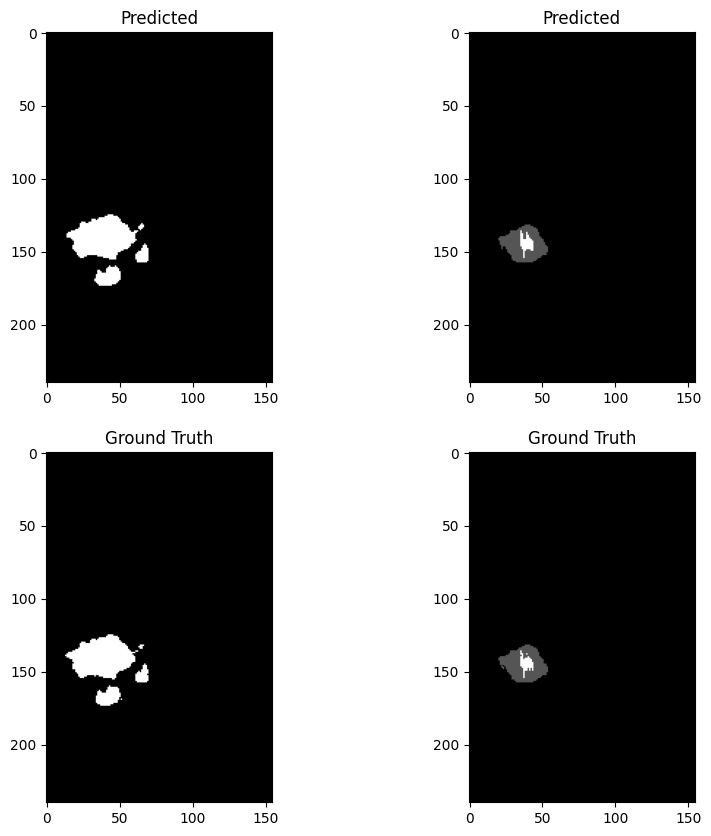

100%|██████████| 202/202 [06:58<00:00,  2.07s/it]



Average Training Loss: 0.0028126902179792523

Average Training DSC: [0.99968722 0.97164408 0.97077854 0.91545951]
Average Training ASSD: [0.02536518 1.69239111 3.90336045 7.28384794]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


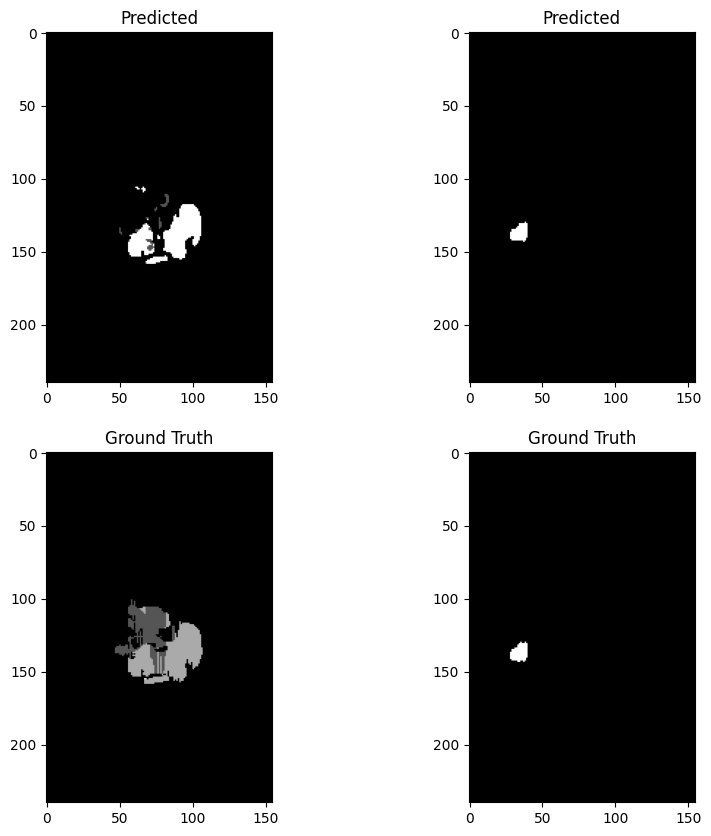

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.010613754209057958

Average Validation DSC: [0.99926894 0.91284721 0.94476292 0.84655176]
Average Validation ASSD: [ 0.07694465 14.53104995  9.27993758  9.8076242 ]
Epoch 88/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


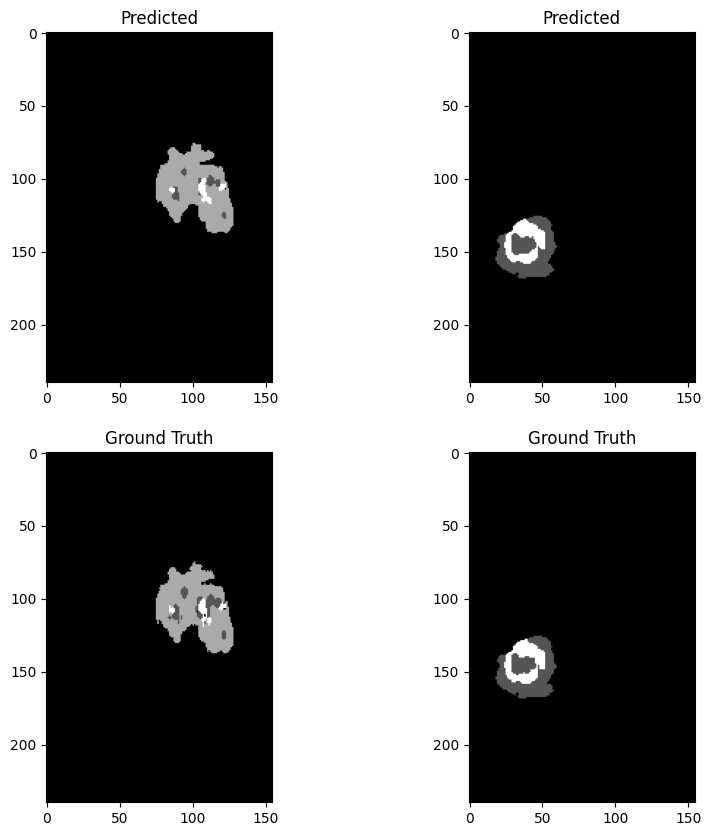

100%|██████████| 202/202 [07:06<00:00,  2.11s/it]



Average Training Loss: 0.002748085541470843

Average Training DSC: [0.99969068 0.97337299 0.97110437 0.91892809]
Average Training ASSD: [0.02514087 1.38760359 4.113381   7.56797161]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


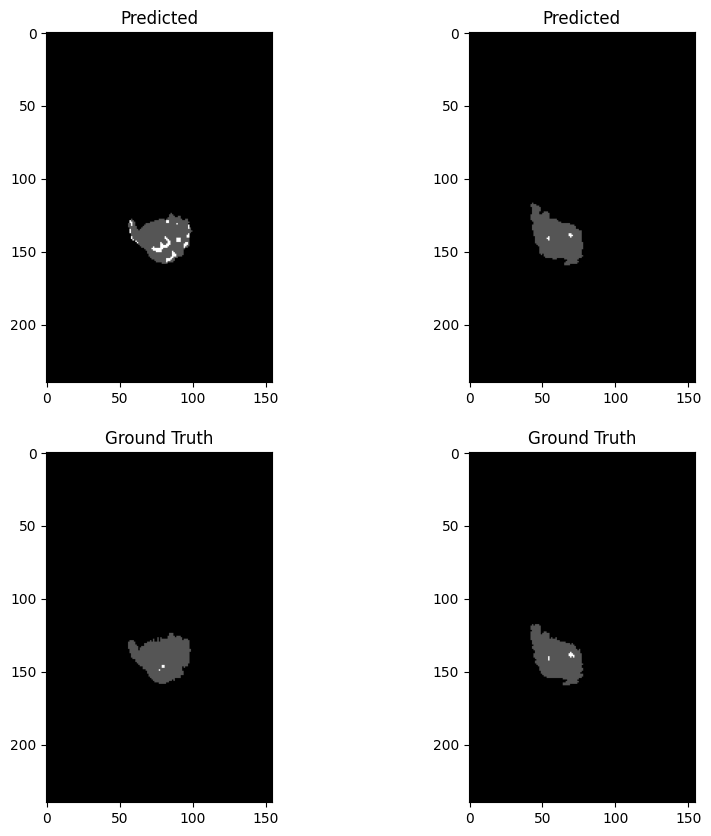

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.010557623968149224

Average Validation DSC: [0.99925981 0.90866359 0.94074268 0.84678367]
Average Validation ASSD: [ 0.07836463 16.80417293 10.51749161  8.61711072]
Epoch 89/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


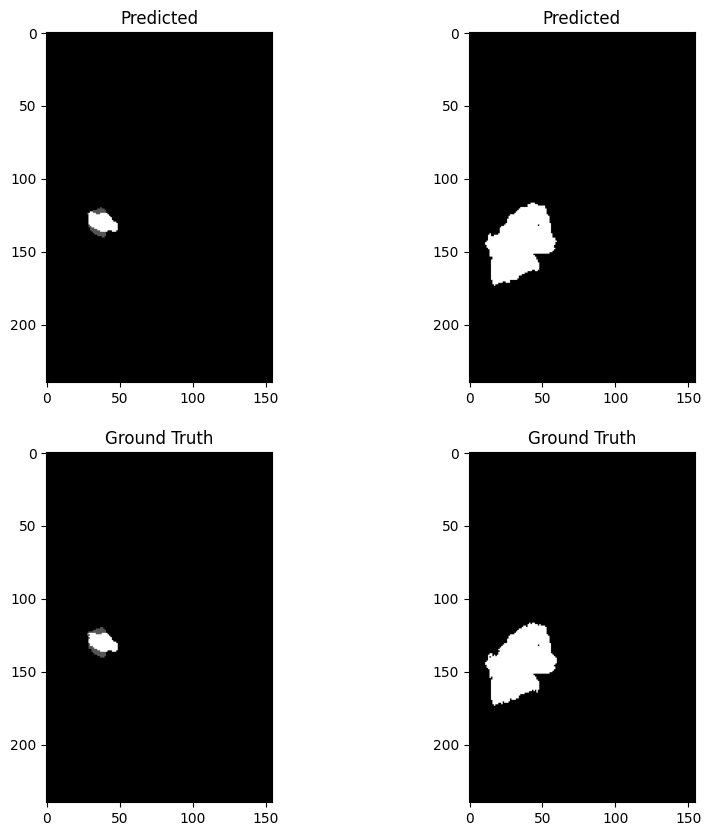

100%|██████████| 202/202 [07:22<00:00,  2.19s/it]



Average Training Loss: 0.00282371067787788

Average Training DSC: [0.99968732 0.97301307 0.97045426 0.91501686]
Average Training ASSD: [0.02566959 1.16825769 3.51786041 8.08643563]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


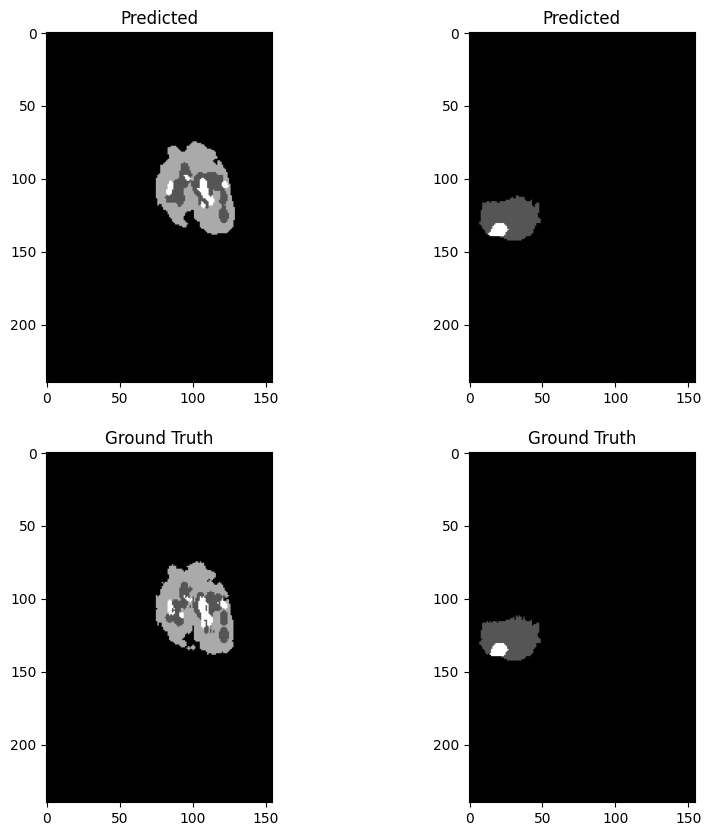

100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Average Validation Loss: 0.010390777044984348

Average Validation DSC: [0.99927403 0.90586461 0.93744631 0.849014  ]
Average Validation ASSD: [ 0.07521915 17.12150998 12.01313028  7.71799692]
Epoch 90/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


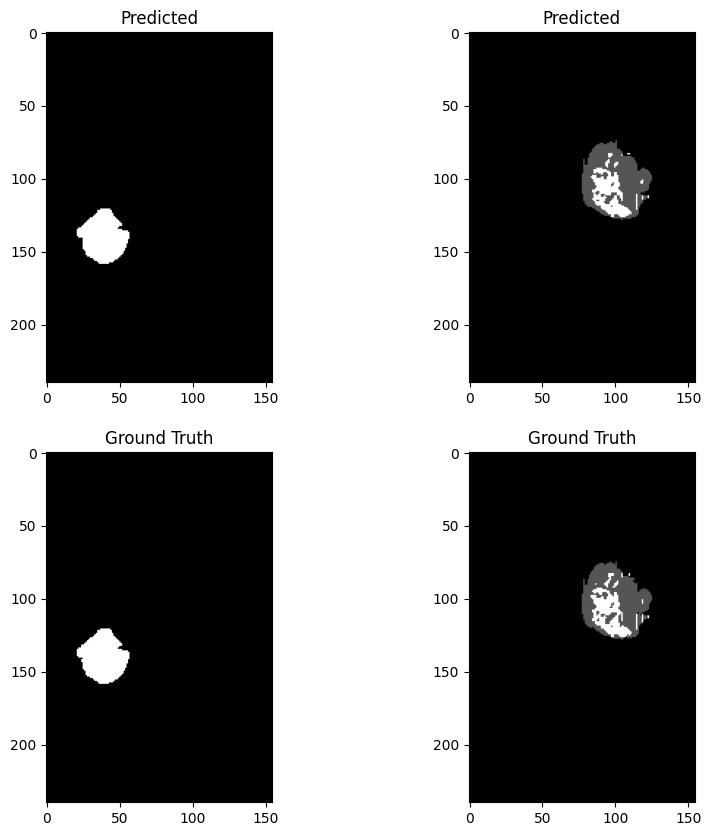

100%|██████████| 202/202 [07:10<00:00,  2.13s/it]



Average Training Loss: 0.0028292004838539747

Average Training DSC: [0.99968177 0.97155449 0.97159653 0.91963462]
Average Training ASSD: [0.02534304 1.69256804 3.3781705  6.23745882]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


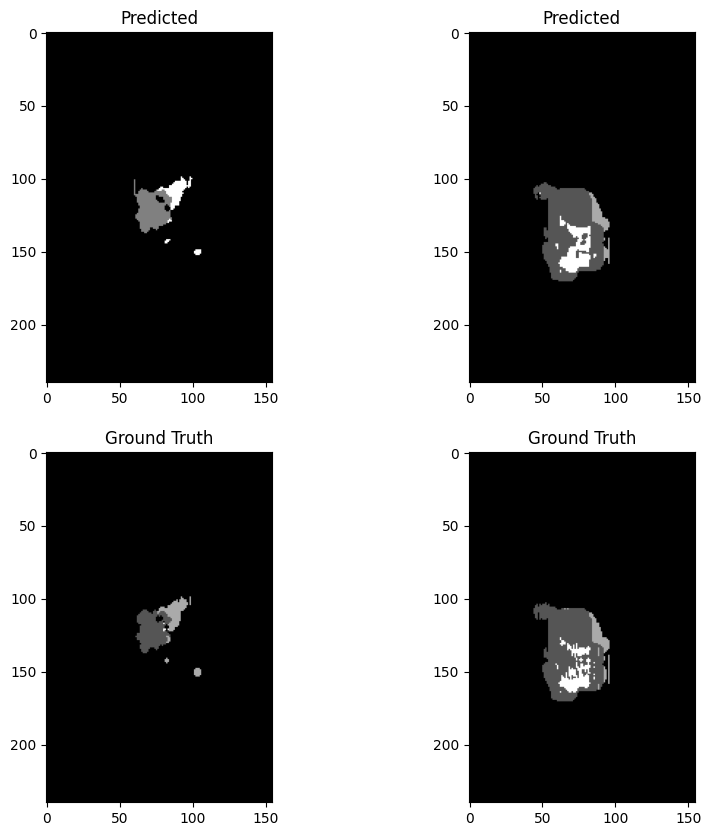

100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Average Validation Loss: 0.010900974319334709

Average Validation DSC: [0.99923363 0.90832979 0.93775235 0.84392745]
Average Validation ASSD: [ 0.07915817 15.36886312 11.99059134  6.58433057]
Epoch 91/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


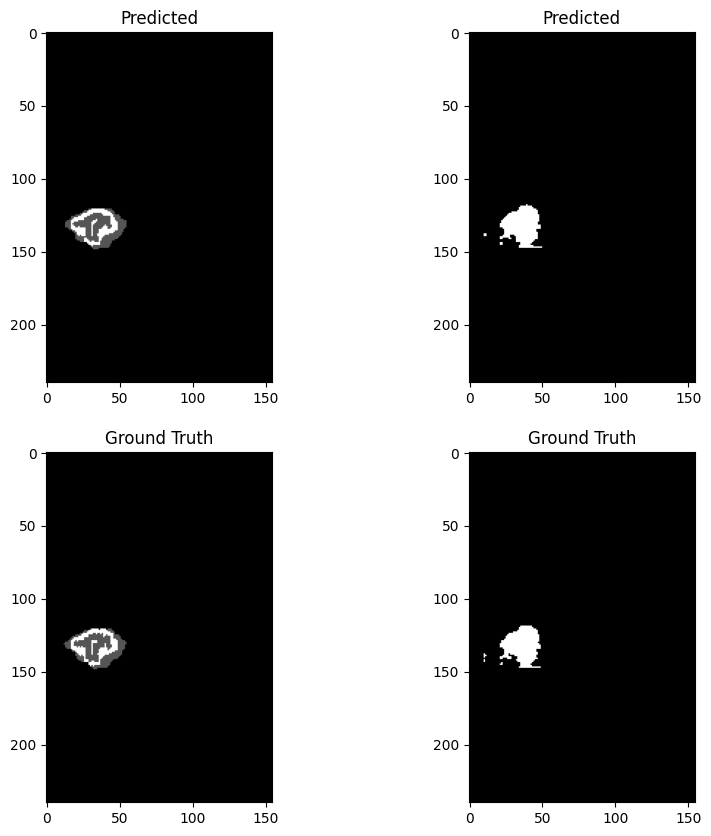

100%|██████████| 202/202 [07:07<00:00,  2.12s/it]



Average Training Loss: 0.0030113303766466015

Average Training DSC: [0.99965287 0.97021274 0.96689498 0.91623095]
Average Training ASSD: [0.02913625 1.92252144 4.789083   6.77154498]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


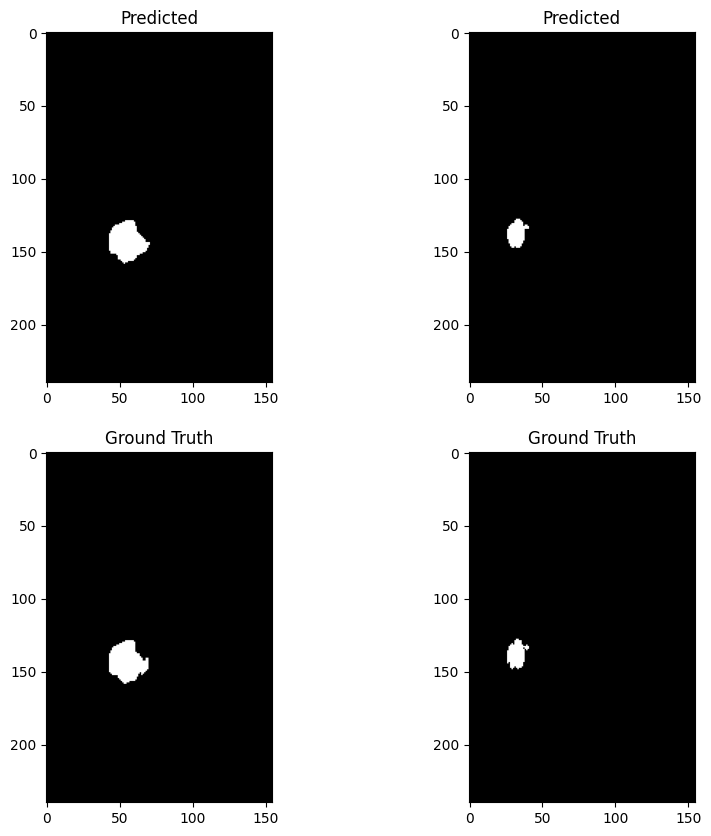

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.010926053448415855

Average Validation DSC: [0.9991743  0.90001117 0.88452138 0.84292044]
Average Validation ASSD: [ 0.0927483  17.21087547 27.02566049  4.66295541]
Epoch 92/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


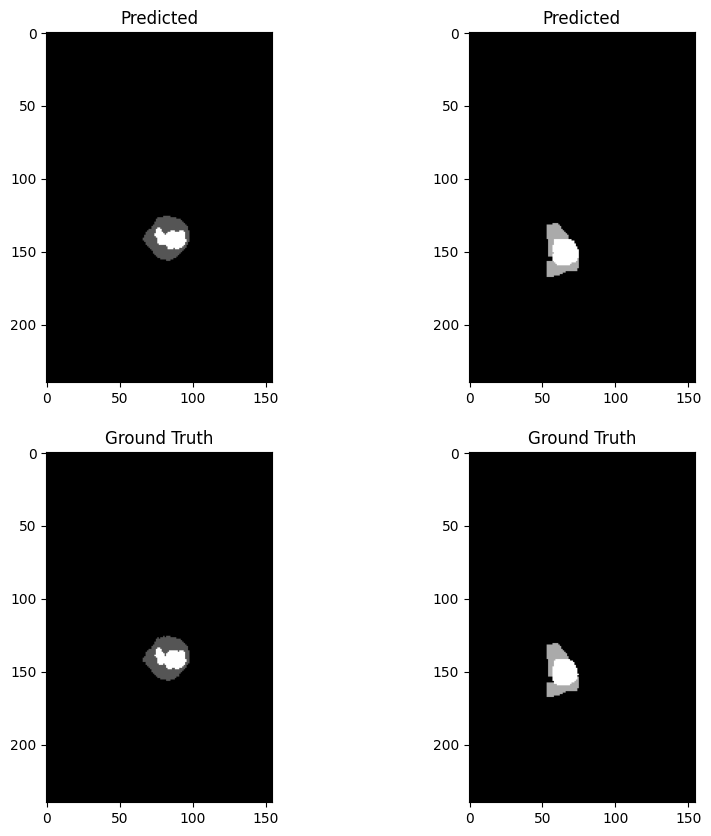

100%|██████████| 202/202 [07:02<00:00,  2.09s/it]



Average Training Loss: 0.0027485714878398224

Average Training DSC: [0.99968984 0.97164705 0.97148465 0.92070513]
Average Training ASSD: [0.02505991 1.76353189 3.58557847 6.77477207]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


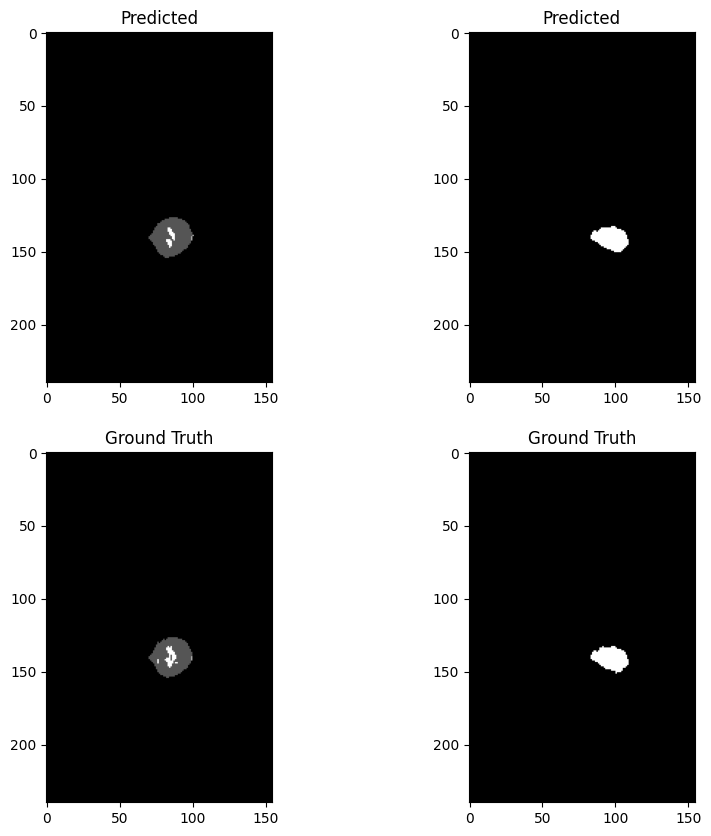

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.011472518263640357

Average Validation DSC: [0.99924685 0.8987841  0.92759432 0.8411007 ]
Average Validation ASSD: [ 0.08048108 19.7880745  14.03401987  7.80184081]
Epoch 93/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


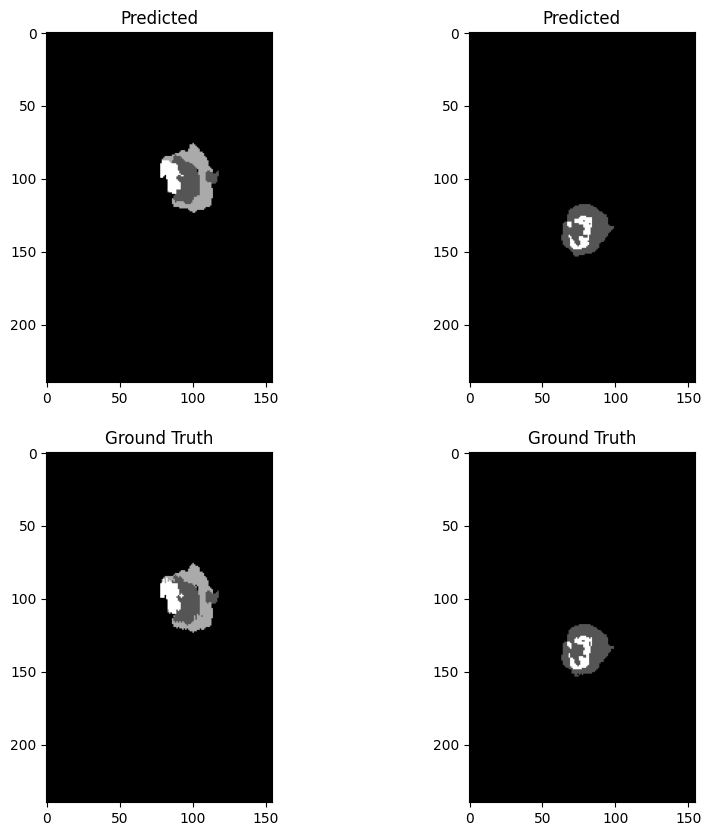

100%|██████████| 202/202 [07:00<00:00,  2.08s/it]



Average Training Loss: 0.0027080487089904746

Average Training DSC: [0.9996979  0.97186842 0.9718323  0.92525259]
Average Training ASSD: [0.0240826  1.90968597 3.15620909 5.6168743 ]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


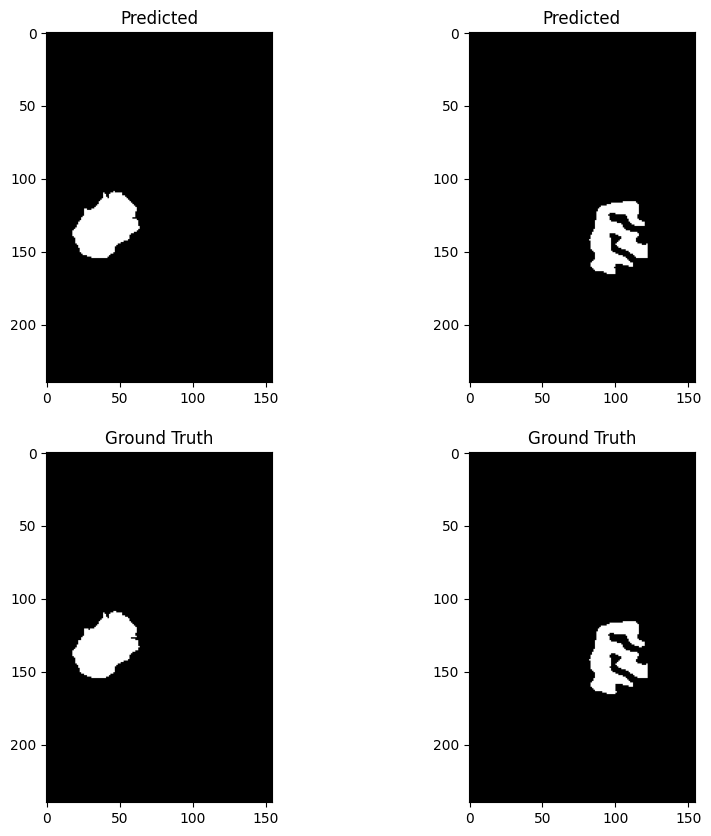

100%|██████████| 51/51 [01:17<00:00,  1.51s/it]


Average Validation Loss: 0.011281569502042496

Average Validation DSC: [0.999261   0.90356631 0.92804656 0.85100724]
Average Validation ASSD: [ 0.07914048 17.42497651 12.94054018  6.43011353]
Epoch 94/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


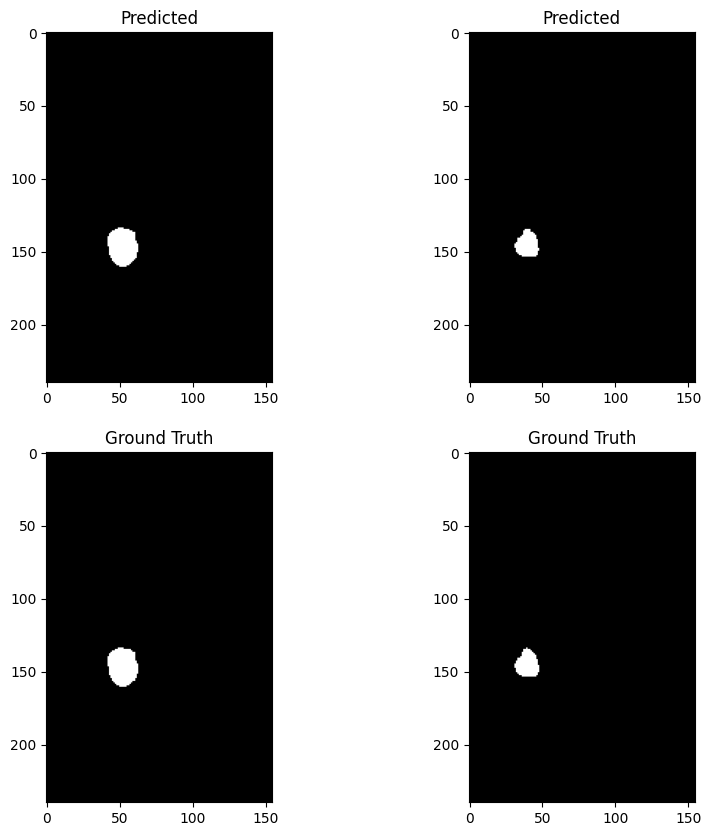

100%|██████████| 202/202 [07:18<00:00,  2.17s/it]



Average Training Loss: 0.002658952052917073

Average Training DSC: [0.99970622 0.97311368 0.97047078 0.92348609]
Average Training ASSD: [0.02351363 1.61033073 4.12131905 6.45037855]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


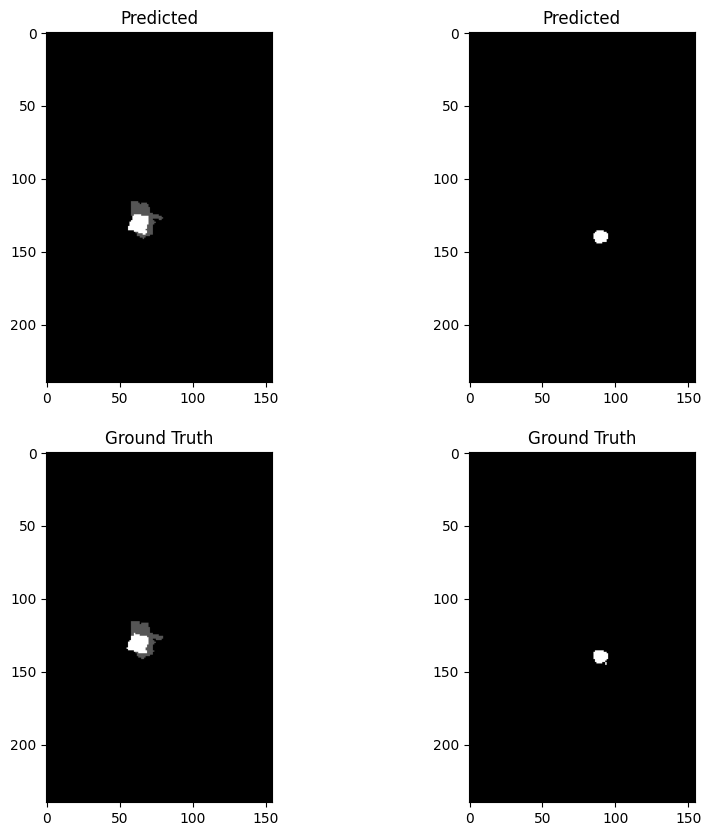

100%|██████████| 51/51 [01:20<00:00,  1.57s/it]


Average Validation Loss: 0.011147069680851465

Average Validation DSC: [0.9992611  0.91191559 0.94303661 0.85314723]
Average Validation ASSD: [ 0.0791507  14.52452755  8.5069126   6.47643018]
Epoch 95/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


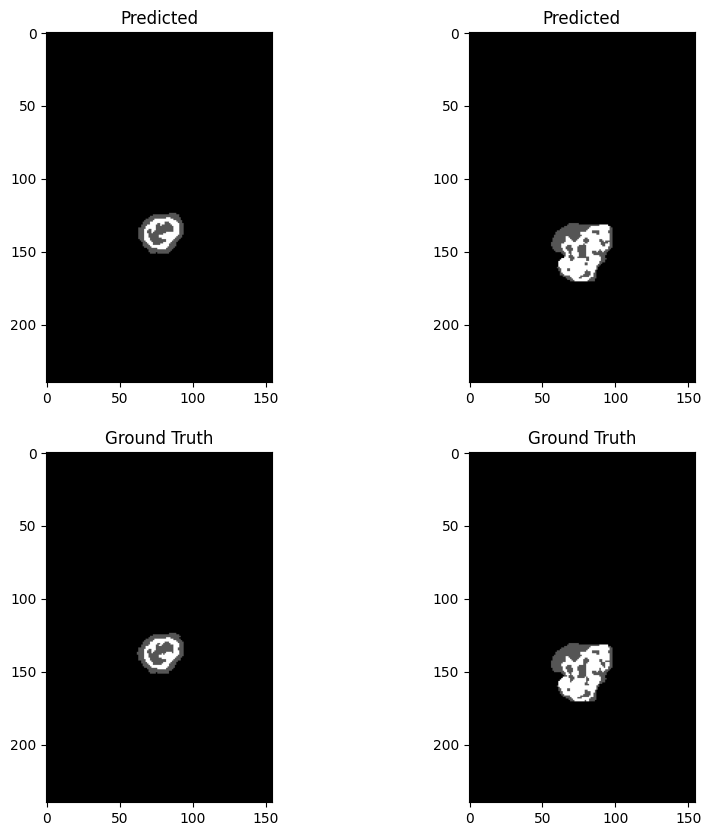

100%|██████████| 202/202 [07:05<00:00,  2.11s/it]



Average Training Loss: 0.0026654202409208483

Average Training DSC: [0.99970853 0.97298498 0.97388417 0.92204965]
Average Training ASSD: [0.02358701 1.61014428 2.98198469 6.51396464]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


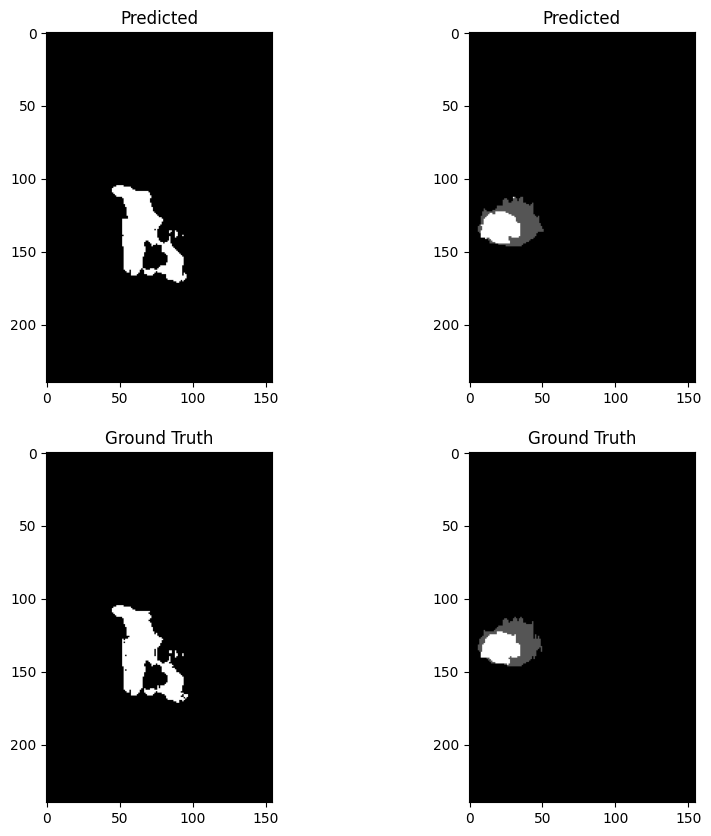

100%|██████████| 51/51 [01:16<00:00,  1.50s/it]


Average Validation Loss: 0.010916936749994171

Average Validation DSC: [0.99927591 0.90463619 0.93957768 0.84818717]
Average Validation ASSD: [ 0.07485121 17.1176181  11.69543839  7.75419074]
Epoch 96/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


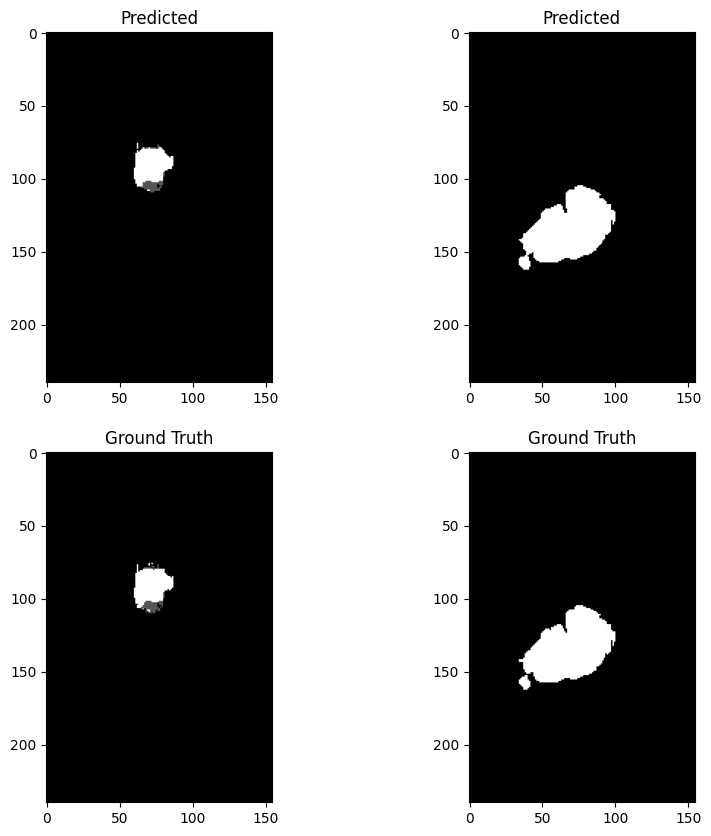

100%|██████████| 202/202 [07:07<00:00,  2.12s/it]



Average Training Loss: 0.0026056416526363036

Average Training DSC: [0.99970682 0.97411186 0.97419079 0.92505463]
Average Training ASSD: [0.02357394 1.37991318 3.13547781 6.27681898]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


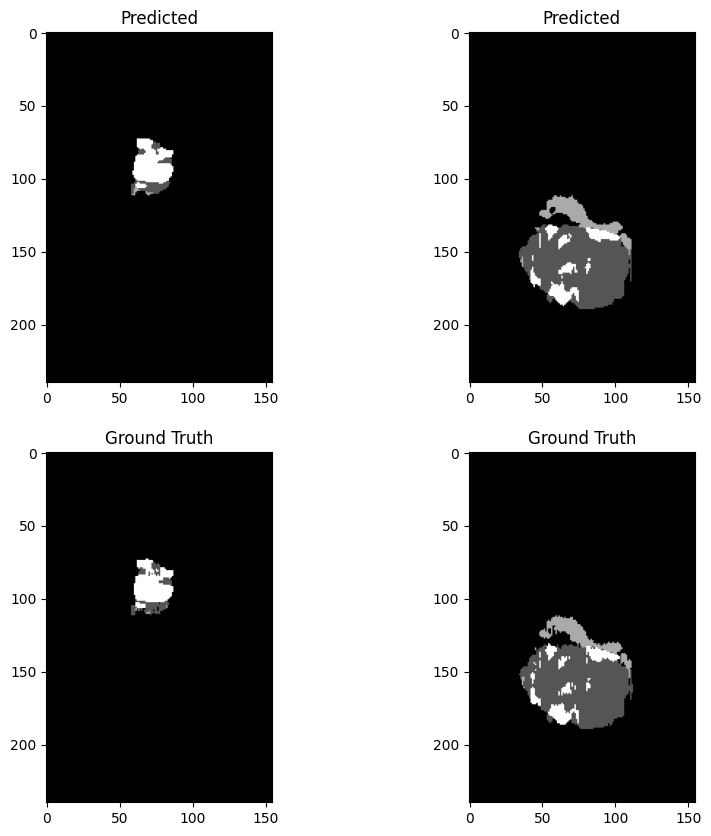

100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Average Validation Loss: 0.011834565394868454

Average Validation DSC: [0.99914614 0.88583532 0.89090578 0.84859135]
Average Validation ASSD: [ 0.10304961 23.69573862 25.91335452  4.85692609]
Epoch 97/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


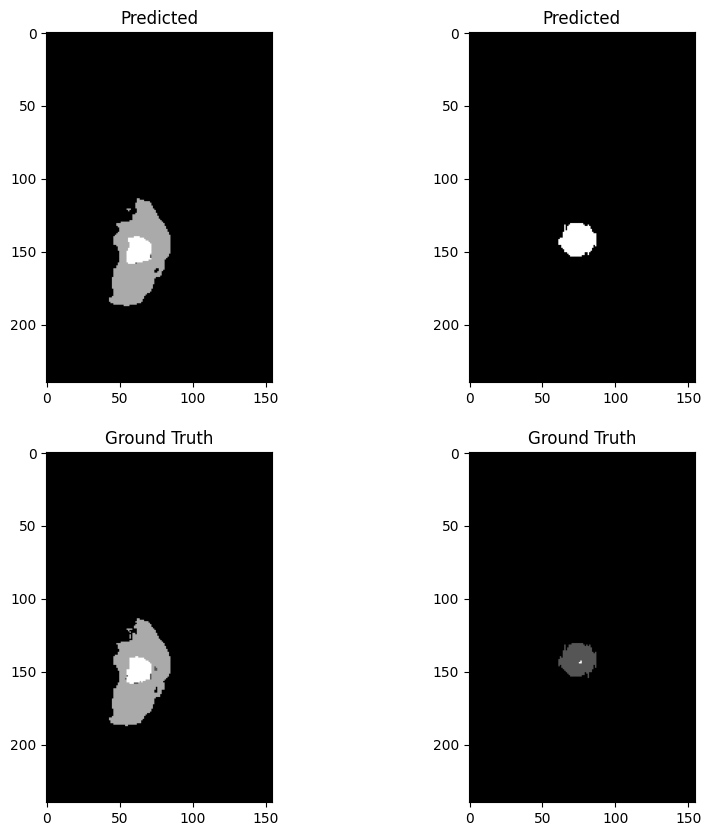

100%|██████████| 202/202 [07:09<00:00,  2.13s/it]



Average Training Loss: 0.00259443008085012

Average Training DSC: [0.99971216 0.97444408 0.97340352 0.92682565]
Average Training ASSD: [0.02305588 1.30587633 3.29835136 5.6935383 ]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


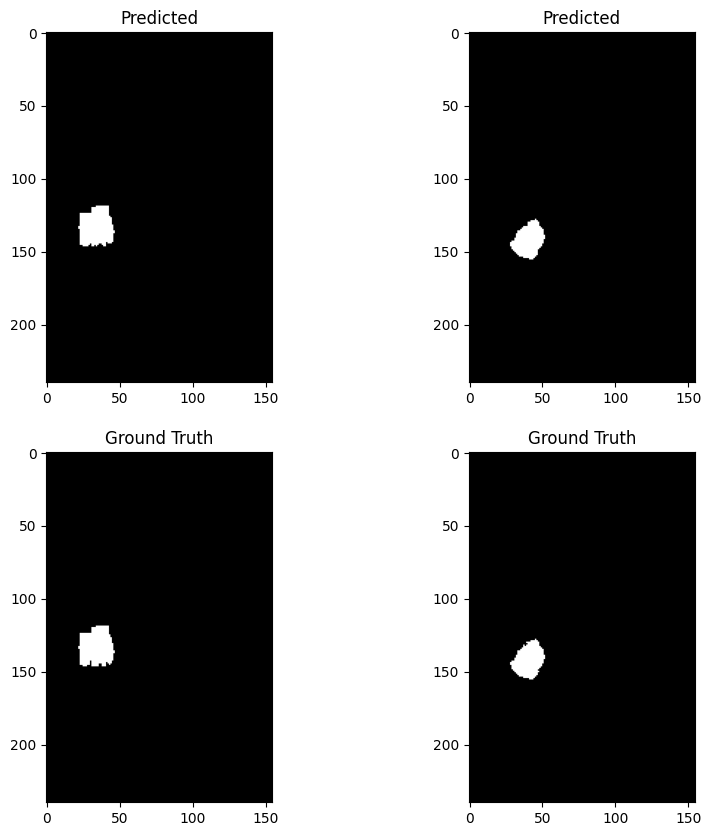

100%|██████████| 51/51 [01:14<00:00,  1.47s/it]


Average Validation Loss: 0.011055640574982938

Average Validation DSC: [0.9992483  0.90200217 0.93761459 0.85308743]
Average Validation ASSD: [ 0.08124273 18.55554855 11.67625263  4.83959326]
Epoch 98/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


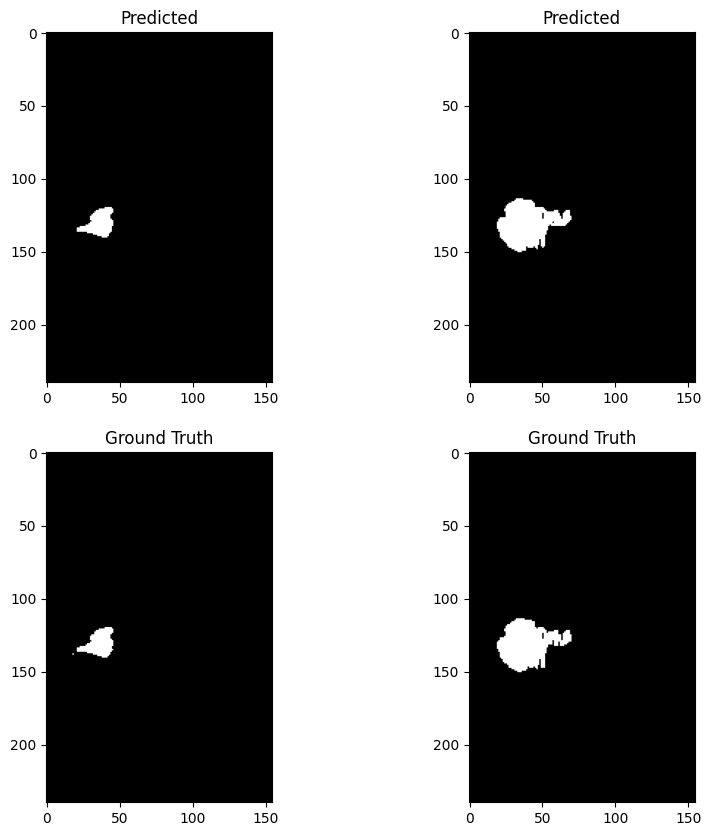

100%|██████████| 202/202 [07:10<00:00,  2.13s/it]



Average Training Loss: 0.0024944093708861802

Average Training DSC: [0.99972633 0.97446566 0.97361567 0.92805654]
Average Training ASSD: [0.02207701 1.60067877 3.58176794 5.96945943]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


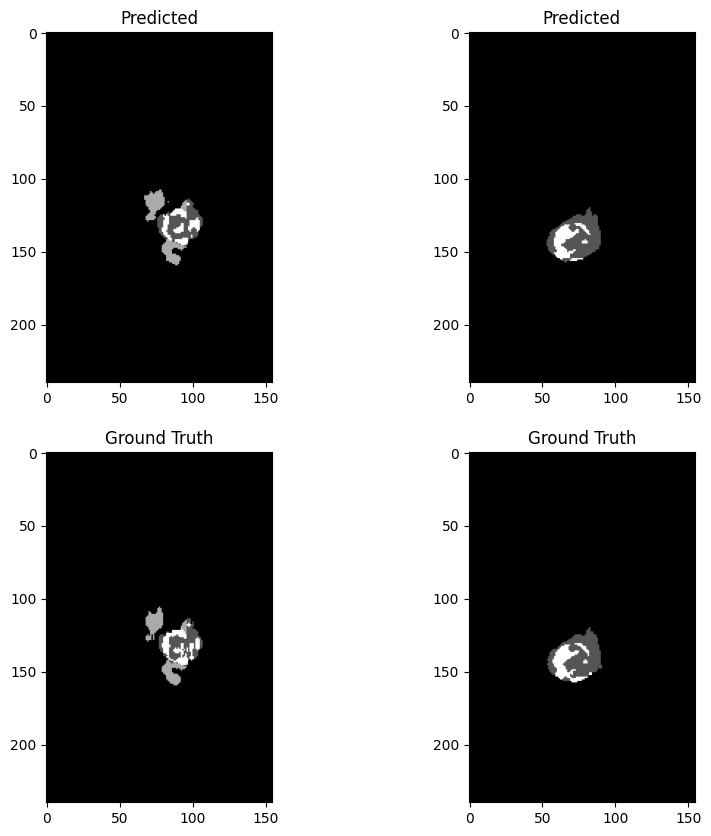

100%|██████████| 51/51 [01:17<00:00,  1.52s/it]


Average Validation Loss: 0.010619129405776952

Average Validation DSC: [0.99927019 0.90514631 0.93959599 0.84646754]
Average Validation ASSD: [ 0.08180598 17.76019038 11.40468439 10.08852943]
Epoch 99/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


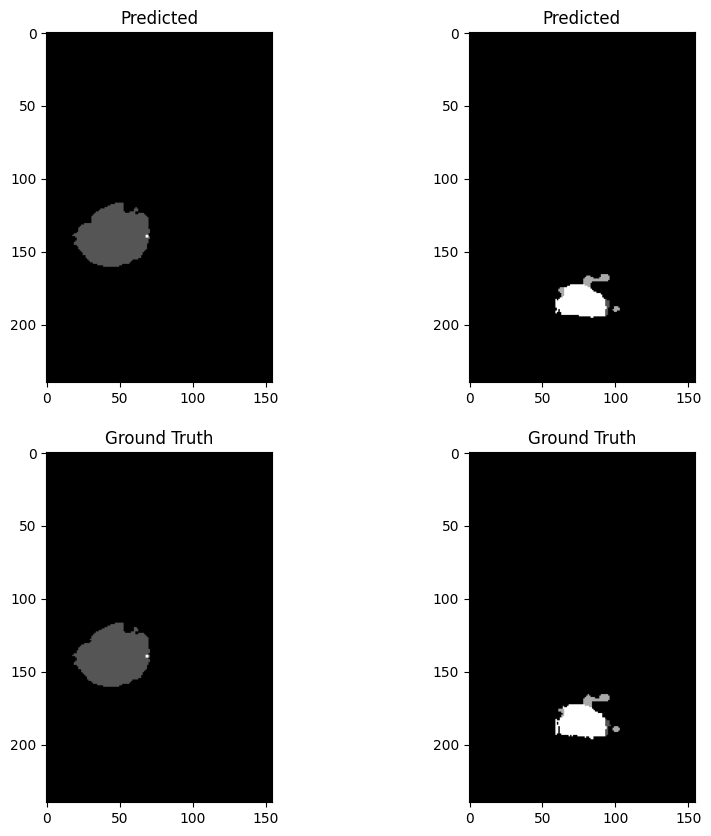

100%|██████████| 202/202 [07:02<00:00,  2.09s/it]



Average Training Loss: 0.0025149767239817816

Average Training DSC: [0.99972114 0.97516841 0.97168881 0.92974491]
Average Training ASSD: [0.02248109 1.37775373 3.66951758 5.44838255]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


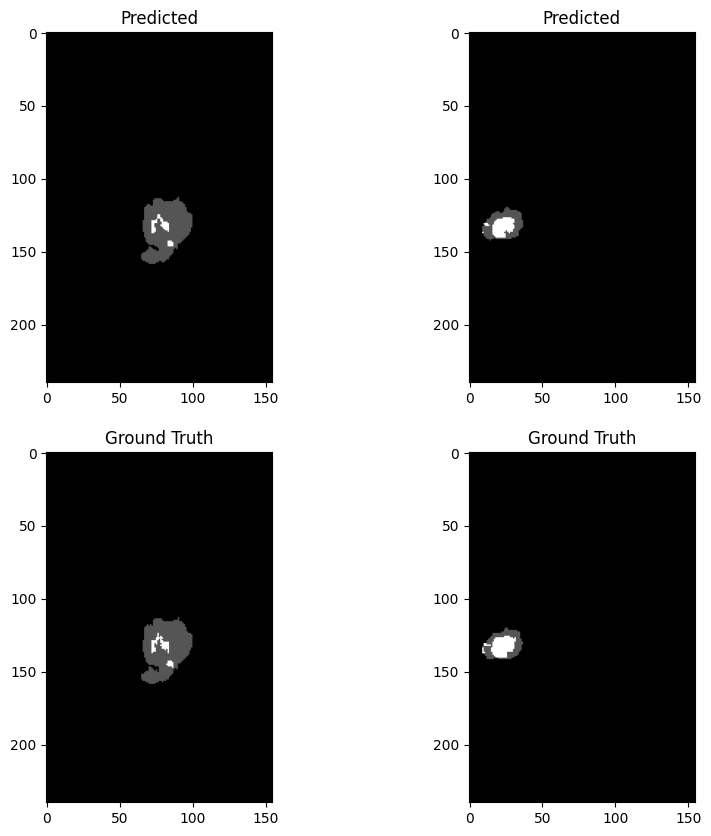

100%|██████████| 51/51 [01:18<00:00,  1.54s/it]


Average Validation Loss: 0.011193570799614284

Average Validation DSC: [0.99927105 0.90709212 0.94019173 0.85759883]
Average Validation ASSD: [ 0.07594606 16.81617397 11.98967065  6.75319614]
Epoch 100/100
-------------------------


  0%|          | 0/202 [00:00<?, ?it/s]

Training Prediction Visualization:


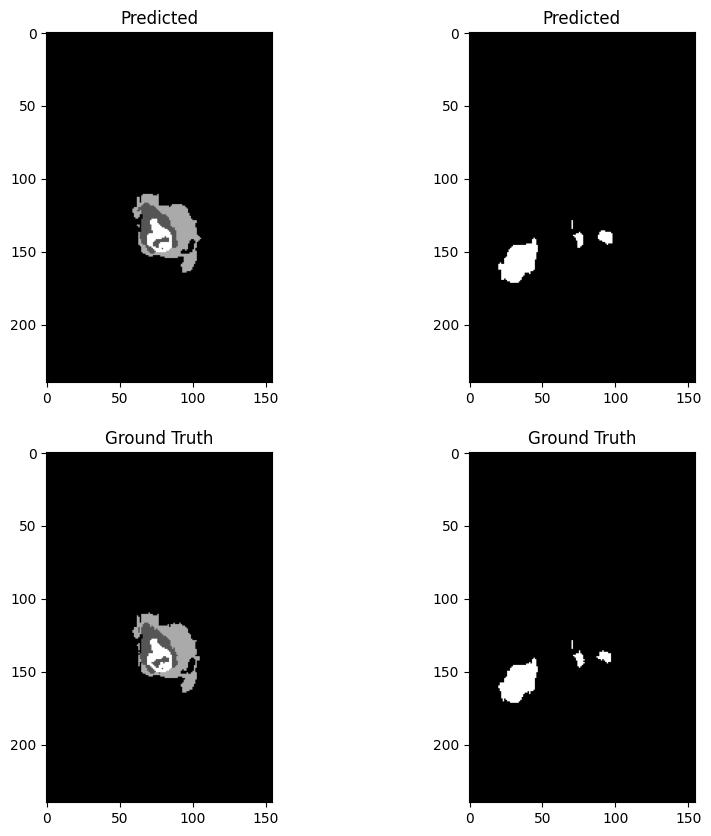

100%|██████████| 202/202 [07:09<00:00,  2.13s/it]



Average Training Loss: 0.002472726660457873

Average Training DSC: [0.99972285 0.97449264 0.97088623 0.93140218]
Average Training ASSD: [0.0222495  1.75233708 4.47514909 5.22352342]


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Prediction Visualization:


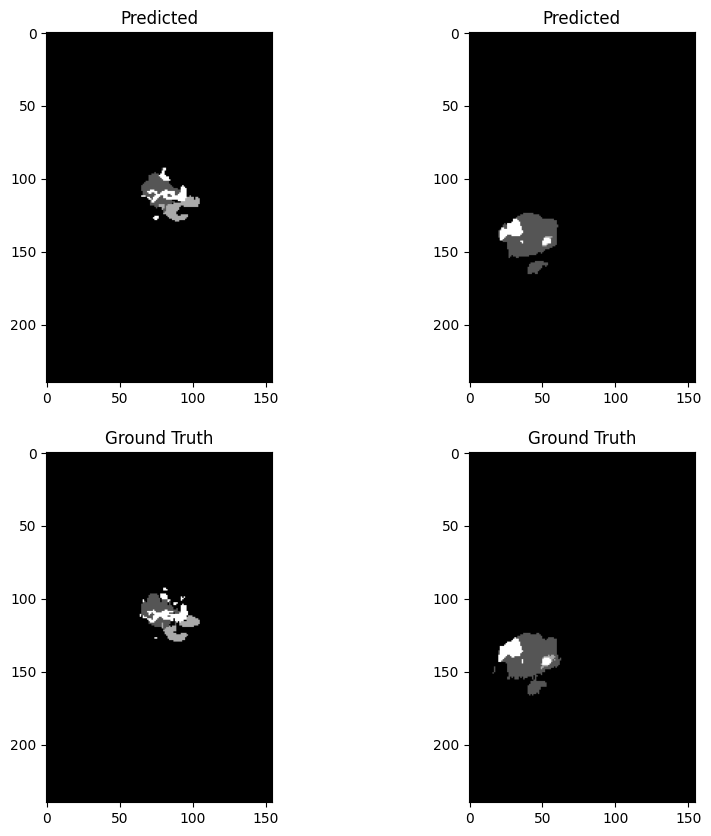

100%|██████████| 51/51 [01:16<00:00,  1.51s/it]


Average Validation Loss: 0.011429715709870352

Average Validation DSC: [0.99927447 0.89879438 0.92112234 0.85172001]
Average Validation ASSD: [ 0.07470042 20.35307673 17.62267347  7.95424203]


In [12]:
model = train_model(num_epochs = 100)